✅ Flowchart generated. Files saved in Flow_Chart folder:
 - Flow_Chart\flowchart_neurology.png
 - Flow_Chart\flowchart_neurology.pdf
 - Flow_Chart\flowchart_neurology.svg
 - Flow_Chart\flowchart_neurology.tiff
 - Flow_Chart\flowchart_neurology.dot


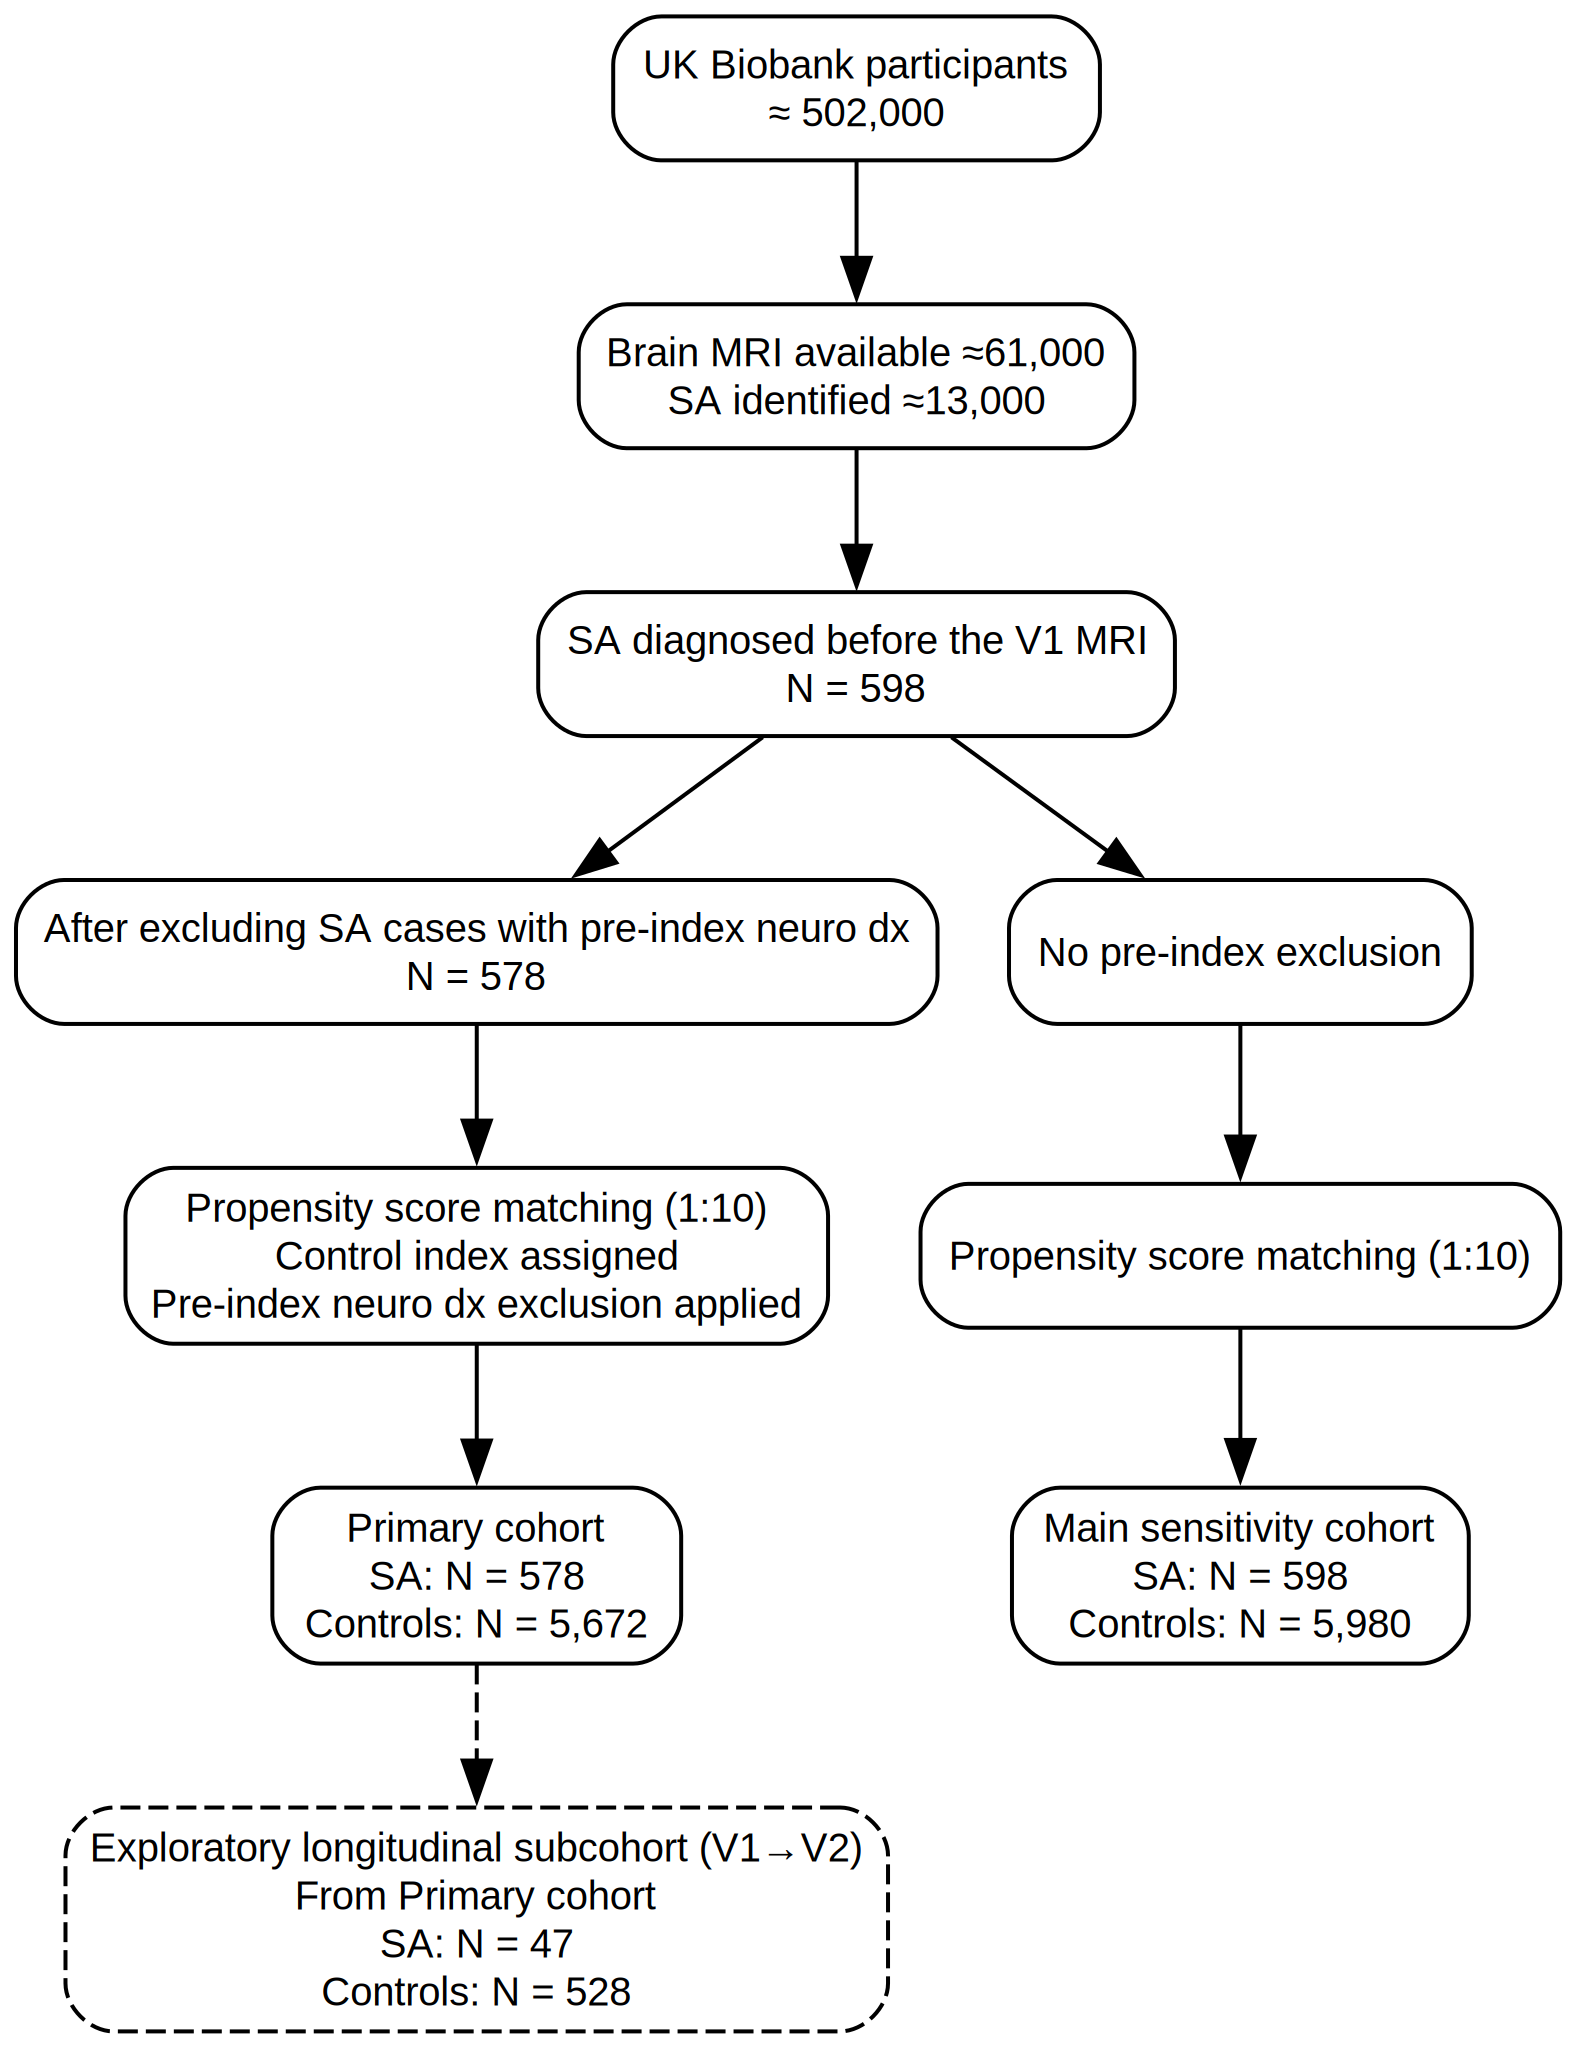

In [6]:
# Graphviz Flowchart for submission (Option 1: inline display + file export)
# If not installed, run:  !pip install graphviz
# (Optional for LZW compression of TIFF:  !pip install pillow)

import os
from datetime import datetime
from graphviz import Digraph

# Optional: Pillow for LZW-compressed TIFF post-processing
try:
    from PIL import Image
except Exception:
    Image = None  # If Pillow is not available, TIFF is still exported (without LZW)

# ------------------------------------------------------
# 1. Output directory
# ------------------------------------------------------
outdir = "Flow_Chart"
os.makedirs(outdir, exist_ok=True)

# Auto-generate filenames with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
basename = "flowchart_neurology"

# ------------------------------------------------------
# 2. Initialize graph
# ------------------------------------------------------
# Note: 'dpi' controls raster resolution for PNG/TIFF outputs.
dot = Digraph("Study_Flowchart", format="png")
dot.attr(rankdir="TB", size="8,10", dpi="600")   # TB = top-to-bottom layout; 600 dpi for high-res raster

# Global font settings (sans-serif fonts, e.g., Arial)
dot.attr("graph", fontname="Arial")
dot.attr("node", shape="rectangle", style="rounded",
         fontsize="10", fontname="Arial", color="black", fillcolor="white")
dot.attr("edge", fontname="Arial", fontsize="9")


# ------------------------------------------------------
# 3. Define nodes
# ------------------------------------------------------
dot.node("A", "UK Biobank participants\n≈ 502,000")
# dot.node("B", "I2 brain MRI (WMH IDPs) available\n≈ 61,000")
# dot.node("C", "SA identified (Self-report / Hospital)\n≈ 13,000")

dot.node("BC", "Brain MRI available ≈61,000\nSA identified ≈13,000")

dot.node("D", "SA diagnosed before the V1 MRI\nN = 598")

# Branches
dot.node("E1", "After excluding SA cases with pre-index neuro dx\nN = 578")
dot.node("E2", "No pre-index exclusion")

# Matching steps
dot.node("F1", "Propensity score matching (1:10)\nControl index assigned\nPre-index neuro dx exclusion applied")
dot.node("F2", "Propensity score matching (1:10)")

# Final cohorts
dot.node("G1", "Primary cohort\nSA: N = 578\nControls: N = 5,672")
dot.node("G2", "Main sensitivity cohort\nSA: N = 598\nControls: N = 5,980")

# Align F1 and F2 horizontally
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node("F1")
    s.node("F2")

# Align G1 and G2 horizontally
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node("G1")
    s.node("G2")

# Exploratory longitudinal subcohort (derived from Primary cohort only)
dot.node("H1", "Exploratory longitudinal subcohort (V1→V2)\nFrom Primary cohort\nSA: N = 47\nControls: N = 528",
         style="rounded,dashed")


# ------------------------------------------------------
# 4. Define edges
# ------------------------------------------------------
# Branches from A
dot.edge("A", "BC")
# dot.edge("A", "C")

# Intersection: D = B ∩ C
dot.edge("BC", "D")
# dot.edge("C", "D")

# Continue paths
# dot.edge("D", "E1", xlabel ="Primary path", labeldistance = "2.5")
# dot.edge("D", "E2", label ="Main sensitivity path", labeldistance="2.5")
dot.edge("D", "E1")
dot.edge("D", "E2")

dot.edge("E1", "F1")
dot.edge("F1", "G1")

dot.edge("E2", "F2")
dot.edge("F2", "G2")

# Dashed edge to show derivation
dot.edge("G1", "H1", style="dashed")


# #Invisible node for alignment (optional)
# dot.node("AlignLeft", "", style="invis", width="0", height="0")

# ------------------------------------------------------
# 5. Save outputs (PNG, PDF, SVG, DOT, and high-res TIFF)
# ------------------------------------------------------
# Base paths
base_path = os.path.join(outdir, basename)
png_path = base_path + ".png"
pdf_path = base_path + ".pdf"
svg_path = base_path + ".svg"
tif_path = base_path + ".tiff"
dot_path = base_path + ".dot"

# Render outputs
dot.render(filename=base_path, format="png", cleanup=True)
dot.render(filename=base_path, format="pdf", cleanup=True)
dot.render(filename=base_path, format="svg", cleanup=True)
dot.render(filename=base_path, format="tiff", cleanup=True)

# Save DOT source once
with open(dot_path, "w", encoding="utf-8") as f:
    f.write(dot.source)

# Optional TIFF LZW compression
if Image is not None and os.path.exists(tif_path):
    try:
        im = Image.open(tif_path)
        if im.mode in ("P", "L"):
            im = im.convert("RGB")
        im.save(tif_path, format="TIFF", compression="tiff_lzw")
    except Exception as e:
        print(f"[Warning] Pillow LZW compression failed: {e}")

print("✅ Flowchart generated. Files saved in Flow_Chart folder:")
print(" -", png_path)
print(" -", pdf_path)
print(" -", svg_path)
print(" -", tif_path)
print(" -", dot_path)


# ------------------------------------------------------
# 6. Display inline in Jupyter
# ------------------------------------------------------
dot  


In [2]:
# Removal of Participants Who Withdrew Consent
"""
Publication-Ready Description
-----------------------------
Objective
    Remove UK Biobank participants who have withdrawn consent from a single
    analysis dataset and report post-removal sample sizes by treatment arm.

Inputs
    1) data20250415.csv
       - Contains at minimum:
           • A participant identifier column (auto-detected; see below)
           • A treatment assignment column named exactly: treatment_var
             (e.g., 'Study' vs 'Control' or 1 vs 0)
    2) w48286_20250818.csv
       - Headerless CSV; the FIRST column lists participant IDs who withdrew consent.

Outputs
    • data.csv                             (cleaned analysis dataset)
    • Console report (publication-grade English):
        - N removed in total
        - Post-removal sample sizes by treatment_var

ID Handling
    • The participant ID column is detected heuristically from common names:
      ['Participant_ID', 'participant_id', 'eid', 'EID', 'ID', 'id'].
      If none are present, the first column is used.
    • All IDs are compared as strings to avoid leading-zero mismatches.

Notes
    • This script performs a *strict* row-wise removal: any row whose ID appears
      in the withdrawal list is dropped. No cluster or matched-set logic is applied.
    • The script prints both pre- and post-removal counts by treatment_var.

Usage
    python remove_withdrawals_simple.py
"""

from pathlib import Path
from typing import Dict, Set
import pandas as pd

# -----------------------
# Configuration
# -----------------------
DATA_IN = "data20250415.csv"
WITHDRAWN_FN = "w48286_20250818.csv"   # headerless; first column are IDs
DATA_OUT = "data.csv"

# -----------------------
# Utilities
# -----------------------
def detect_id_col(df: pd.DataFrame) -> str:
    """
    Detect the participant ID column from common names.
    Fallback: use the first column if none of the common names are present.
    """
    candidates = ["Participant_ID", "participant_id", "eid", "EID", "ID", "id"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0]

def load_withdrawn_ids(path: str | Path) -> Set[str]:
    """
    Load withdrawn IDs from a headerless CSV where the FIRST column contains IDs.
    Return as a set of strings (NaN and empty values discarded).
    """
    wd = pd.read_csv(path, header=None)
    if wd.empty:
        return set()
    col0 = wd.columns[0]
    return set(
        wd[col0]
        .astype(str)
        .str.strip()
        .replace({"nan": ""})
        .dropna()
        .loc[lambda s: s.ne("")]
        .unique()
        .tolist()
    )

def summarize_by_treatment(df: pd.DataFrame, title: str) -> Dict[str, int]:
    """
    Print and return counts by treatment_var.
    """
    print(f"\n=== {title} ===")
    if "treatment_var" not in df.columns:
        raise KeyError("Required column 'treatment_var' not found in the dataset.")
    counts = df["treatment_var"].value_counts(dropna=False).to_dict()
    total = len(df)
    # Pretty print
    print(f"Total sample size: {total}")
    for k, v in counts.items():
        print(f"  treatment_var = {k!r}: n = {v}")
    # Return a flattened dict for optional downstream use
    out = {"total": total}
    out.update({f"treatment_{k}": int(v) for k, v in counts.items()})
    return out

# -----------------------
# Main
# -----------------------
if __name__ == "__main__":
    # Existence checks
    for p in [DATA_IN, WITHDRAWN_FN]:
        if not Path(p).exists():
            raise FileNotFoundError(f"Required input not found: {p}")

    # Load main dataset
    df = pd.read_csv(DATA_IN)
    if df.empty:
        raise ValueError("Input dataset is empty: data20250415.csv")

    # Detect ID column and normalize to string for safe comparison
    id_col = detect_id_col(df)
    df[id_col] = df[id_col].astype(str).str.strip()

    # Sanity: ensure treatment_var is present
    if "treatment_var" not in df.columns:
        raise KeyError(
            "The dataset must contain a 'treatment_var' column "
            "(e.g., 'Study' vs 'Control' or 1 vs 0)."
        )

    # Load withdrawal list
    withdrawn_ids = load_withdrawn_ids(WITHDRAWN_FN)
    print(f"Loaded withdrawal list: {len(withdrawn_ids)} unique IDs.")

    # Pre-removal report
    summarize_by_treatment(df, "Pre-removal sample size by treatment_var")

    # Remove withdrawn IDs
    before_n = len(df)
    mask_keep = ~df[id_col].isin(withdrawn_ids)
    removed_n = int((~mask_keep).sum())
    df_clean = df.loc[mask_keep].copy()

    # Post-removal report
    summarize_by_treatment(df_clean, "Post-removal sample size by treatment_var")

    # High-level removal statement (publication-ready)
    print("\n--- Publication-Grade Summary ---")
    print(f"Participants removed due to withdrawn consent: n = {removed_n} "
          f"(from N = {before_n} to N = {len(df_clean)}).")
    print("Post-removal counts are reported above by 'treatment_var'.")

    # Save cleaned dataset
    df_clean.to_csv(DATA_OUT, index=False, encoding="utf-8-sig")
    print(f"\n✅ Cleaned dataset saved to: {DATA_OUT}")


C:\Users\M328449\AppData\Local\Temp\ipykernel_11008\3628346309.py:112: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_IN)


Loaded withdrawal list: 590 unique IDs.

=== Pre-removal sample size by treatment_var ===
Total sample size: 46173
  treatment_var = 0: n = 45559
  treatment_var = 1: n = 614

=== Post-removal sample size by treatment_var ===
Total sample size: 46173
  treatment_var = 0: n = 45559
  treatment_var = 1: n = 614

--- Publication-Grade Summary ---
Participants removed due to withdrawn consent: n = 0 (from N = 46173 to N = 46173).
Post-removal counts are reported above by 'treatment_var'.

✅ Cleaned dataset saved to: data.csv


In [1]:
#Cleaning & Final Dataset Preparation 
"""
UK Biobank Cleaning & Final Dataset Preparation (Submission-Ready)
-----------------------------------------------------------------
- Reads:  data.csv
- Writes: data_processed.csv (final analysis dataset)
          Process/Derived_Variables_UKB.docx / .csv
          Process/eMethod_DataProcessing.docx
          Process/Sample_Flow.txt

Pipeline
1) Normalize column names (spaces & all special characters -> underscores).
2) Derive variables (overwrite if present):
   - Age_at_Instance_2
   - Smoking_Ever
   - Alcohol_intake_frequency_ordinal
3) Impute missing values:
   - Continuous -> median (Age_at_Instance_2, Alcohol_intake_frequency_ordinal)
   - Categorical/Binary -> mode (Smoking_Ever)
4) Add Group labels from treatment_var (Study/Control, overwrite if present).
5) Exclude participants with missing WMH outcome
   ('Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2').
6) Save final dataset and generate Word documentation via python-docx.
"""

from pathlib import Path
from textwrap import dedent
import pandas as pd
import numpy as np

# --- Word generation (python-docx) ---
# pip install python-docx
try:
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.oxml.ns import qn
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_TABLE_ALIGNMENT
except Exception as e:
    raise SystemExit(
        "python-docx is required for Word outputs. "
        "Install with: pip install python-docx\n"
        f"Import error: {e}"
    )

# =========================
# Configuration
# =========================
INPUT_FILE   = "data.csv"
OUTPUT_FINAL = "data_processed.csv"
PROCESS_DIR  = Path("Process")
PROCESS_DIR.mkdir(parents=True, exist_ok=True)

# Raw WMH outcome column name (as it appears in the original CSV, BEFORE cleaning).
WMH_COL_RAW = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# New: Covariates to monitor for missingness (printing counts)
COVARIATE_COLS_TO_REPORT = [
    "Age_at_Instance_2",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# =========================
# Helpers: data processing
# =========================
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Normalize all column names to snake_case with underscores."""
    cols = (
        df.columns
          .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
          .str.replace(r"_{2,}", "_", regex=True)
          .str.strip("_")
    )
    out = df.copy()
    out.columns = cols
    return out

def derive_variables(df: pd.DataFrame) -> pd.DataFrame:
    """Create/overwrite Age_at_Instance_2, Smoking_Ever, Alcohol_intake_frequency_ordinal."""
    out = df.copy()

    col_i2_date  = "Date_of_attending_assessment_centre_Instance_2"  # UKB Field 53 (I2)
    col_yob      = "Year_of_birth"                                   # UKB Field 34
    col_smoke_i2 = "Smoking_status_Instance_2"                        # UKB Field 20160 (I2)
    col_alc_i2   = "Alcohol_intake_frequency_Instance_2"             # UKB Field 1558  (I2)

    # Age_at_Instance_2 = year(Date I2) - Year of birth
    if col_i2_date in out.columns and col_yob in out.columns:
        out[col_i2_date] = pd.to_datetime(out[col_i2_date], errors="coerce")
        out["Age_at_Instance_2"] = out[col_i2_date].dt.year - out[col_yob]
    else:
        out["Age_at_Instance_2"] = np.nan

    # Smoking_Ever from coded Smoking_status_Instance_2
    # Codes: -3=Prefer not to answer (missing), 0=Never, 1=Previous, 2=Current
    if col_smoke_i2 in out.columns:
        s = out[col_smoke_i2].replace(-3, np.nan)
        out["Smoking_Ever"] = s.apply(
            lambda v: 1 if pd.notna(v) and v in [1, 2]
            else (0 if pd.notna(v) and v == 0 else np.nan)
        )
    else:
        out["Smoking_Ever"] = np.nan

    # Alcohol_intake_frequency_ordinal (ordinal mapping; -3 -> missing)
    freq_map = {6:0, 5:1, 4:2, 3:3, 2:4, 1:5}
    if col_alc_i2 in out.columns:
        a = out[col_alc_i2].replace(-3, np.nan)
        out["Alcohol_intake_frequency_ordinal"] = a.map(freq_map)
    else:
        out["Alcohol_intake_frequency_ordinal"] = np.nan

    return out

def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """Median for continuous; mode for categorical/binary."""
    out = df.copy()
    # Continuous
    for col in ["Age_at_Instance_2", "Alcohol_intake_frequency_ordinal"]:
        if col in out.columns:
            out[col] = out[col].fillna(out[col].median()) if out[col].notna().any() else out[col].fillna(0)
    # Categorical/Binary
    for col in ["Smoking_Ever"]:
        if col in out.columns:
            out[col] = out[col].fillna(out[col].mode().iloc[0]) if out[col].notna().any() else out[col].fillna(0)
    return out

def add_group_column(df: pd.DataFrame) -> pd.DataFrame:
    """Overwrite 'Group' as 'Study' (treatment_var==1) / 'Control' (treatment_var==0) / NA otherwise."""
    out = df.copy()
    if "treatment_var" in out.columns:
        out["Group"] = out["treatment_var"].apply(
            lambda x: "Study" if x == 1 else ("Control" if x == 0 else pd.NA)
        )
    else:
        out["Group"] = pd.NA
    return out

def compute_sample_flow(df: pd.DataFrame, wmh_col_clean: str) -> dict:
    """Return sample counts and filtered df after excluding WMH-missing."""
    orig_total   = len(df)
    orig_study   = int((df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    orig_control = int((df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())

    filtered_df  = df[~df[wmh_col_clean].isna()]
    final_total  = len(filtered_df)
    final_study  = int((filtered_df.get("treatment_var", pd.Series(dtype=int)) == 1).sum())
    final_control= int((filtered_df.get("treatment_var", pd.Series(dtype=int)) == 0).sum())
    excl_total   = orig_total - final_total

    return {
        "orig_total": orig_total, "orig_study": orig_study, "orig_control": orig_control,
        "excl_total": excl_total,
        "final_total": final_total, "final_study": final_study, "final_control": final_control,
        "filtered_df": filtered_df
    }

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# New helpers: missingness reporting
def _format_missing_counts(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    """
    Build a tidy table of missing counts and rates for selected columns.
    If a column is absent, it is marked as N/A.
    """
    rows = []
    n = len(df)
    for c in cols:
        if c in df.columns:
            miss = int(df[c].isna().sum())
            rate = (miss / n * 100.0) if n > 0 else 0.0
            rows.append({"variable": c, "n_missing": miss, "pct_missing": round(rate, 2)})
        else:
            rows.append({"variable": c, "n_missing": "N/A", "pct_missing": "N/A"})
    return pd.DataFrame(rows, columns=["variable", "n_missing", "pct_missing"])

def report_covariate_missing(df: pd.DataFrame, stage: str, outdir: Path, cols: list):
    """
    Print a concise missingness report to console and save CSV under Process/.
    """
    tbl = _format_missing_counts(df, cols)
    # Console print
    print(f"\n[Missingness] {stage}")
    print(tbl.to_string(index=False))
    # Save CSV (appended by stage in filename)
    safe_stage = stage.lower().replace(" ", "_")
    tbl.to_csv(outdir / f"Missing_Covariates_{safe_stage}.csv", index=False, encoding="utf-8")
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

# =========================
# Helpers: Word documents
# =========================
def _doc_apply_default_style(doc: Document):
    """Set a clean, journal-friendly default font/size."""
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def export_variable_table_word_and_csv(process_dir: Path):
    """Create Derived_Variables_UKB.docx and CSV copy."""
    rows = [
        [
            "Age_at_Instance_2",
            "Date of attending assessment centre | 53 | Instance 2; Year of birth | 34 | —",
            "Age at I2 = year(Date of attending assessment centre at Instance 2) − Year of birth.",
            "Median imputation."
        ],
        [
            "Smoking_Ever",
            "Smoking status | 20160 | Instance 2",
            "Codes: −3=Prefer not to answer (missing), 0=Never, 1=Previous, 2=Current. Smoking_Ever = 1 if code ∈ {1,2}, else 0.",
            "Mode imputation."
        ],
        [
            "Alcohol_intake_frequency_ordinal",
            "Alcohol intake frequency | 1558 | Instance 2",
            "Ordinal mapping: 6→0 (Never), 5→1, 4→2, 3→3, 2→4, 1→5; −3 treated as missing.",
            "Median imputation."
        ],
    ]
    df_tbl = pd.DataFrame(rows, columns=[
        "Derived variable", "UKB source (name | Field ID | Instance)",
        "Definition / Rule", "Missing-data handling"
    ])
    df_tbl.to_csv(process_dir / "Derived_Variables_UKB.csv", index=False, encoding="utf-8")

    doc = Document()
    _doc_apply_default_style(doc)
    h = doc.add_heading("Derived Variables (UK Biobank)", level=1)
    h.alignment = WD_ALIGN_PARAGRAPH.LEFT

    legend = ("Legend. All derived variables were constructed from UK Biobank source fields. "
              "Missing values were imputed using the median for continuous variables and the mode for categorical variables. "
              "BMI (Instance 0), Townsend deprivation index, and Genetic ethnic grouping remained unmodified at this cleaning stage.")
    p = doc.add_paragraph(legend)
    p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    table = doc.add_table(rows=1, cols=len(df_tbl.columns))
    table.alignment = WD_TABLE_ALIGNMENT.LEFT
    hdr = table.rows[0].cells
    for i, col in enumerate(df_tbl.columns):
        hdr[i].text = col

    for r in rows:
        row = table.add_row().cells
        for i, val in enumerate(r):
            row[i].text = str(val)

    out_path = process_dir / "Derived_Variables_UKB.docx"
    doc.save(out_path)

def export_emethod_word(process_dir: Path, flow_summary: str, wmh_raw_name: str):
    """Create eMethod_DataProcessing.docx describing the data cleaning."""
    doc = Document()
    _doc_apply_default_style(doc)
    doc.add_heading("eMethod: Data Processing and Cleaning", level=1)

    txt = dedent(f"""
    We prepared the analysis dataset from a wide-format UK Biobank (UKB) extract as follows.

    1) Column-name normalization
       All column names were converted to snake_case by replacing spaces and special characters with underscores.

    2) Derived variables
       • Age_at_Instance_2 was calculated as the year of the Instance 2 assessment date (UKB Field 53) minus Year of birth (Field 34).
       • Smoking_Ever was defined from Smoking status at Instance 2 (Field 20160). Codes −3=Prefer not to answer were treated as missing; 0=Never; 1=Previous; 2=Current. Ever smokers (1 or 2) were coded as 1; never smokers as 0.
       • Alcohol_intake_frequency_ordinal was derived from Alcohol intake frequency (Field 1558) at Instance 2 using an ordinal mapping (6→0 [Never], 5→1, 4→2, 3→3, 2→4, 1→5). Code −3 was treated as missing.

    3) Missing data
       Continuous variables (Age_at_Instance_2, Alcohol_intake_frequency_ordinal) were imputed using the cohort median; the binary variable (Smoking_Ever) was imputed using the mode.

    4) Group definition
       A Group column was added as Study for participants with treatment_var=1 and Control for treatment_var=0.

    5) Outcome completeness exclusion
       Participants with missing WMH outcome were excluded. The WMH outcome field used for exclusion was:
       “{wmh_raw_name}”. The same column was matched after column-name normalization.

    6) Final dataset
       The processed dataset (data_processed.csv) includes only participants with complete WMH outcomes and the derived covariates described above.

    Sample flow summary
    {flow_summary}
    """).strip()

    for para in txt.split("\n\n"):
        p = doc.add_paragraph(para)
        p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    out_path = process_dir / "eMethod_DataProcessing.docx"
    doc.save(out_path)

# =========================
# Main
# =========================
def main():
    # 1) Load
    df = pd.read_csv(INPUT_FILE)

    # 2) Normalize column names
    df = clean_column_names(df)

    # 3) Derive (overwrite if present)
    df = derive_variables(df)

    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # New: Report covariate missingness BEFORE imputation
    report_covariate_missing(
        df=df,
        stage="Pre-imputation",
        outdir=PROCESS_DIR,
        cols=COVARIATE_COLS_TO_REPORT
    )
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    # 4) Impute missing values
    df = impute_missing(df)

    # >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    # New: Report covariate missingness AFTER imputation
    report_covariate_missing(
        df=df,
        stage="Post-imputation",
        outdir=PROCESS_DIR,
        cols=COVARIATE_COLS_TO_REPORT
    )
    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    # 5) Add Group labels (overwrite if present)
    df = add_group_column(df)

    # 6) Exclude WMH-missing using the provided raw column name (normalized)
    wmh_col_clean = (
        pd.Index([WMH_COL_RAW])
          .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
          .str.replace(r"_{2,}", "_", regex=True)
          .str.strip("_")
          .tolist()[0]
    )
    if wmh_col_clean not in df.columns:
        raise KeyError(
            f"WMH column '{WMH_COL_RAW}' not found after cleaning (expected '{wmh_col_clean}')."
        )

    flow = compute_sample_flow(df, wmh_col_clean)
    final_df = flow["filtered_df"]

    # 7) Save final dataset
    final_df.to_csv(OUTPUT_FINAL, index=False, encoding="utf-8")

    # 8) Sample flow log (console + txt)
    flow_summary = dedent(f"""
    Original: total={flow['orig_total']}, Study={flow['orig_study']}, Control={flow['orig_control']}
    Excluded WMH-missing: {flow['excl_total']}
    Final: total={flow['final_total']}, Study={flow['final_study']}, Control={flow['final_control']}
    """).strip()
    (PROCESS_DIR / "Sample_Flow.txt").write_text(flow_summary, encoding="utf-8")

    # 9) Documentation (Word + CSV)
    export_variable_table_word_and_csv(PROCESS_DIR)
    export_emethod_word(PROCESS_DIR, flow_summary, WMH_COL_RAW)

    # 10) Done
    print(f"[DONE] Final dataset saved: {OUTPUT_FINAL}")
    print("       Documentation saved in: Process/")

if __name__ == "__main__":
    main()


C:\Users\M328449\AppData\Local\Temp\ipykernel_44764\457967939.py:301: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)



[Missingness] Pre-imputation
                        variable  n_missing  pct_missing
               Age_at_Instance_2          0         0.00
                    Smoking_Ever        485         1.05
Alcohol_intake_frequency_ordinal        344         0.75

[Missingness] Post-imputation
                        variable  n_missing  pct_missing
               Age_at_Instance_2          0          0.0
                    Smoking_Ever          0          0.0
Alcohol_intake_frequency_ordinal          0          0.0
[DONE] Final dataset saved: data_processed.csv
       Documentation saved in: Process/


In [2]:
# Matching and ATO Weighting Pipeline 
"""
UK Biobank Propensity Score Matching and ATO Weighting Pipeline
=======================================================================================
This script implements a reproducible pipeline for propensity score (PS)–based cohort
construction and overlap weighting, designed for publication-quality epidemiologic
analyses of UK Biobank neuroimaging data.

Workflow
--------
1. Neuro Exclusion (Primary Cohort)
   • Exclude Study participants with any recorded neurologic disease prior to the
     sleep apnea (SA) index date.
   • Control participants are not excluded at this stage.

2. Propensity Score Estimation
   • Logistic regression using prespecified baseline covariates:
     age at MRI, sex, baseline BMI, Townsend deprivation index, genetic ethnic
     grouping, smoking status, and alcohol intake frequency.
   • Continuous covariates are median-imputed; categorical covariates are mode-imputed
     and label-encoded.
   • Primary engine: scikit-learn (lbfgs); fallback: NumPy IRLS.

3. 1:10 Nearest-Neighbor Matching (PS logit scale)
   • Matching performed without replacement and without caliper.
   • Primary cohort: post-matching risk-set pruning removes controls with any
     neurologic disease preceding the assigned SA index date.
   • Sensitivity cohort: same matching procedure but without pruning.

4. Balance Diagnostics
   • Standardized mean differences (SMDs) calculated for each covariate before and
     after matching.
   • Results exported as CSV for transparency and reproducibility.

5. Supplementary eMethod (Word Document)
   • Generates a publication-ready description of the study population, covariates,
     PS estimation, matching algorithm, and balance assessment.

6. ATO (Average Treatment effect in the Overlap population) Weighting
   • Primary ATO: MRI-anchored symmetric neuro exclusion at Instance 2, followed by
     PS estimation and overlap weights.
   • Sensitivity ATO: pseudo-index construction stratified by PS quantiles, symmetric
     neuro exclusion, PS re-estimation, and overlap weights.
   • Outputs include weighted balance diagnostics and effective sample size.

Outputs
-------
• Primary and sensitivity matched cohorts (CSV)
• Balance diagnostics before and after matching
• Neurology-style eMethod (Word, publication-ready)
• ATO cohorts (primary and sensitivity) with weights and diagnostics

Dependencies
------------
• pandas, numpy, python-docx
• scikit-learn (preferred; automatic fallback to NumPy IRLS if unavailable)
"""

from pathlib import Path
from textwrap import dedent
import pandas as pd
import numpy as np

# sklearn logistic regression (preferred)
USE_SKLEARN = True
try:
    from sklearn.linear_model import LogisticRegression
except Exception:
    USE_SKLEARN = False

# Word export
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn


# =========================
# Configuration
# =========================
INPUT_FILE = "data_processed.csv"

PRIMARY_INPUT_AFTER_NEURO = "data_processed_exclude_neuro.csv"
PRIMARY_OUT     = "primary_cohort.csv"
SENSITIVITY_OUT = "sensitivity_cohort.csv"

MATCH_DIR         = Path("Matching")
MATCH_DIR.mkdir(exist_ok=True)
MATCH_DIR_PRIMARY = MATCH_DIR / "Primary"
MATCH_DIR_SENS    = MATCH_DIR / "Sensitivity"
for p in [MATCH_DIR_PRIMARY, MATCH_DIR_SENS]:
    p.mkdir(parents=True, exist_ok=True)

# ID & core fields
COL_ID_CANDIDATES = ["Participant_ID", "eid"]  # fallback: first column
COL_TREAT         = "treatment_var"            # 1=Study, 0=Control

# ---- Canonical names used INSIDE code ----
# We'll automatically map real CSV columns (with or without trailing underscore) to these canonical names.
COL_SA_DATE_CANON = "Date_G47_first_reported_sleep_disorders"  # canonical
NEURO_DATE_COLS_CANON = [
    "Date_I63_first_reported_cerebral_infarction",
    "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
    "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes",
    "Date_G35_first_reported_multiple_sclerosis",
    "Date_I67_first_reported_other_cerebrovascular_diseases",
]

# Prespecified covariates (use-if-present; others skipped with a warning)
BASE_COVARIATES = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]

# Matching parameters
RATIO = 10
WITH_REPLACEMENT = False


# =========================
# Column aliasing (handles trailing underscores removed by your CSV)
# =========================
# Map from our canonical name -> list of acceptable variants in the CSV (priority order)
COLUMN_ALIASES = {
    # SA index date
    COL_SA_DATE_CANON: [
        "Date_G47_first_reported_sleep_disorders",          # preferred
        "Date_G47_first_reported_sleep_disorders"           # without trailing underscore
    ],
    # Neuro dates
    "Date_I63_first_reported_cerebral_infarction": [
        "Date_I63_first_reported_cerebral_infarction",
        "Date_I63_first_reported_cerebral_infarction"
    ],
    "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction": [
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction",
        "Date_I64_first_reported_stroke_not_specified_as_haemorrhage_or_infarction"
    ],
    "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes": [
        "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes",
        "Date_G45_first_reported_transient_cerebral_ischaemic_attacks_and_related_syndromes"
    ],
    "Date_G35_first_reported_multiple_sclerosis": [
        "Date_G35_first_reported_multiple_sclerosis",
        "Date_G35_first_reported_multiple_sclerosis"
    ],
    "Date_I67_first_reported_other_cerebrovascular_diseases": [
        "Date_I67_first_reported_other_cerebrovascular_diseases",
        "Date_I67_first_reported_other_cerebrovascular_diseases"
    ],
}

def apply_column_aliases(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure that the DataFrame has our canonical column names by renaming
    any existing variant (with/without trailing underscore) to the canonical.
    """
    df = df.copy()
    current = set(df.columns)
    rename_map = {}
    for canon, variants in COLUMN_ALIASES.items():
        for v in variants:
            if v in current:
                rename_map[v] = canon
                break
    if rename_map:
        df = df.rename(columns=rename_map)
    return df


# =========================
# Utilities
# =========================
def pick_id_column(df: pd.DataFrame) -> str:
    for c in COL_ID_CANDIDATES:
        if c in df.columns:
            return c
    return df.columns[0]

def ensure_datetime(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")
    return out

def ps_logit(p: np.ndarray) -> np.ndarray:
    p = np.clip(p, 1e-6, 1 - 1e-6)
    return np.log(p / (1 - p))

def fill_and_encode_inplace(df: pd.DataFrame, cols: list) -> tuple[pd.DataFrame, list]:
    """
    Prepare covariates for logistic regression:
      - numeric: median imputation
      - non-numeric: mode imputation -> categorical codes
    Returns (prepared_df, actually_used_covs)
    """
    used = []
    out = df.copy()
    for col in cols:
        if col not in out.columns:
            print(f"[WARN] Missing covariate dropped: {col}")
            continue
        s = out[col]
        if pd.api.types.is_numeric_dtype(s):
            out[col] = s.fillna(s.median()) if s.notna().any() else s.fillna(0)
        else:
            if s.isna().all():
                out[col] = "Unknown"
            else:
                mode_val = s.mode(dropna=True)
                mode_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
                out[col] = s.fillna(mode_val)
            out[col] = out[col].astype("category").cat.codes
        used.append(col)
    return out, used

def smd_numeric(x: pd.Series, g: pd.Series) -> float:
    """Standardized mean difference for numeric variable by binary group g (1=Study, 0=Control)."""
    x1 = x[g == 1].astype(float)
    x0 = x[g == 0].astype(float)
    if len(x1) < 2 or len(x0) < 2:
        return np.nan
    m1, m0 = x1.mean(), x0.mean()
    s1, s0 = x1.std(ddof=1), x0.std(ddof=1)
    sp = np.sqrt(((len(x1)-1)*s1**2 + (len(x0)-1)*s0**2) / max(len(x1)+len(x0)-2, 1))
    return float((m1 - m0) / sp) if sp > 0 else np.nan

def balance_table(df: pd.DataFrame, covs: list, treat_col: str, label: str) -> pd.DataFrame:
    rows = []
    for c in covs:
        if c not in df.columns:
            continue
        s = df[c]
        if not pd.api.types.is_numeric_dtype(s):
            s = s.astype("category").cat.codes
        smd = smd_numeric(s, df[treat_col])
        rows.append({"label": label, "covariate": c, "SMD": smd})
    return pd.DataFrame(rows)

def write_text(path: Path, text: str):
    path.write_text(text.strip() + "\n", encoding="utf-8")

# Fallback: tiny NumPy IRLS logistic regression (only used if sklearn unavailable)
def _irls_logistic_predict_proba(X: np.ndarray, y: np.ndarray, max_iter: int = 1000, tol: float = 1e-6) -> np.ndarray:
    X = np.c_[np.ones((X.shape[0], 1)), X]  # add intercept
    beta = np.zeros(X.shape[1])
    for _ in range(max_iter):
        z = X @ beta
        p = 1.0 / (1.0 + np.exp(-np.clip(z, -50, 50)))
        W = p * (1 - p) + 1e-8
        z_tilde = z + (y - p) / W
        XT_W = X.T * W
        H = XT_W @ X
        g = XT_W @ z_tilde
        try:
            beta_new = np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            beta_new = np.linalg.pinv(H) @ g
        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new
    p_final = 1.0 / (1.0 + np.exp(-np.clip(X @ beta, -50, 50)))
    return np.clip(p_final, 1e-9, 1-1e-9)


# =========================
# Step 1: Neuro exclusion (Study only -> primary input)
# =========================
def neuro_exclusion_study_only(input_file: str, output_file: str):
    df = pd.read_csv(input_file)
    # --- apply alias mapping so we can use canonical names below ---
    df = apply_column_aliases(df)

    need_cols = [COL_TREAT, COL_SA_DATE_CANON, *NEURO_DATE_COLS_CANON]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise KeyError(f"Missing required columns for neuro exclusion (after aliasing): {miss}")

    df = ensure_datetime(df, [COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)
    study_mask = df[COL_TREAT] == 1
    lt_matrix = pd.DataFrame({c: df[c].lt(df[COL_SA_DATE_CANON]) for c in NEURO_DATE_COLS_CANON})
    exclude_mask = study_mask & lt_matrix.any(axis=1)

    kept = df[~exclude_mask].copy()
    excluded = df[exclude_mask].copy()
    kept.to_csv(output_file, index=False)

    summ = dedent(f"""
    ===== Neuro Exclusion (Study only; ANY neuro date < SA index_date) =====
    Input : {input_file}
    Output: {output_file}

    Original: total={len(df)}, Study={(df[COL_TREAT]==1).sum()}, Control={(df[COL_TREAT]==0).sum()}
    Excluded: total={len(excluded)}, Study={(excluded[COL_TREAT]==1).sum()}, Control={(excluded[COL_TREAT]==0).sum()}
    Final   : total={len(kept)}, Study={(kept[COL_TREAT]==1).sum()}, Control={(kept[COL_TREAT]==0).sum()}

    Note: Column aliasing enabled (with/without trailing underscores).
    """).strip()
    write_text(MATCH_DIR / "Neuro_Exclusion_Summary.txt", summ)
    print(summ)


# =========================
# Step 2A: Propensity score estimation
# =========================
def estimate_propensity(df_in: pd.DataFrame, covariates: list) -> tuple[pd.DataFrame, list, str]:
    """
    Preferred: sklearn LogisticRegression(lbfgs, max_iter=1000).
    Fallback : pure-NumPy IRLS with identical input/output interface.
    Returns: (df_with_ps, used_covariates, engine_str)
    """
    if COL_TREAT not in df_in.columns:
        raise KeyError(f"'{COL_TREAT}' not found.")

    df = df_in.copy()
    # also ensure aliasing here in case user modified columns between steps
    df = apply_column_aliases(df)

    df[COL_TREAT] = pd.to_numeric(df[COL_TREAT], errors="coerce")
    df = df.dropna(subset=[COL_TREAT])

    df, used_covs = fill_and_encode_inplace(df, covariates)
    if not used_covs:
        raise ValueError("No usable covariates for propensity estimation.")

    X = df[used_covs].to_numpy()
    y = df[COL_TREAT].astype(int).to_numpy()

    if USE_SKLEARN:
        model = LogisticRegression(max_iter=1000, solver="lbfgs")
        model.fit(X, y)
        df["propensity_score"] = np.clip(model.predict_proba(X)[:, 1], 1e-9, 1-1e-9)
        engine = "sklearn-LogisticRegression (lbfgs)"
    else:
        df["propensity_score"] = _irls_logistic_predict_proba(X, y, max_iter=1000, tol=1e-6)
        engine = "NumPy-IRLS (fallback)"

    return df, used_covs, engine


# =========================
# Step 2B: Matching (Primary with pruning; Sensitivity without)
# =========================
def match_primary(df_ps: pd.DataFrame, ratio: int, out_csv: str, diag_dir: Path):
    # Ensure aliasing (for dates) before referencing canonical column names
    df_ps = apply_column_aliases(df_ps)
    id_col = pick_id_column(df_ps)

    need = [id_col, COL_TREAT, "propensity_score", COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON
    miss = [c for c in need if c not in df_ps.columns]
    if miss:
        raise KeyError(f"Missing required columns for primary matching (after aliasing): {miss}")

    df = ensure_datetime(df_ps, [COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON).copy()
    df["_orig_index_"] = np.arange(len(df))

    df["_logit_ps"] = ps_logit(df["propensity_score"].to_numpy())
    treated  = df[df[COL_TREAT] == 1].copy().sort_values("_logit_ps").reset_index(drop=True)
    controls = df[df[COL_TREAT] == 0].copy().sort_values("_logit_ps").reset_index(drop=True)
    controls["_available"] = True

    matched_rows, treated_used, drop_no_avail = [], [], 0

    def pick_k_neighbors(trow, controls_df, k):
        diffs = np.abs(controls_df["_logit_ps"].values - trow["_logit_ps"])
        order = np.argsort(diffs)
        ordered = controls_df.iloc[order]
        ordered = ordered[ordered["_available"]]
        if ordered.empty:
            return []
        return ordered.index[:k].tolist()

    for _, t in treated.iterrows():
        if not controls["_available"].any():
            drop_no_avail += 1
            continue
        idxs = pick_k_neighbors(t, controls, ratio)
        if len(idxs) == 0:
            drop_no_avail += 1
            continue
        treated_used.append(t[id_col])
        for ci in idxs:
            crow = controls.loc[ci].copy()
            if not WITH_REPLACEMENT:
                controls.at[ci, "_available"] = False
            row = crow.to_dict()
            row["match_id_orig"] = t[id_col]
            matched_rows.append(row)

    matched_treated_df = df[(df[COL_TREAT]==1) & (df[id_col].isin(treated_used))].copy()
    matched_treated_df["group"] = "Study"
    matched_treated_df["match_id_orig"] = matched_treated_df[id_col].values
    matched_treated_df["index_date"] = matched_treated_df[COL_SA_DATE_CANON]

    matched_controls_df = pd.DataFrame(matched_rows)
    if matched_controls_df.empty:
        raise ValueError("No controls matched in primary stream.")
    matched_controls_df["group"] = "Control"
    study_idx_map = matched_treated_df.set_index("match_id_orig")[COL_SA_DATE_CANON].to_dict()
    matched_controls_df["index_date"] = matched_controls_df["match_id_orig"].map(study_idx_map)

    matched_all = pd.concat([matched_treated_df, matched_controls_df], ignore_index=True)

    # Risk-set pruning on controls: drop if ANY neuro date < index_date
    control_mask = (matched_all["group"] == "Control")
    lt_matrix = pd.DataFrame({
        c: matched_all.loc[control_mask, c].lt(matched_all.loc[control_mask, "index_date"])
        for c in NEURO_DATE_COLS_CANON
    })
    control_bad = lt_matrix.any(axis=1)
    bad_idx = matched_all.loc[control_mask].index[control_bad.values]
    n_ctrl_dropped = len(bad_idx)

    matched_all_pruned = matched_all.drop(index=bad_idx).copy()

    # Remove studies without remaining controls
    post_counts = (matched_all_pruned[matched_all_pruned["group"]=="Control"]
                   .groupby("match_id_orig")[id_col].count())
    studies_no_ctrl = (matched_all_pruned[matched_all_pruned["group"]=="Study"]
                       .loc[lambda d: ~d["match_id_orig"].isin(post_counts.index), ["match_id_orig"]])
    n_study_dropped = len(studies_no_ctrl)
    if n_study_dropped > 0:
        matched_all_pruned = matched_all_pruned[
            ~matched_all_pruned["match_id_orig"].isin(studies_no_ctrl["match_id_orig"])
        ].copy()

    # Recode match_id 0..M-1 by original order
    study_order = (matched_all_pruned[matched_all_pruned["group"]=="Study"]
                   .sort_values("_orig_index_")["match_id_orig"].drop_duplicates().tolist())
    id_map = {orig_id: i for i, orig_id in enumerate(study_order)}
    matched_all_pruned["match_id"] = matched_all_pruned["match_id_orig"].map(id_map).astype(int)

    # Sort and save
    matched_all_pruned["group"] = pd.Categorical(matched_all_pruned["group"],
                                                 categories=["Control","Study"], ordered=True)
    matched_all_pruned = matched_all_pruned.sort_values(by=["group", "match_id", id_col]).reset_index(drop=True)

    matched_all_pruned = matched_all_pruned.drop(
        columns=[c for c in ["_available","_logit_ps","_orig_index_","match_id_orig"] if c in matched_all_pruned.columns]
    )
    matched_all_pruned.to_csv(out_csv, index=False, encoding="utf-8-sig")

    # Diagnostics
    n_study_after = (matched_all_pruned["group"]=="Study").sum()
    n_ctrl_after  = (matched_all_pruned["group"]=="Control").sum()
    avg_ctrls     = (n_ctrl_after / n_study_after) if n_study_after else 0.0

    bal_before = balance_table(df_ps.assign(treatment_var=df_ps[COL_TREAT].astype(int)),
                                BASE_COVARIATES, "treatment_var", "before")
    bal_after  = balance_table(matched_all_pruned.assign(treatment_var=(matched_all_pruned["group"]=="Study").astype(int)),
                               BASE_COVARIATES, "treatment_var", "after")
    pd.concat([bal_before, bal_after], ignore_index=True)\
      .to_csv(diag_dir / "Balance_Before_After.csv", index=False, encoding="utf-8")

    summ = dedent(f"""
    ===== Primary Matching (1:{RATIO}, no caliper, no replacement) =====
    Risk-set pruning:
      Controls dropped (ANY neuro < index_date) : {n_ctrl_dropped}
      Studies dropped (no controls left)        : {n_study_dropped}

    Final matched sizes:
      Study (after)   : {n_study_after}
      Control (after) : {n_ctrl_after}
      Avg controls per Study: {avg_ctrls:.2f} (target={RATIO})

    Note: Column aliasing enabled (with/without trailing underscores).
    """).strip()
    write_text(diag_dir / "PSM_Summary.txt", summ)
    print(summ)


def match_sensitivity(df_ps: pd.DataFrame, ratio: int, out_csv: str, diag_dir: Path):
    df_ps = apply_column_aliases(df_ps)
    id_col = pick_id_column(df_ps)

    need = [id_col, COL_TREAT, "propensity_score", COL_SA_DATE_CANON]
    miss = [c for c in need if c not in df_ps.columns]
    if miss:
        raise KeyError(f"Missing required columns for sensitivity matching (after aliasing): {miss}")

    df = ensure_datetime(df_ps, [COL_SA_DATE_CANON]).copy()
    treated = df[df[COL_TREAT] == 1].reset_index(drop=True)
    control = df[df[COL_TREAT] == 0].reset_index(drop=True)

    t_scores = ps_logit(treated["propensity_score"].to_numpy())
    c_scores = ps_logit(control["propensity_score"].to_numpy())

    matched_flags = np.zeros(len(control), dtype=bool)
    match_results, drop_no_avail = [], 0

    for i, ps in enumerate(t_scores):
        avail = np.where(~matched_flags)[0]
        if avail.size == 0:
            drop_no_avail += 1
            continue
        diffs = np.abs(c_scores[avail] - ps)
        k = min(ratio, len(avail))
        best = avail[np.argpartition(diffs, k-1)[:k]]
        matched_flags[best] = True
        match_results.append((i, best.tolist()))

    # Assemble
    matched_controls = []
    for t_idx, c_idxs in match_results:
        for c_idx in c_idxs:
            r = control.iloc[c_idx].copy()
            r["match_id_tmp"] = t_idx
            matched_controls.append(r)
    matched_controls = pd.DataFrame(matched_controls)

    matched_treated_ids = [t_idx for t_idx, _ in match_results]
    treated_sub = treated.loc[matched_treated_ids].copy()
    treated_sub["old_idx"] = treated_sub.index

    id_map = {old: new for new, old in enumerate(matched_treated_ids)}
    treated_sub["match_id"] = treated_sub["old_idx"].map(id_map)
    if not matched_controls.empty:
        matched_controls["match_id"] = matched_controls["match_id_tmp"].map(id_map)

    treated_sub["group"] = "Study"
    if not matched_controls.empty:
        matched_controls["group"] = "Control"

    # index_date propagation
    study_index_map = treated_sub.set_index("match_id")[COL_SA_DATE_CANON].to_dict()
    treated_sub["index_date"] = treated_sub[COL_SA_DATE_CANON]
    if not matched_controls.empty:
        matched_controls["index_date"] = matched_controls["match_id"].map(study_index_map)

    matched_all = pd.concat([treated_sub, matched_controls], ignore_index=True)

    # Cleanup & sort
    for tmp in ["match_id_tmp", "old_idx"]:
        if tmp in matched_all.columns:
            matched_all = matched_all.drop(columns=[tmp])

    matched_all["group"] = pd.Categorical(matched_all["group"], categories=["Control","Study"], ordered=True)
    matched_all = matched_all.sort_values(by=["group","match_id", id_col]).reset_index(drop=True)

    matched_all.to_csv(out_csv, index=False, encoding="utf-8-sig")

    # Diagnostics
    n_study = (matched_all["group"]=="Study").sum()
    n_ctrl  = (matched_all["group"]=="Control").sum()
    matched_counts = [len(c_idxs) for _, c_idxs in match_results]
    dist_text = ""
    if matched_counts:
        vc = pd.Series(matched_counts).value_counts().sort_index()
        dist_text = "\n".join([f"  {k} controls: {v}" for k, v in vc.items()])

    bal_before = balance_table(df_ps, BASE_COVARIATES, COL_TREAT, "before")
    bal_after  = balance_table(matched_all.assign(treatment_var=(matched_all["group"]=="Study").astype(int)),
                               BASE_COVARIATES, "treatment_var", "after")
    pd.concat([bal_before, bal_after], ignore_index=True)\
      .to_csv(diag_dir / "Balance_Before_After.csv", index=False, encoding="utf-8")

    summ = dedent(f"""
    ===== Sensitivity Matching (1:{RATIO}, no caliper, no replacement, no pruning) =====
    Final matched sizes:
      Study   : {n_study}
      Control : {n_ctrl}
    Note: Column aliasing enabled (with/without trailing underscores).
    """).strip()
    write_text(diag_dir / "PSM_Summary.txt", summ)
    print(summ)


# =========================
# eMethod (Neurology-style Word)
# =========================
def _doc_style(doc: Document):
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def export_emethod_matching(primary_used_covs: list, sens_used_covs: list, engine_primary: str, engine_sens: str):
    doc = Document()
    _doc_style(doc)
    doc.add_heading("Supplementary eMethod: Propensity Score Estimation and Matching", level=1)

    # Study population
    doc.add_heading("Study population", level=2)
    para = ("UK Biobank imaging participants with usable T1- and T2-FLAIR MRI at Instance 2 were included. "
            "Participants with missing WMH outcomes were excluded upstream. The primary cohort additionally "
            "excluded Study participants with any neurologic diagnosis recorded prior to the sleep apnea (SA) "
            "index date; the sensitivity cohort applied no such exclusion.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Variables
    doc.add_heading("Variables", level=2)
    para = ("Prespecified covariates were age at MRI, sex, baseline BMI (Instance 0), Townsend deprivation index, "
            "genetic ethnic grouping (binary), smoking (ever vs never), and alcohol intake frequency (ordinal). "
            "Missing data were handled by median imputation for continuous covariates and mode imputation with "
            "label encoding for categorical covariates.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Propensity score estimation
    doc.add_heading("Propensity score estimation", level=2)
    para = (f"Propensity scores were estimated via logistic regression separately for the two cohorts. "
            f"For the primary cohort, the engine was {engine_primary}; covariates actually used: "
            f"{', '.join(primary_used_covs) if primary_used_covs else 'None'}. "
            f"For the sensitivity cohort, the engine was {engine_sens}; covariates actually used: "
            f"{', '.join(sens_used_covs) if sens_used_covs else 'None'}. "
            f"Column aliasing was implemented to harmonize date-field names with/without trailing underscores.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Matching procedure
    doc.add_heading("Matching procedure", level=2)
    para = (f"Each SA case was matched to up to {RATIO} controls using nearest-neighbor matching on the logit of the "
            "propensity score, without replacement and without a caliper.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Sensitivity analysis
    doc.add_heading("Sensitivity analysis", level=2)
    para = ("In the primary cohort, post-matching risk-set pruning excluded controls with any neurologic diagnosis "
            "preceding the matched SA index date; SA cases without remaining controls were removed. "
            "The sensitivity cohort conducted the same matching without pruning.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Balance assessment
    doc.add_heading("Balance assessment", level=2)
    para = ("Covariate balance was evaluated using standardized mean differences (SMDs) before and after matching. "
            "Diagnostics are provided in the Matching directory.")
    doc.add_paragraph(para).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    out_path = MATCH_DIR / "eMethod_Matching.docx"
    doc.save(out_path)
    print(f"[OK] Neurology-style eMethod saved: {out_path}")


# =========================
# Main
# =========================
def main():
    # Step 1: Neuro exclusion -> primary input
    neuro_exclusion_study_only(INPUT_FILE, PRIMARY_INPUT_AFTER_NEURO)

    # Step 2: Primary stream
    df_primary_base = pd.read_csv(PRIMARY_INPUT_AFTER_NEURO)
    df_primary_base = apply_column_aliases(df_primary_base)
    df_primary_ps, primary_used_covs, engine_primary = estimate_propensity(df_primary_base, BASE_COVARIATES)
    match_primary(df_primary_ps, RATIO, PRIMARY_OUT, MATCH_DIR_PRIMARY)

    # Step 2: Sensitivity stream
    df_sens_base = pd.read_csv(INPUT_FILE)
    df_sens_base = apply_column_aliases(df_sens_base)
    df_sens_ps, sens_used_covs, engine_sens = estimate_propensity(df_sens_base, BASE_COVARIATES)
    match_sensitivity(df_sens_ps, RATIO, SENSITIVITY_OUT, MATCH_DIR_SENS)

    # eMethod (Neurology style)
    export_emethod_matching(primary_used_covs, sens_used_covs, engine_primary, engine_sens)

    print("\n[DONE] Outputs:")
    print(f"  • {PRIMARY_INPUT_AFTER_NEURO}")
    print(f"  • {PRIMARY_OUT}")
    print(f"  • {SENSITIVITY_OUT}")
    print(f"  • Matching diagnostics under: {MATCH_DIR}/")
    if not USE_SKLEARN:
        print("  [Note] sklearn not available in this environment; used NumPy IRLS fallback for PS.")

if __name__ == "__main__":
    main()

# =========================
# ATO (Overlap Weighting) cohorts
# =========================

# --- New outputs & dirs ---
ATO_DIR = Path("ATO")
ATO_DIR_SYM = ATO_DIR / "SymmetricExclusion"
ATO_DIR_NOEX = ATO_DIR / "NoExclusion"
for p in [ATO_DIR, ATO_DIR_SYM, ATO_DIR_NOEX]:
    p.mkdir(parents=True, exist_ok=True)

ATO_SYM_OUT    = "ato_sensitivity_sym.csv"
ATO_NOEX_OUT   = "ato_sensitivity_noexclusion.csv"

# --- Add a canonical I2 MRI date column & aliases (best-effort guesses; extend if needed) ---
COL_I2_DATE_CANON = "Date_of_attending_assessment_centre_Instance_2"
COLUMN_ALIASES[COL_I2_DATE_CANON] = [
    "Date_of_attending_assessment_centre_Instance_2",
    "Date_of_attending_assessment_centre_instance_2",
    "Date_of_attending_assessment_centre_Instance_2_",
    "Date_of_attending_assessment_centre_instance_2_",
]

def detect_i2_date_column(df: pd.DataFrame) -> str | None:
    """
    Heuristic: try to find an I2 date column if aliases failed.
    Looks for case-insensitive tokens around 'Instance_2' and any of {'MRI','Imaging','assessment','centre','center','date'}.
    """
    cand = []
    toks_any = ("mri", "imaging", "assessment", "centre", "center", "date")
    for c in df.columns:
        low = c.lower()
        if "instance_2" in low and any(t in low for t in toks_any):
            cand.append(c)
    if not cand:
        for c in df.columns:
            low = c.lower()
            if "instance 2" in low and any(t in low for t in toks_any):
                cand.append(c)
    return cand[0] if cand else None

def ensure_i2_date_present(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure df has COL_I2_DATE_CANON (rename or detect)."""
    df2 = apply_column_aliases(df)
    if COL_I2_DATE_CANON not in df2.columns:
        guess = detect_i2_date_column(df2)
        if guess is None:
            raise KeyError(
                f"Could not find I2 MRI date column. "
                f"Add an alias for '{COL_I2_DATE_CANON}' to COLUMN_ALIASES or ensure a suitable column exists."
            )
        df2 = df2.rename(columns={guess: COL_I2_DATE_CANON})
    return ensure_datetime(df2, [COL_I2_DATE_CANON])

# ---------- Weighted balance diagnostics ----------
def wmean(x: np.ndarray, w: np.ndarray) -> float:
    w = np.asarray(w, float)
    x = np.asarray(x, float)
    s = w.sum()
    return float((w * x).sum() / s) if s > 0 else np.nan

def wvar(x: np.ndarray, w: np.ndarray) -> float:
    mu = wmean(x, w)
    s = w.sum()
    if s <= 0:
        return np.nan
    return float((w * (x - mu) ** 2).sum() / s)

def wstd(x: np.ndarray, w: np.ndarray) -> float:
    v = wvar(x, w)
    return float(np.sqrt(v)) if v >= 0 else np.nan

def weighted_smd(x: pd.Series, treat: pd.Series, w: pd.Series) -> float:
    """Weighted SMD using pooled weighted SD."""
    x = x.copy()
    if not pd.api.types.is_numeric_dtype(x):
        x = x.astype("category").cat.codes
    g1 = (treat == 1).values
    g0 = (treat == 0).values
    w = w.values.astype(float)
    xv = x.values.astype(float)

    mu1 = wmean(xv[g1], w[g1]); mu0 = wmean(xv[g0], w[g0])
    s1  = wstd(xv[g1], w[g1]);  s0  = wstd(xv[g0], w[g0])
    denom = np.sqrt((s1**2 + s0**2) / 2.0) if np.isfinite(s1) and np.isfinite(s0) else np.nan
    if denom is None or not np.isfinite(denom) or denom == 0:
        return np.nan
    return float((mu1 - mu0) / denom)

def weighted_balance_table(df: pd.DataFrame, covs: list, treat_col: str, wcol: str, label: str) -> pd.DataFrame:
    rows = []
    for c in covs:
        if c not in df.columns:
            continue
        smd = weighted_smd(df[c], df[treat_col], df[wcol])
        rows.append({"label": label, "covariate": c, "Weighted_SMD": smd})
    return pd.DataFrame(rows)

def effective_sample_size(w: np.ndarray) -> float:
    w = np.asarray(w, float)
    num = (w.sum()) ** 2
    den = (w ** 2).sum()
    return float(num / den) if den > 0 else np.nan

# ---------- ATO weights ----------
def add_ato_weights(df: pd.DataFrame, ps_col: str = "propensity_score", treat_col: str = COL_TREAT,
                    normalize: bool = True, add_group_norm: bool = True) -> pd.DataFrame:
    out = df.copy()
    if ps_col not in out.columns:
        raise KeyError(f"Propensity score column '{ps_col}' not found.")
    if treat_col not in out.columns:
        raise KeyError(f"Treatment column '{treat_col}' not found.")
    p = np.clip(out[ps_col].astype(float).values, 1e-6, 1 - 1e-6)
    z = out[treat_col].astype(int).values
    w = np.where(z == 1, 1.0 - p, p)  # ATO weights
    out["ato_weight"] = w

    if normalize:
        out["ato_weight_norm"] = out["ato_weight"] * (len(out) / out["ato_weight"].sum())

    if add_group_norm:
        out["ato_weight_gnorm"] = out["ato_weight"]
        for g in [0, 1]:
            mask = (out[treat_col] == g)
            s = out.loc[mask, "ato_weight"].sum()
            if s > 0:
                out.loc[mask, "ato_weight_gnorm"] = out.loc[mask, "ato_weight"] * (mask.sum() / s)
    return out

# ---------- ATO 1: MRI-anchored symmetric exclusion ----------
def build_ato_sensitivity_sym(input_csv: str, covariates: list) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    df = ensure_i2_date_present(df)
    df = apply_column_aliases(df)
    need_cols = [COL_TREAT, COL_I2_DATE_CANON] + NEURO_DATE_COLS_CANON
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise KeyError(f"[ATO-Sym] Missing required columns: {miss}")

    df = ensure_datetime(df, [COL_I2_DATE_CANON, COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)

    # Exclude ANY neuro date < I2 date (both Study and Control)
    neuro_before_i2 = pd.DataFrame({c: df[c].le(df[COL_I2_DATE_CANON]) for c in NEURO_DATE_COLS_CANON})
    df = df.loc[~neuro_before_i2.any(axis=1)].copy()

    df_ps, used_covs, engine = estimate_propensity(df, covariates)
    df_ps = add_ato_weights(df_ps, ps_col="propensity_score", treat_col=COL_TREAT,
                            normalize=True, add_group_norm=True)

    diag = ATO_DIR_SYM
    wbal = weighted_balance_table(df_ps, used_covs, COL_TREAT, "ato_weight_norm", "ATO_sensitivity_sym")
    wbal.to_csv(diag / "Weighted_Balance.csv", index=False, encoding="utf-8-sig")

    ess_all  = effective_sample_size(df_ps["ato_weight_norm"].values)
    ess_treat = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==1, "ato_weight_norm"].values)
    ess_ctrl  = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==0, "ato_weight_norm"].values)

    summ = dedent(f"""
    ===== ATO Sensitivity (MRI-anchored symmetric neuro exclusion at I2) =====
    Input : {input_csv}
    Rows after exclusion: {len(df_ps)}

    Propensity engine: {engine}
    Covariates used  : {', '.join(used_covs) if used_covs else 'None'}

    Effective Sample Size (normalized weights):
      ESS (all)   : {ess_all:.1f}
      ESS (Study) : {ess_treat:.1f}
      ESS (Control): {ess_ctrl:.1f}
    """).strip()
    write_text(diag / "ATO_Summary.txt", summ)
    print(summ)

    out_cols_first = [pick_id_column(df_ps), COL_TREAT, "propensity_score",
                      "ato_weight", "ato_weight_norm", "ato_weight_gnorm"]
    out_cols = out_cols_first + [c for c in df_ps.columns if c not in out_cols_first]
    df_ps[out_cols].to_csv(ATO_SYM_OUT, index=False, encoding="utf-8-sig")
    return df_ps

# ---------- ATO 2: No exclusion ----------
def build_ato_sensitivity_noex(input_csv: str, covariates: list) -> pd.DataFrame:
    df = pd.read_csv(input_csv)
    df = ensure_i2_date_present(df)
    df = apply_column_aliases(df)
    df = ensure_datetime(df, [COL_I2_DATE_CANON, COL_SA_DATE_CANON] + NEURO_DATE_COLS_CANON)

    
    df_ps, used_covs, engine = estimate_propensity(df, covariates)
    df_ps = add_ato_weights(df_ps, ps_col="propensity_score", treat_col=COL_TREAT,
                            normalize=True, add_group_norm=True)

    diag = ATO_DIR_NOEX
    wbal = weighted_balance_table(df_ps, used_covs, COL_TREAT, "ato_weight_norm", "ATO_sensitivity_noex")
    wbal.to_csv(diag / "Weighted_Balance.csv", index=False, encoding="utf-8-sig")

    ess_all  = effective_sample_size(df_ps["ato_weight_norm"].values)
    ess_treat = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==1, "ato_weight_norm"].values)
    ess_ctrl  = effective_sample_size(df_ps.loc[df_ps[COL_TREAT]==0, "ato_weight_norm"].values)

    summ = dedent(f"""
    ===== ATO Sensitivity (No neuro exclusion) =====
    Input : {input_csv}
    Rows after exclusion: {len(df_ps)} (no exclusion applied)

    Propensity engine: {engine}
    Covariates used  : {', '.join(used_covs) if used_covs else 'None'}

    Effective Sample Size (normalized weights):
      ESS (all)   : {ess_all:.1f}
      ESS (Study) : {ess_treat:.1f}
      ESS (Control): {ess_ctrl:.1f}
    """).strip()
    write_text(diag / "ATO_Summary.txt", summ)
    print(summ)

    out_cols_first = [pick_id_column(df_ps), COL_TREAT, "propensity_score",
                      "ato_weight", "ato_weight_norm", "ato_weight_gnorm"]
    out_cols = out_cols_first + [c for c in df_ps.columns if c not in out_cols_first]
    df_ps[out_cols].to_csv(ATO_NOEX_OUT, index=False, encoding="utf-8-sig")
    return df_ps

# ---------- Convenient entrypoint ----------
def main_ato():
    """
    Build two ATO sensitivity cohorts:
      - Symmetric exclusion at I2
      - No exclusion
    """
    df_sym = build_ato_sensitivity_sym(INPUT_FILE, BASE_COVARIATES)
    df_noex = build_ato_sensitivity_noex(INPUT_FILE, BASE_COVARIATES)

    print("\n[DONE] ATO outputs (sensitivity cohorts):")
    print(f"  • {ATO_SYM_OUT}    (diagnostics in {ATO_DIR_SYM}/)")
    print(f"  • {ATO_NOEX_OUT}   (diagnostics in {ATO_DIR_NOEX}/)")
    if not USE_SKLEARN:
        print("  [Note] sklearn not available; NumPy IRLS fallback was used where needed.")


# Optionally run ATO when this file is executed directly
if __name__ == "__main__":
    
    main_ato()


C:\Users\M328449\AppData\Local\Temp\ipykernel_26072\1283230027.py:277: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


===== Neuro Exclusion (Study only; ANY neuro date < SA index_date) =====
Input : data_processed.csv
Output: data_processed_exclude_neuro.csv

Original: total=44799, Study=598, Control=44201
Excluded: total=20, Study=20, Control=0
Final   : total=44779, Study=578, Control=44201

Note: Column aliasing enabled (with/without trailing underscores).


C:\Users\M328449\AppData\Local\Temp\ipykernel_26072\1283230027.py:647: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_primary_base = pd.read_csv(PRIMARY_INPUT_AFTER_NEURO)


===== Primary Matching (1:10, no caliper, no replacement) =====
Risk-set pruning:
  Controls dropped (ANY neuro < index_date) : 108
  Studies dropped (no controls left)        : 0

Final matched sizes:
  Study (after)   : 578
  Control (after) : 5672
  Avg controls per Study: 9.81 (target=10)

Note: Column aliasing enabled (with/without trailing underscores).


C:\Users\M328449\AppData\Local\Temp\ipykernel_26072\1283230027.py:653: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sens_base = pd.read_csv(INPUT_FILE)


===== Sensitivity Matching (1:10, no caliper, no replacement, no pruning) =====
Final matched sizes:
  Study   : 598
  Control : 5980
Note: Column aliasing enabled (with/without trailing underscores).
[OK] Neurology-style eMethod saved: Matching\eMethod_Matching.docx

[DONE] Outputs:
  • data_processed_exclude_neuro.csv
  • primary_cohort.csv
  • sensitivity_cohort.csv
  • Matching diagnostics under: Matching/


C:\Users\M328449\AppData\Local\Temp\ipykernel_26072\1283230027.py:803: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv)


===== ATO Sensitivity (MRI-anchored symmetric neuro exclusion at I2) =====
Input : data_processed.csv
Rows after exclusion: 43512

Propensity engine: sklearn-LogisticRegression (lbfgs)
Covariates used  : Sex, Age_at_Instance_2, Townsend_deprivation_index_at_recruitment, Body_mass_index_BMI_Instance_0, Genetic_ethnic_grouping, Smoking_Ever, Alcohol_intake_frequency_ordinal

Effective Sample Size (normalized weights):
  ESS (all)   : 2164.7
  ESS (Study) : 562.1
  ESS (Control): 14520.7


C:\Users\M328449\AppData\Local\Temp\ipykernel_26072\1283230027.py:853: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_csv)


===== ATO Sensitivity (No neuro exclusion) =====
Input : data_processed.csv
Rows after exclusion: 44799 (no exclusion applied)

Propensity engine: sklearn-LogisticRegression (lbfgs)
Covariates used  : Sex, Age_at_Instance_2, Townsend_deprivation_index_at_recruitment, Body_mass_index_BMI_Instance_0, Genetic_ethnic_grouping, Smoking_Ever, Alcohol_intake_frequency_ordinal

Effective Sample Size (normalized weights):
  ESS (all)   : 2291.9
  ESS (Study) : 596.0
  ESS (Control): 14889.9

[DONE] ATO outputs (sensitivity cohorts):
  • ato_sensitivity_sym.csv    (diagnostics in ATO\SymmetricExclusion/)
  • ato_sensitivity_noexclusion.csv   (diagnostics in ATO\NoExclusion/)


In [ ]:
# WMH Transformation Diagnostics 
"""
WMH Transformation Diagnostics (publication-ready, robust to missing statsmodels)
================================================================================
This script evaluates whether head-size–normalized WMH outcomes should be modeled
on the raw scale or on the log1p scale. It:

  • Loads two matched cohorts:
      - primary_cohort.csv
      - sensitivity_cohort.csv
  • Computes head-size–normalized outcomes: raw × volumetric scaling factor (T1)
  • Fits OLS models (raw vs log1p) with prespecified covariates
  • Runs diagnostics: Breusch–Pagan (heteroscedasticity), Jarque–Bera (normality), AIC
  • Exports histograms, QQ plots, residual–vs–fitted plots (both PNG and PDF)
  • Writes a publication-grade summary CSV and a Word eMethod

Robustness:
  - If statsmodels imports successfully, it is used.
  - If not, the script falls back to pure NumPy OLS and approximate p-values
    (Wilson–Hilferty for χ²), and implements QQ plots without SciPy.

Outputs
-------
  • Diagnostics/wmh_transform_diagnostics_summary.csv
  • Diagnostics/figures/*_hist.(png|pdf), *_qq_raw.(png|pdf), *_qq_log.(png|pdf), *_rvf.(png|pdf)
  • Diagnostics/eMethod_WMH_Transform_Diagnostics.docx

Dependencies: pandas, numpy, matplotlib, patsy, python-docx
(Optional)   : statsmodels  (if available, used for exact tests/QQ plots)
"""

import re
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try statsmodels; if not available or broken, use fallback
HAVE_SM = True
try:
    import statsmodels.api as sm
    from statsmodels.stats.diagnostic import het_breuschpagan
    from statsmodels.stats.stattools import jarque_bera
except Exception:
    HAVE_SM = False

from patsy import dmatrices

# Word export
from docx import Document
from docx.shared import Pt, Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.ns import qn


# =========================
# File sets (two cohorts)
# =========================
FILE_SETS = {
    "Primary": "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}

# =========================
# Output folders
# =========================
DIAG_DIR = Path("Diagnostics")
FIG_DIR = DIAG_DIR / "figures"
DIAG_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# =========================
# Column names (robust resolution; we DO NOT mutate your column names)
# =========================
SCALE_FIELD_EXPECTED = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"

OUTCOME_DEFS = {
    # new_col : (raw_WMH_col_in_input, pretty_label)
    "HSNorm_Deep_WMH": (
        "Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
        "Head-size Normalized Deep WMH"
    ),
    "HSNorm_PeriVentricular_WMH": (
        "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
        "Head-size Normalized Periventricular WMH"
    ),
    "HSNorm_Total_WMH_T1_T2": (
        "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
        "Head-size Normalized Total WMH"
    ),
}

# Prespecified covariates (only those present will be used)
BASE_ADJUST_VARS = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]

CATEGORICAL_VARS_ALL = {"Sex", "Genetic_ethnic_grouping", "Smoking_Ever", "group"}
GROUP_COL = "group"  # expected: "Control"/"Study"


# =========================
# Helpers: robust column resolution
# =========================
def normalize_name(name: str) -> str:
    """Lowercase; replace non-alnum with '_'; strip underscores."""
    return re.sub(r"[^0-9a-zA-Z]+", "_", name).strip("_").lower()

def resolve_column(df: pd.DataFrame, desired: str) -> str:
    """
    Return the actual column name in df corresponding to `desired`,
    allowing for case/spacing/underscore differences. Raises KeyError if not found.
    """
    if desired in df.columns:
        return desired
    norm_map = {normalize_name(c): c for c in df.columns}
    key = normalize_name(desired)
    if key in norm_map:
        return norm_map[key]
    # Relaxed endswith match
    candidates = [c for k, c in norm_map.items() if k.endswith(key)]
    if len(candidates) == 1:
        return candidates[0]
    raise KeyError(f"Column not found (wanted='{desired}'). Sample columns: {list(df.columns)[:10]} ...")


# =========================
# Modeling utilities (statsmodels OR NumPy fallback)
# =========================
def build_formula(outcome: str, present_adjust_vars: list, categorical_vars: set, group_var: str = GROUP_COL) -> str:
    """OLS formula: outcome ~ C(group) + covariates (categoricals wrapped in C())."""
    terms = [f"C({group_var})"]
    for v in present_adjust_vars:
        if v == group_var:
            continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def fit_ols_sm(formula: str, data: pd.DataFrame):
    """OLS via statsmodels; returns (model, y_df, X_df)."""
    y, X = dmatrices(formula, data, return_type='dataframe', NA_action='drop')
    model = sm.OLS(y, X).fit()
    return model, y, X

# --- Fallback math helpers (no SciPy) ---
def _norm_ppf(p: np.ndarray) -> np.ndarray:
    """
    Acklam's approximation for the inverse standard normal CDF (ppf).
    Valid for p in (0,1). Vectorized.
    """
    p = np.asarray(p, dtype=float)
    # Coefficients
    a = [-3.969683028665376e+01,  2.209460984245205e+02,
         -2.759285104469687e+02,  1.383577518672690e+02,
         -3.066479806614716e+01,  2.506628277459239e+00]
    b = [-5.447609879822406e+01,  1.615858368580409e+02,
         -1.556989798598866e+02,  6.680131188771972e+01,
         -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01,
         -2.400758277161838e+00, -2.549732539343734e+00,
          4.374664141464968e+00,  2.938163982698783e+00]
    d = [7.784695709041462e-03,  3.224671290700398e-01,
         2.445134137142996e+00,  3.754408661907416e+00]

    plow = 0.02425
    phigh = 1 - plow
    q = np.zeros_like(p)
    # lower region
    mask = p < plow
    if mask.any():
        pp = p[mask]
        ql = np.sqrt(-2*np.log(pp))
        q[mask] = (((((c[0]*ql + c[1])*ql + c[2])*ql + c[3])*ql + c[4])*ql + c[5]) / \
                   ((((d[0]*ql + d[1])*ql + d[2])*ql + d[3])*ql + 1)
    # central
    mask = (p >= plow) & (p <= phigh)
    if mask.any():
        pp = p[mask] - 0.5
        r = pp*pp
        q[mask] = (((((a[0]*r + a[1])*r + a[2])*r + a[3])*r + a[4])*r + a[5])*pp / \
                   (((((b[0]*r + b[1])*r + b[2])*r + b[3])*r + b[4])*r + 1)
    # upper
    mask = p > phigh
    if mask.any():
        pp = 1 - p[mask]
        ql = np.sqrt(-2*np.log(pp))
        q[mask] = -(((((c[0]*ql + c[1])*ql + c[2])*ql + c[3])*ql + c[4])*ql + c[5]) / \
                    ((((d[0]*ql + d[1])*ql + d[2])*ql + d[3])*ql + 1)
    return q

def _chi2_sf_wh(x: float, df: int) -> float:
    """
    Wilson–Hilferty approximation of χ² survival function P[Chi2_df >= x].
    Accurate enough for reporting in fallback mode.
    """
    if x < 0 or df <= 0:
        return float("nan")
    z = ((x/df)**(1/3) - (1 - 2/(9*df))) / math.sqrt(2/(9*df))
    # standard normal SF
    return 0.5 * math.erfc(z / math.sqrt(2))

def fit_ols_np(formula: str, data: pd.DataFrame):
    """
    OLS via NumPy with patsy matrices; returns a lightweight model-like dict.
    Provides fields: resid, fittedvalues, params, aic, model_exog, nobs, k_params
    """
    y, X = dmatrices(formula, data, return_type='dataframe', NA_action='drop')
    yv = y.values.ravel()
    Xv = X.values
    # Solve (X'X)β = X'y
    XtX = Xv.T @ Xv
    Xty = Xv.T @ yv
    try:
        beta = np.linalg.solve(XtX, Xty)
    except np.linalg.LinAlgError:
        beta = np.linalg.pinv(XtX) @ Xty
    fitted = Xv @ beta
    resid = yv - fitted
    n = yv.size
    k = Xv.shape[1]
    rss = float(np.dot(resid, resid))
    # Gaussian AIC up to an additive constant: n*ln(RSS/n) + 2k
    aic = n * math.log(rss / max(n, 1)) + 2 * k

    # Store what we need
    model = {
        "resid": resid,
        "fittedvalues": fitted,
        "params": beta,
        "aic": aic,
        "model_exog": Xv,  # for BP
        "nobs": n,
        "k_params": k,
        "y_df": y,
        "X_df": X,
    }
    return model

def bp_lm_np(model) -> float:
    """
    Breusch–Pagan LM statistic using auxiliary regression of squared residuals on exog.
    Returns LM = n * R^2. DoF approx = k - 1 (excluding intercept).
    """
    u2 = model["resid"]**2
    Z = model["model_exog"]  # includes intercept
    # OLS of u2 ~ Z
    beta = np.linalg.pinv(Z) @ u2
    u2_hat = Z @ beta
    # R^2
    ss_tot = float(((u2 - u2.mean())**2).sum())
    ss_res = float(((u2 - u2_hat)**2).sum())
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0
    LM = model["nobs"] * r2
    dof = max(model["k_params"] - 1, 1)
    p = _chi2_sf_wh(LM, dof)
    return LM, p

def jb_np(model) -> tuple[float, float, float, float]:
    """
    Jarque–Bera statistic and approximated p-value (χ²_2), along with skew/kurtosis.
    """
    r = model["resid"]
    n = r.size
    if n == 0:
        return float("nan"), float("nan"), float("nan"), float("nan")
    m = r.mean()
    s2 = np.mean((r - m)**2)
    if s2 <= 0:
        return float("nan"), float("nan"), float("nan"), float("nan")
    s = np.mean(((r - m)/math.sqrt(s2))**3)
    k = np.mean(((r - m)/math.sqrt(s2))**4)
    JB = n/6 * (s**2 + (k - 3)**2 / 4)
    p = _chi2_sf_wh(JB, 2)
    return JB, p, s, k

def qqplot_fallback(resid: np.ndarray, title: str, out_base: Path):
    """
    Normal QQ plot without SciPy/statsmodels:
      - theoretical quantiles via Acklam ppf
      - sample residuals sorted
    """
    r = np.asarray(resid, dtype=float)
    r = r[np.isfinite(r)]
    if r.size < 3:
        return
    r_sorted = np.sort(r)
    n = r_sorted.size
    probs = (np.arange(1, n+1) - 0.5) / n
    theo = _norm_ppf(probs)

    fig = plt.figure(figsize=(5.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(theo, r_sorted, s=8)
    # 45-degree fit line
    xline = np.linspace(theo.min(), theo.max(), 100)
    # Fit slope/intercept by least squares
    A = np.c_[theo, np.ones_like(theo)]
    b = np.linalg.lstsq(A, r_sorted, rcond=None)[0]
    ax.plot(xline, b[0]*xline + b[1], linestyle="--", color="gray")
    ax.set_title(title)
    ax.set_xlabel("Theoretical quantiles (N(0,1))")
    ax.set_ylabel("Sample residual quantiles")
    fig.tight_layout()
    # Save PNG+PDF
    fig.savefig(out_base.with_suffix(".png"), dpi=300, bbox_inches="tight")
    fig.savefig(out_base.with_suffix(".pdf"), bbox_inches="tight")
    plt.close(fig)


# =========================
# Plot saving helper (PNG + PDF)
# =========================
def _save_fig_both(fig: plt.Figure, base_path: Path):
    fig.savefig(base_path.with_suffix(".png"), dpi=300, bbox_inches="tight")
    fig.savefig(base_path.with_suffix(".pdf"), bbox_inches="tight")


# =========================
# Main analysis
# =========================
all_rows = []

for label, csv_path in FILE_SETS.items():
    print(f"\n=== Dataset: {label} ===")
    df = pd.read_csv(csv_path)

    # group checks
    if GROUP_COL not in df.columns or df[GROUP_COL].dropna().nunique() < 2:
        print("  [Skip] Invalid group column.")
        continue
    df[GROUP_COL] = pd.Categorical(df[GROUP_COL], categories=["Control", "Study"], ordered=False)

    # resolve scaling factor
    try:
        scale_col = resolve_column(df, SCALE_FIELD_EXPECTED)
    except KeyError as e:
        print(f"  [Skip] Scaling factor missing: {e}")
        continue
    scale = pd.to_numeric(df[scale_col], errors="coerce")

    # derive outcomes and log1p
    for new_out, (raw_expected, pretty) in OUTCOME_DEFS.items():
        try:
            raw_col = resolve_column(df, raw_expected)
        except KeyError as e:
            print(f"  [Skip] Outcome missing: {e}")
            continue
        df[new_out] = pd.to_numeric(df[raw_col], errors="coerce") * scale
        df[f"log_{new_out}"] = np.log1p(df[new_out])

    # covariates present
    present_adjust = [v for v in BASE_ADJUST_VARS if v in df.columns]
    categorical_vars = {v for v in present_adjust if v in CATEGORICAL_VARS_ALL} | {"group"}

    # gentle imputation
    df_model = df.copy()
    for v in present_adjust:
        if pd.api.types.is_numeric_dtype(df_model[v]):
            df_model[v] = pd.to_numeric(df_model[v], errors="coerce")
            df_model[v] = df_model[v].fillna(df_model[v].median())
        else:
            mode_val = df_model[v].mode(dropna=True)
            mode_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
            df_model[v] = df_model[v].fillna(mode_val)

    # run per-outcome diagnostics
    for new_out, (_, pretty) in OUTCOME_DEFS.items():
        raw_var = new_out
        log_var = f"log_{new_out}"
        if raw_var not in df_model.columns or log_var not in df_model.columns:
            continue

        # build formulas
        f_raw = build_formula(raw_var, present_adjust, categorical_vars, group_var=GROUP_COL)
        f_log = build_formula(log_var, present_adjust, categorical_vars, group_var=GROUP_COL)

        if HAVE_SM:
            # statsmodels path
            m_raw, y_raw, X_raw = fit_ols_sm(f_raw, df_model)
            m_log, y_log, X_log = fit_ols_sm(f_log, df_model)
            # BP & JB via statsmodels
            lm, lmp, fval, fp = het_breuschpagan(m_raw.resid, m_raw.model.exog)
            bp_lmp_raw = float(lmp)
            lm, lmp, fval, fp = het_breuschpagan(m_log.resid, m_log.model.exog)
            bp_lmp_log = float(lmp)
            jb_stat, jb_p_raw, _, _ = jarque_bera(m_raw.resid)
            jb_stat, jb_p_log, _, _ = jarque_bera(m_log.resid)
            aic_raw = float(m_raw.aic)
            aic_log = float(m_log.aic)
            # y series
            y_raw_vals = y_raw.iloc[:, 0].values
            y_log_vals = y_log.iloc[:, 0].values
        else:
            # NumPy fallback
            m_raw = fit_ols_np(f_raw, df_model)
            m_log = fit_ols_np(f_log, df_model)
            # BP (LM + approx p)
            LM_raw, bp_p_raw = bp_lm_np(m_raw)
            LM_log, bp_p_log  = bp_lm_np(m_log)
            bp_lmp_raw, bp_lmp_log = float(bp_p_raw), float(bp_p_log)
            # JB (stat + approx p); also get skew/kurt if needed
            jb_stat, jb_p_raw, _, _ = jb_np(m_raw)
            jb_stat, jb_p_log,  _, _ = jb_np(m_log)
            aic_raw = float(m_raw["aic"])
            aic_log = float(m_log["aic"])
            y_raw_vals = m_raw["y_df"].iloc[:, 0].values
            y_log_vals = m_log["y_df"].iloc[:, 0].values

        # distribution descriptors (on the modeling sample)
        def _desc(yv):
            yv = pd.Series(yv).dropna()
            return {
                "prop_zeros": float((yv == 0).mean()) if len(yv) else np.nan,
                "skew": float(yv.skew()) if len(yv) else np.nan,
                "kurt": float(yv.kurtosis()) if len(yv) else np.nan,
            }
        desc_raw = _desc(y_raw_vals)
        desc_log = _desc(y_log_vals)

        # record row
        row = {
            "Dataset": label,
            "Outcome": pretty,
            "n_raw": int(len(y_raw_vals)),
            "n_log": int(len(y_log_vals)),
            "Raw_prop_zeros": desc_raw["prop_zeros"],
            "Raw_skew": desc_raw["skew"],
            "Raw_kurt_excess": desc_raw["kurt"],
            "Log_skew": desc_log["skew"],
            "Log_kurt_excess": desc_log["kurt"],
            "BP_p_raw": bp_lmp_raw,
            "BP_p_log": bp_lmp_log,
            "JB_p_raw": float(jb_p_raw),
            "JB_p_log": float(jb_p_log),
            "AIC_raw": aic_raw,
            "AIC_log": aic_log,
            "Improved_BP": float(bp_lmp_log > bp_lmp_raw),
            "Improved_JB": float(jb_p_log > jb_p_raw),
            "Improved_AIC": float(aic_log < aic_raw - 2),
        }
        all_rows.append(row)

        # plots (PNG + PDF)
        save_prefix = FIG_DIR / f"{label}_{raw_var}"
        title_prefix = f"{label} — {pretty}"

        # 1) Histograms
        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.hist(y_raw_vals, bins=40)
        ax1.set_title(f"{title_prefix} — Raw")
        ax1.set_xlabel("Outcome"); ax1.set_ylabel("Count")
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.hist(y_log_vals, bins=40)
        ax2.set_title(f"{title_prefix} — log1p")
        ax2.set_xlabel("log1p(Outcome)")
        fig.tight_layout()
        _save_fig_both(fig, save_prefix.with_name(save_prefix.name + "_hist"))
        plt.close(fig)

        # 2) QQ plots
        if HAVE_SM:
            fig_raw = sm.qqplot(m_raw.resid, line='45')
            fig_raw.suptitle(f"{title_prefix} — QQ (Raw)")
            _save_fig_both(fig_raw, save_prefix.with_name(save_prefix.name + "_qq_raw"))
            plt.close(fig_raw)

            fig_log = sm.qqplot(m_log.resid, line='45')
            fig_log.suptitle(f"{title_prefix} — QQ (log1p)")
            _save_fig_both(fig_log, save_prefix.with_name(save_prefix.name + "_qq_log"))
            plt.close(fig_log)
        else:
            qqplot_fallback(m_raw["resid"], f"{title_prefix} — QQ (Raw)",
                            save_prefix.with_name(save_prefix.name + "_qq_raw"))
            qqplot_fallback(m_log["resid"], f"{title_prefix} — QQ (log1p)",
                            save_prefix.with_name(save_prefix.name + "_qq_log"))

        # 3) Residual vs Fitted
        if HAVE_SM:
            r_raw = m_raw.resid
            f_raw = m_raw.fittedvalues
            r_log = m_log.resid
            f_log = m_log.fittedvalues
        else:
            r_raw = m_raw["resid"]
            f_raw = m_raw["fittedvalues"]
            r_log = m_log["resid"]
            f_log = m_log["fittedvalues"]

        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.scatter(f_raw, r_raw, s=8)
        ax1.axhline(0, color='gray', linestyle='--')
        ax1.set_title(f"{title_prefix} — Residual vs Fitted (Raw)")
        ax1.set_xlabel("Fitted"); ax1.set_ylabel("Residuals")
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.scatter(f_log, r_log, s=8)
        ax2.axhline(0, color='gray', linestyle='--')
        ax2.set_title(f"{title_prefix} — Residual vs Fitted (log1p)")
        ax2.set_xlabel("Fitted"); ax2.set_ylabel("Residuals")
        fig.tight_layout()
        _save_fig_both(fig, save_prefix.with_name(save_prefix.name + "_rvf"))
        plt.close(fig)

# Export summary CSV
diag_df = pd.DataFrame(all_rows)
summary_csv = DIAG_DIR / "wmh_transform_diagnostics_summary.csv"
diag_df.to_csv(summary_csv, index=False, encoding="utf-8-sig")
print(f"\nSaved summary: {summary_csv}")
print(f"Figures saved under: {FIG_DIR}  (each as .png and .pdf)")

# Console view with overall recommendation
if not diag_df.empty:
    view = diag_df[[
        "Dataset", "Outcome",
        "Raw_prop_zeros", "Raw_skew", "Raw_kurt_excess",
        "Log_skew", "Log_kurt_excess",
        "BP_p_raw", "BP_p_log", "JB_p_raw", "JB_p_log",
        "AIC_raw", "AIC_log",
        "Improved_BP", "Improved_JB", "Improved_AIC"
    ]].copy()
    view["Recommend_log1p"] = (view[["Improved_BP", "Improved_JB", "Improved_AIC"]].sum(axis=1) >= 2)
    print("\n=== Diagnostic summary (key fields) ===")
    print(view.to_string(index=False))


# =========================
# Word report (Methods + results + figure thumbnails)
# =========================
def word_style(doc: Document):
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(11)

def add_picture(doc: Document, path: Path, caption: str):
    if path.exists():
        doc.add_picture(str(path), width=Inches(5.8))
        p = doc.add_paragraph(caption)
        p.alignment = WD_ALIGN_PARAGRAPH.CENTER

def build_word_report(diag_df: pd.DataFrame):
    doc = Document()
    word_style(doc)
    doc.add_heading("Supplementary eMethod: WMH Transformation Diagnostics", level=1)

    # Methods
    doc.add_heading("Objective", level=2)
    doc.add_paragraph(
        "We assessed whether head-size–normalized white matter hyperintensity (WMH) volumes "
        "should be modeled on the raw scale or on the log1p scale for regression analyses."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Datasets", level=2)
    doc.add_paragraph(
        "Two analytic cohorts were evaluated: (i) the primary matched cohort "
        "(`primary_cohort.csv`), and (ii) the sensitivity matched cohort "
        "(`sensitivity_cohort.csv`)."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Outcomes", level=2)
    doc.add_paragraph(
        "For each cohort, we computed head-size–normalized outcomes as the raw WMH volume "
        "multiplied by the volumetric scaling factor from T1 (registration to standard space). "
        "Outcomes considered: total WMH (T1+T2 FLAIR), periventricular WMH, and deep WMH. "
        "For each, a log1p-transformed variant was created."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Modeling and diagnostics", level=2)
    sm_note = ("Exact BP/JB p-values and QQ plots were computed using statsmodels."
               if HAVE_SM else
               "OLS and test statistics were computed via NumPy; p-values were approximated "
               "using Wilson–Hilferty for χ² and QQ plots were generated without SciPy. "
               "This approximation is suitable for diagnostic purposes.")
    doc.add_paragraph(
        "Ordinary least squares (OLS) models were fit using prespecified covariates "
        "(age at MRI, sex, baseline BMI, Townsend deprivation index, genetic ethnic grouping, "
        "smoking ever, and alcohol intake frequency). Categorical covariates were entered as "
        "indicator variables. Missing data were handled by median imputation for continuous "
        "covariates and mode imputation for categorical covariates. For each outcome, raw and "
        "log1p models were compared using Breusch–Pagan (heteroscedasticity), Jarque–Bera "
        "(normality of residuals), and AIC. " + sm_note
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    doc.add_heading("Decision rule", level=2)
    doc.add_paragraph(
        "As a heuristic, we recommend the log1p transformation if at least two of the three "
        "indicators improved (higher BP p-value, higher JB p-value, and lower AIC by ≥2)."
    ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Results table
    doc.add_heading("Summary results", level=2)
    if not diag_df.empty:
        cols = [
            "Dataset", "Outcome",
            "Raw_prop_zeros", "Raw_skew", "Raw_kurt_excess",
            "Log_skew", "Log_kurt_excess",
            "BP_p_raw", "BP_p_log", "JB_p_raw", "JB_p_log",
            "AIC_raw", "AIC_log", "Improved_BP", "Improved_JB", "Improved_AIC"
        ]
        tbl = doc.add_table(rows=1, cols=len(cols))
        hdr = tbl.rows[0].cells
        for j, c in enumerate(cols):
            hdr[j].text = c
        for _, r in diag_df[cols].iterrows():
            row_cells = tbl.add_row().cells
            for j, c in enumerate(cols):
                row_cells[j].text = str(r[c])
        doc.add_paragraph(
            "Note: 'Improved_*' flags indicate better fit on log1p vs raw."
        ).alignment = WD_ALIGN_PARAGRAPH.JUSTIFY

    # Figure thumbnails (embed PNG; PDFs are saved alongside)
    doc.add_heading("Figure thumbnails", level=2)
    for label, _ in FILE_SETS.items():
        for new_out, (_, pretty) in OUTCOME_DEFS.items():
            base = FIG_DIR / f"{label}_{new_out}"
            add_picture(doc, base.with_name(base.name + "_hist.png"),
                        f"{label} — {pretty}: Histograms (raw vs log1p)")
            add_picture(doc, base.with_name(base.name + "_qq_raw.png"),
                        f"{label} — {pretty}: QQ plot (raw residuals)")
            add_picture(doc, base.with_name(base.name + "_qq_log.png"),
                        f"{label} — {pretty}: QQ plot (log1p residuals)")
            add_picture(doc, base.with_name(base.name + "_rvf.png"),
                        f"{label} — {pretty}: Residual vs Fitted (raw vs log1p)")

    out_doc = DIAG_DIR / "eMethod_WMH_Transform_Diagnostics.docx"
    doc.save(out_doc)
    print(f"Saved Word report: {out_doc}")

# Build Word report
build_word_report(diag_df)



=== Dataset: Primary ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\812806688.py:333: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)



=== Dataset: Sensitivity ===

Saved summary: Diagnostics\wmh_transform_diagnostics_summary.csv
Figures saved under: Diagnostics\figures  (each as .png and .pdf)

=== Diagnostic summary (key fields) ===
    Dataset                                  Outcome  Raw_prop_zeros  Raw_skew  Raw_kurt_excess  Log_skew  Log_kurt_excess     BP_p_raw  BP_p_log  JB_p_raw     JB_p_log       AIC_raw      AIC_log  Improved_BP  Improved_JB  Improved_AIC  Recommend_log1p
    Primary            Head-size Normalized Deep WMH        0.000480  7.201350        84.293142 -0.099235         0.720811 1.040959e-06  0.160461       0.0 1.668228e-35 120052.204992 21115.326086          1.0          1.0           1.0             True
    Primary Head-size Normalized Periventricular WMH        0.000000  2.908557        12.394164 -0.064308        -0.080074 1.541780e-38  0.072074       0.0 9.903948e-04 126881.820669 15549.717050          1.0          1.0           1.0             True
    Primary           Head-size Normal

In [7]:
# Main + Sensitiviy PSM Cohort WMH pipeline
"""
WMH pipeline
- Head-size normalized log1p OLS
- Forest plots (single + overlay)
- Table 1 (p-values) CSV + Word (three-line table)
- Supplement SMD tables + Love plot
- Manuscript OLS table (Primary & Sensitivity together) CSV + Word (three-line)
- Figure legends (TXT + Word)

"""

import os, re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.multitest import multipletests
from datetime import datetime
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.shared import Pt

# optional deps
try:
    import scipy.stats as st
except Exception:
    st = None

try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
except Exception:
    Document = None

# ---------------- CONFIG ----------------
CLUSTER_VAR = "match_id"
GROUP_BASELINE = ["Control", "Study"]

MAIN_OUT_DIR = "Main_Outcome"
os.makedirs(MAIN_OUT_DIR, exist_ok=True)

file_sets = {
    "Primary 1:10 (NoNeuro)":       "primary_cohort.csv",
    "Sensitivity 1:10 (WithNeuro)": "sensitivity_cohort.csv"
}

SHORT = {
    "Log_HSNorm_Total_WMH_T1_T2":     "Total WMH",
    "Log_HSNorm_PeriVentricular_WMH": "Periventricular WMH",
    "Log_HSNorm_Deep_WMH":            "Deep WMH",
}

# plot order (and table order)
PLOT_ORDER = ["Total WMH", "Periventricular WMH", "Deep WMH"]

# covariates
BASE_ADJ = [
    "Sex",
    "Age_at_Instance_2",
    "Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0",
    "Genetic_ethnic_grouping",
    "Smoking_Ever",
    "Alcohol_intake_frequency_ordinal",
]
CATEGORICAL = {"Sex", "Smoking_Ever", "Genetic_ethnic_grouping"}

# threshold for gatekeeping
PRIMARY_P_ALPHA = 0.05

# Table 1 settings
TABLE1_USE_PVALUE = True      # show p-values
TABLE1_INCLUDE_SMD = False    # add an SMD column in Table 1 (usually False; SMD in supplement)

# Word export appearance
THREELINE_TABLES = True       # export Word tables as three-line tables
RIGHT_ALIGN_NUMERIC = True    # right-align numeric columns

# labels shown on figures (tables keep the full names)
DISPLAY_LABEL = {
    "Total WMH":            "Total WMH",
    "Periventricular WMH":  "PWMH",
    "Deep WMH":             "DWMH",
}
# global style
mpl.rcParams.update({
    "font.family": "Arial",
    "figure.dpi": 120, "savefig.dpi": 600,
    "font.size": 12, "axes.labelsize": 12,
    "xtick.labelsize": 11, "ytick.labelsize": 11,
    "figure.autolayout": True
})

# --- High-quality TIFF export defaults ---
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    # Pillow compression (will be ignored if backend not Pillow)
    "pil_kwargs": {"compression": "tiff_lzw"}
}
# ---- PLOT STYLE TOGGLES ----
SHOW_X_GRID = False            # TOGGLE: draw vertical dotted grid on x-axis (Neurology style: False)
STRIP_TOP_RIGHT_SPINES = True  # TOGGLE: remove top/right panel spines for a cleaner look

# ---------------- UTILITIES ----------------
def build_formula(outcome, adjust_vars, categorical_vars, group_var="group"):
    terms = [f"C({group_var})"]
    for v in adjust_vars:
        if v == group_var:
            continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def find_group_term(params_index, group_var="group", target_level="Study"):
    cands = [p for p in params_index if p.startswith(f"C({group_var})[T.")]
    if not cands: return None
    for p in cands:
        if p.endswith(f"[T.{target_level}]"): return p
    return cands[0]

def fit_with_cluster(formula, data, cluster_var):
    """return: model, SE_info, y_used, X_used, n_clusters, n_obs"""
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    n_obs = len(y)
    base = sm.OLS(y, X).fit(cov_type="HC3")
    if cluster_var not in data.columns:
        return base, "HC3 (no cluster var)", y, X, 0, n_obs
    groups = data.loc[y.index, cluster_var]
    if groups.notna().sum() == 0:
        return base, "HC3 (all cluster NaN)", y, X, 0, n_obs
    if groups.isna().any():
        m = groups.notna(); y, X, groups = y.loc[m], X.loc[m], groups.loc[m]; n_obs = len(y)
    n_clusters = int(groups.nunique())
    if n_clusters > 1:
        mod = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": groups.to_numpy()})
        used = f"cluster (groups={cluster_var}, n_clusters={n_clusters}, n={n_obs})"
        return mod, used, y, X, n_clusters, n_obs
    return base, "HC3 (<=1 cluster)", y, X, n_clusters, n_obs

def count_group_n(df_like):
    if "Participant_ID" in df_like.columns:
        n_c = int(df_like[df_like["group"]=="Control"]["Participant_ID"].nunique())
        n_s = int(df_like[df_like["group"]=="Study"]["Participant_ID"].nunique())
    else:
        n_c = int((df_like["group"]=="Control").sum())
        n_s = int((df_like["group"]=="Study").sum())
    return n_c, n_s, n_c + n_s

# ---------------- PLOTTING ----------------
def plot_single_forest(res_log: pd.DataFrame, label: str, outdir: str):
    """Horizontal forest plot, compact layout, legend omitted (single cohort)."""
    if res_log is None or res_log.empty:
        return
    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    dfp = res_log.sort_values(by="Outcome", key=lambda s: s.map(order_map))

    fig = plt.figure(figsize=(6.8, 3.8))
    ax = plt.gca()
    y = np.arange(len(dfp))[::-1]
    pad_y = 0.45

    ax.errorbar(
        dfp["% Change"], y,
        xerr=[dfp["% Change"] - dfp["% CI Lower"],
              dfp["% CI Upper"] - dfp["% Change"]],
        fmt='o', ms=5.5, mfc="#1f3b4d", mec="#1f3b4d",
        ecolor="#1f3b4d", elinewidth=1.6, capsize=4,
        linestyle="none", color="#1f3b4d"
    )

    ax.axvline(0, color='grey', linestyle='--', linewidth=1)  # zero reference line
    ax.set_yticks(y, [DISPLAY_LABEL.get(v, v) for v in dfp["Outcome"]])
    ax.set_ylim(y.min()-pad_y, y.max()+pad_y)
    ax.set_xlabel("% change (Study − Control)")

    # ----- CLEAN PANEL LINES / GRID (toggled) -----
    if SHOW_X_GRID:                                            # TOGGLE: vertical dotted grid
        ax.grid(axis='x', linestyle=':', linewidth=0.7, alpha=0.8)
    else:
        ax.grid(False)
    if STRIP_TOP_RIGHT_SPINES:                                 # TOGGLE: remove top/right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.tight_layout()
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", label).strip("_")
    base = os.path.join(outdir, f"{safe}_LOG1P_pct_CI")
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)   # NEW: 600 dpi TIFF (LZW)
    plt.close(fig)

def plot_overlay_forest(res_primary: pd.DataFrame,
                        res_sensitivity: pd.DataFrame,
                        outdir: str,
                        basename: str):
    """Overlay: Primary vs Sensitivity. Legend outside (right-centered), no box."""
    if res_primary is None or res_primary.empty or res_sensitivity is None or res_sensitivity.empty:
        return

    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    L = res_primary.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True)
    R = res_sensitivity.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True)

    if not L["Outcome"].equals(R["Outcome"]):
        common = pd.Index(L["Outcome"]).intersection(R["Outcome"])
        L = L[L["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))
        R = R[R["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))

    xmin = float(min(L["% CI Lower"].min(), R["% CI Lower"].min()))
    xmax = float(max(L["% CI Upper"].max(), R["% CI Upper"].max()))
    pad_x = 0.07 * (xmax - xmin) if np.isfinite(xmin) and np.isfinite(xmax) else 0.0
    xmin -= pad_x; xmax += pad_x

    c_primary, c_sens = "#1f3b4d", "#6e6e6e"
    m_primary, m_sens = "o", "s"
    lw, cap, jitter, pad_y = 1.6, 4, 0.12, 0.45

    fig, ax = plt.subplots(figsize=(6.9, 3.8))
    y = np.arange(len(L))[::-1]

    # Primary
    ax.errorbar(
        L["% Change"], y + jitter,
        xerr=[L["% Change"] - L["% CI Lower"], L["% CI Upper"] - L["% Change"]],
        fmt=m_primary, ms=5.5, mfc=c_primary, mec=c_primary,
        ecolor=c_primary, elinewidth=lw, capsize=cap,
        linestyle="none", label="Primary PSM cohort"
    )
    # Sensitivity
    ax.errorbar(
        R["% Change"], y - jitter,
        xerr=[R["% Change"] - R["% CI Lower"], R["% CI Upper"] - R["% Change"]],
        fmt=m_sens, ms=5.2, mfc="white", mec=c_sens,
        ecolor=c_sens, elinewidth=lw, capsize=cap,
        linestyle="none", label="PSM-sensitivity cohort"
    )

    # Zero line
    ax.axvline(0, color="grey", linestyle="--", linewidth=1)

    # Y-axis labels
    ax.set_yticks(y, [DISPLAY_LABEL.get(v, v) for v in L["Outcome"]])
    ax.set_ylim(y.min() - pad_y, y.max() + pad_y)
    ax.set_xlabel("% change (SA − Control)")
    ax.set_xlim(xmin, xmax)

    # Grid
    # ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.8)

    # Remove top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Legend outside, right-centered, no border
    leg = ax.legend(
        frameon=False, loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        handlelength=1.8, fontsize=9,
        labelspacing=0.6,
        markerscale=0.9       # slightly smaller markers in legend
    )

    # Adjust layout (instead of tight_layout, keep space for legend)
    plt.subplots_adjust(right=0.78)

    safe = re.sub(r"[^0-9a-zA-Z]+", "_", basename).strip("_")
    base = os.path.join(outdir, safe)
    plt.savefig(base + ".png", **PNG_KW)
    plt.savefig(base + ".pdf", **PDF_KW)
    plt.savefig(base + ".svg", **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)   # NEW
    plt.close(fig)






# ---------------- Table 1 helpers ----------------
def _as_num(s): return pd.to_numeric(s, errors="coerce")
def _format_mean_sd(x): x=_as_num(x); return f"{x.mean():.2f} ({x.std(ddof=1):.2f})"
def _format_median_iqr(x):
    x=_as_num(x); q1,q3=x.quantile([0.25,0.75]); return f"{x.median():.2f} [{q1:.2f}, {q3:.2f}]"
def _is_true_series(s, true=("yes","true","ever","y","1")):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==1.0
    ss=s.astype(str).str.strip().str.lower(); return ss.isin(true)
def _is_female_series(s):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==0.0
    ss=s.astype(str).str.strip().str.lower(); return ss.str.startswith("f")|(ss=="female")
def _is_white_series(s):
    if pd.api.types.is_numeric_dtype(s): return s.astype(float)==1.0
    ss=s.astype(str).str.strip().str.lower()
    return ss.str.contains("white")|ss.str.contains("british")|ss.str.contains("cauc")
def _pct(b): b=b.fillna(False); return 100.0*b.mean()
def _smd_cont(x1,x0):
    x1=_as_num(x1); x0=_as_num(x0); m1,m0=x1.mean(),x0.mean(); s1,s0=x1.std(ddof=1),x0.std(ddof=1)
    sp=np.sqrt((s1**2+s0**2)/2.0); return (m1-m0)/sp if sp>0 else np.nan
def _smd_binary(b1,b0):
    p1,p0=b1.mean(),b0.mean(); p=(p1+p0)/2.0; denom=np.sqrt(p*(1-p)); return (p1-p0)/denom if denom>0 else np.nan
def _p_ttest_welch(x1,x0):
    if st is None: return np.nan
    x1=_as_num(x1).dropna(); x0=_as_num(x0).dropna()
    if len(x1)<2 or len(x0)<2: return np.nan
    return float(st.ttest_ind(x1,x0,equal_var=False).pvalue)
def _p_mannwhitney(x1,x0):
    if st is None: return np.nan
    x1=_as_num(x1).dropna(); x0=_as_num(x0).dropna()
    if len(x1)<1 or len(x0)<1: return np.nan
    try: return float(st.mannwhitneyu(x1,x0,alternative="two-sided").pvalue)
    except Exception: return np.nan
def _p_cat_2x2(b1,b0):
    if st is None: return np.nan
    a=int(b1.sum()); b=int((~b1).sum()); c=int(b0.sum()); d=int((~b0).sum())
    table=np.array([[a,b],[c,d]],dtype=float)
    try:
        chi2,p_chi,_,exp = st.chi2_contingency(table, correction=False)
        if (exp<5).any():
            _,p = st.fisher_exact(table, alternative="two-sided"); return float(p)
        return float(p_chi)
    except Exception:
        return np.nan

def make_table1(dmod: pd.DataFrame, analysis_label: str, id_col="Participant_ID") -> pd.DataFrame:
    dfb = dmod.copy()
    g1 = dfb["group"] == "Study"
    g0 = dfb["group"] == "Control"

    if id_col in dfb.columns:
        n1 = dfb.loc[g1, id_col].nunique()
        n0 = dfb.loc[g0, id_col].nunique()
    else:
        n1 = int(g1.sum())
        n0 = int(g0.sum())

    rows = []

    def add(name, s_val, c_val, p=None, smd=None):
        row = {"Characteristic": name, "Study": s_val, "Control": c_val}
        if TABLE1_USE_PVALUE:
            row["p_value"] = p
        if TABLE1_INCLUDE_SMD:
            row["SMD"] = smd
        rows.append(row)

    # ---- Formatters (1 decimal place throughout) ----
    def _as_num(s): 
        return pd.to_numeric(s, errors="coerce")

    def _format_mean_sd(x):
        x = _as_num(x)
        return f"{x.mean():.1f} ({x.std(ddof=1):.1f})"

    def _format_median_iqr(x):
        x = _as_num(x)
        q1, q3 = x.quantile([0.25, 0.75])
        return f"{x.median():.1f} [{q1:.1f}, {q3:.1f}]"

    def _pct(b):
        b = b.fillna(False)
        return 100.0 * b.mean()

    # ---- Variables ----
    if "Age_at_Instance_2" in dfb.columns:
        s = dfb.loc[g1, "Age_at_Instance_2"]
        c = dfb.loc[g0, "Age_at_Instance_2"]
        add("Age at Instance 2, mean (SD), y",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Sex" in dfb.columns:
        sF = _is_female_series(dfb.loc[g1, "Sex"])
        cF = _is_female_series(dfb.loc[g0, "Sex"])
        add("Female sex, %",
            f"{_pct(sF):.1f}", f"{_pct(cF):.1f}",
            p=_p_cat_2x2(sF.astype(bool), cF.astype(bool)),
            smd=round(_smd_binary(sF.astype(float), cF.astype(float)), 3))

    if "Body_mass_index_BMI_Instance_0" in dfb.columns:
        s = dfb.loc[g1, "Body_mass_index_BMI_Instance_0"]
        c = dfb.loc[g0, "Body_mass_index_BMI_Instance_0"]
        add("BMI at Instance 0, mean (SD), kg/m²",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Genetic_ethnic_grouping" in dfb.columns:
        sW = _is_white_series(dfb.loc[g1, "Genetic_ethnic_grouping"])
        cW = _is_white_series(dfb.loc[g0, "Genetic_ethnic_grouping"])
        add("Genetic ethnic grouping, White %",
            f"{_pct(sW):.1f}", f"{_pct(cW):.1f}",
            p=_p_cat_2x2(sW.astype(bool), cW.astype(bool)),
            smd=round(_smd_binary(sW.astype(float), cW.astype(float)), 3))

    if "Townsend_deprivation_index_at_recruitment" in dfb.columns:
        s = dfb.loc[g1, "Townsend_deprivation_index_at_recruitment"]
        c = dfb.loc[g0, "Townsend_deprivation_index_at_recruitment"]
        add("Townsend deprivation index, mean (SD)",
            _format_mean_sd(s), _format_mean_sd(c),
            p=_p_ttest_welch(s, c),
            smd=round(_smd_cont(s, c), 3))

    if "Smoking_Ever" in dfb.columns:
        sE = _is_true_series(dfb.loc[g1, "Smoking_Ever"])
        cE = _is_true_series(dfb.loc[g0, "Smoking_Ever"])
        add("Smoking, ever, %",
            f"{_pct(sE):.1f}", f"{_pct(cE):.1f}",
            p=_p_cat_2x2(sE.astype(bool), cE.astype(bool)),
            smd=round(_smd_binary(sE.astype(float), cE.astype(float)), 3))

    if "Alcohol_intake_frequency_ordinal" in dfb.columns:
        s = dfb.loc[g1, "Alcohol_intake_frequency_ordinal"]
        c = dfb.loc[g0, "Alcohol_intake_frequency_ordinal"]
        add("Alcohol intake frequency, median [IQR]",
            _format_median_iqr(s), _format_median_iqr(c),
            p=_p_mannwhitney(s, c),
            smd=round(_smd_cont(_as_num(s), _as_num(c)), 3))

    # ---- Build Table ----
    tbl = pd.DataFrame(rows)
    top = {"Characteristic": "Sample size (unique participants), n",
           "Study": n1, "Control": n0}
    if TABLE1_USE_PVALUE:
        top["p_value"] = np.nan
    if TABLE1_INCLUDE_SMD:
        top["SMD"] = np.nan
    tbl = pd.concat([pd.DataFrame([top]), tbl], ignore_index=True)
    tbl.insert(0, "Analysis", analysis_label)

    return tbl


# ---------------- WORD helpers (three-line tables) ----------------
def _set_cell_border(cell, **kwargs):
    """
    Set cell borders: _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"}, ...)
    """
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders')
        tcPr.append(tcBorders)
    for edge in ('left', 'right', 'top', 'bottom', 'insideH', 'insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f'w:{edge}')
            for key in ["val","sz","color","space"]:
                if key in edge_data:
                    tag.set(qn(f'w:{key}'), str(edge_data[key]))
            tcBorders.append(tag)

def apply_three_line_table(table, header_row_idx=0):
    """
    Convert a Word table to classic 'three-line' format:
    - top border on the header row (table top)
    - bottom border on the header row (header underline)
    - bottom border on the last row (table bottom)
    - remove vertical borders
    """
    # Remove all borders first (by setting nil for left/right)
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, left={"val":"nil"}, right={"val":"nil"}, top={"val":"nil"}, bottom={"val":"nil"})

    # Top border (header row top)
    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"})

    # Header underline
    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

    # Bottom border (last row)
    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

def set_table_font(table, font_name="Times New Roman", font_size=10):
    """Apply uniform font and size to all table content (Neurology style)."""
    for row in table.rows:
        for cell in row.cells:
            for paragraph in cell.paragraphs:
                for run in paragraph.runs:
                    run.font.name = font_name
                    run._element.rPr.rFonts.set(qn('w:eastAsia'), font_name)
                    run.font.size = Pt(font_size)

def _right_align_numeric(table, numeric_col_idx):
    if not RIGHT_ALIGN_NUMERIC: return
    for row in table.rows[1:]:
        for j in numeric_col_idx:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

# ---------------- Word exporters ----------------
def export_table1_word(table_df: pd.DataFrame, analysis_label: str, outdir: str, timestamp: str):
    if Document is None:
        print("python-docx not available: Word export skipped."); return None
    doc = Document()
    title = doc.add_paragraph()
    r = title.add_run(f"Table 1. Baseline characteristics — {analysis_label}")
    r.bold = True; title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Characteristic","Study","Control"]
    if TABLE1_USE_PVALUE: cols.append("p_value")
    if TABLE1_INCLUDE_SMD: cols.append("SMD")

    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i,c in enumerate(cols): hdr[i].text = c

    for _, row in table_df[["Characteristic","Study","Control"] + (["p_value"] if TABLE1_USE_PVALUE else []) + (["SMD"] if TABLE1_INCLUDE_SMD else [])].iterrows():
        cells = t.add_row().cells
        for j,c in enumerate(cols):
            val = row[c] if c in row else ""
            if c in ("p_value","SMD") and isinstance(val,float) and not np.isnan(val):
                cells[j].text = f"{val:.3g}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    # numeric columns (Study, Control, p/SMD if present)
    num_idx = [1,2] + ([3] if TABLE1_USE_PVALUE else []) + ([4] if TABLE1_INCLUDE_SMD else [])
    _right_align_numeric(t, num_idx)

    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)

    legend = doc.add_paragraph()
    legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U for the ordinal alcohol-frequency variable, "
        "and χ² or Fisher’s exact test for categorical variables, as appropriate. "
        "Groups are Study (sleep apnea) and Control at Instance 2."
    ).italic = True

    safe = re.sub(r"[^0-9a-zA-Z]+","_", analysis_label).strip("_")
    path = os.path.join(outdir, f"{safe}_Table1_Baseline.docx")
    doc.save(path)
    return path

def export_smd_word(df_combined: pd.DataFrame, outdir: str, timestamp: str):
    if Document is None:
        print("python-docx not available: SMD Word export skipped."); return None
    doc = Document()
    title = doc.add_paragraph()
    r = title.add_run("Supplementary Table S1. Covariate balance after matching (SMD)")
    r.bold = True; title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Characteristic","SMD (Primary)","|SMD| (Primary)","SMD (Sensitivity)","|SMD| (Sensitivity)"]
    t = doc.add_table(rows=1, cols=len(cols)); hdr = t.rows[0].cells
    for i,c in enumerate(cols): hdr[i].text = c

    for _, row in df_combined.iterrows():
        cells = t.add_row().cells
        for j,c in enumerate(cols):
            val = row.get(c, "")
            cells[j].text = f"{val:.3f}" if (isinstance(val,float) and not np.isnan(val)) else ("" if pd.isna(val) else str(val))

    # numeric columns idx: 1..4
    _right_align_numeric(t, [1,2,3,4])
    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)

    foot = doc.add_paragraph()
    foot.add_run(
        "Legend: Standardized mean differences (SMD) summarize post-matching covariate balance. "
        "Values <0.10 indicate acceptable balance. Continuous SMDs use pooled SD; "
        "binary SMDs use Cohen’s h. Alcohol intake frequency is treated as an ordinal continuous variable."
    ).italic = True

    path = os.path.join(outdir, f"Supplement_SMD_Balance.docx")
    doc.save(path)
    return path

# -------- OLS results table (manuscript) --------
def _fmt_pct_ci(pct, lo, hi):
    if any(pd.isna(x) for x in [pct, lo, hi]): return "—"
    return f"{pct:.1f}% ({lo:.1f}, {hi:.1f})"
def _fmt_p(p):  return "—" if pd.isna(p) else ("<0.001" if p < 1e-3 else f"{p:.3f}")
def _fmt_q(q):  return "—" if pd.isna(q) else ("<0.001" if q < 1e-3 else f"{q:.3f}")
def _fmt_logci(beta, lo, hi):
    """Format raw log1p coefficient and CI as: β (lo, hi)."""
    if any(pd.isna(x) for x in [beta, lo, hi]):
        return "—"
    return f"{beta:.3f} ({lo:.3f}, {hi:.3f})"

def make_ols_results_table(res_primary: pd.DataFrame,
                           res_sens: pd.DataFrame,
                           meta_primary: pd.DataFrame|None,
                           meta_sens: pd.DataFrame|None) -> pd.DataFrame:
    order_map = {v:i for i,v in enumerate(PLOT_ORDER)}
    rp = res_primary.sort_values("Outcome", key=lambda s: s.map(order_map))
    rs = res_sens.sort_values("Outcome", key=lambda s: s.map(order_map))

    def _get_ns(meta_df):
        try:
            m=meta_df.iloc[0]; return int(m["N_study(used)"]), int(m["N_control(used)"])
        except Exception: return (np.nan, np.nan)

    n_sp,n_cp=_get_ns(meta_primary); n_ss,n_cs=_get_ns(meta_sens)
    rows=[]
    for oc in PLOT_ORDER:
        r1=rp[rp["Outcome"]==oc]; r2=rs[rs["Outcome"]==oc]
        if r1.empty or r2.empty: 
            continue
        r1=r1.iloc[0]; r2=r2.iloc[0]
        rows.append({
            "Outcome": oc,
            # Percent-change (back-transformed)
            "Primary %Δ (95% CI)": _fmt_pct_ci(r1["% Change"], r1["% CI Lower"], r1["% CI Upper"]),
            "Primary log1p β (95% CI)": _fmt_logci(r1["Log β"], r1["Log CI Lower"], r1["Log CI Upper"]),  # NEW
            "Primary p": _fmt_p(r1["p_value"]),
            "Primary q": _fmt_q(r1.get("q_value", np.nan)),

            "Sensitivity %Δ (95% CI)": _fmt_pct_ci(r2["% Change"], r2["% CI Lower"], r2["% CI Upper"]),
            "Sensitivity log1p β (95% CI)": _fmt_logci(r2["Log β"], r2["Log CI Lower"], r2["Log CI Upper"]),  # NEW
            "Sensitivity p": _fmt_p(r2["p_value"]),
            "Sensitivity q": _fmt_q(r2.get("q_value", np.nan)),
        })
    df=pd.DataFrame(rows)
    df.attrs["N_primary"]=(n_sp,n_cp)
    df.attrs["N_sensitivity"]=(n_ss,n_cs)
    return df




def export_ols_table_word(df: pd.DataFrame, outdir: str, timestamp: str):
    """
    Export OLS results to a Word table in vertical format (first column = Analytic cohort).
    Now includes an extra column for the raw log1p coefficient with 95% CI.
    """

    if Document is None:
        print("python-docx not available: OLS Word export skipped.")
        return None

    # Retrieve N for sample sizes
    (nsp, ncp) = df.attrs.get("N_primary", (np.nan, np.nan))
    (nss, ncs) = df.attrs.get("N_sensitivity", (np.nan, np.nan))

    # Initialize document
    doc = Document()
    title = doc.add_paragraph()
    run = title.add_run("Table 2. Adjusted differences in WMH (linear models)")
    run.bold = True
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Add a new column for raw log1p
    cols = ["Analytic cohort", "Outcome", "%Δ (95% CI)", "log1p β (95% CI)", "p", "q"]
    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = c

    # Insert Primary rows
    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "Primary PSM cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Primary %Δ (95% CI)"]
        cells[3].text = row["Primary log1p β (95% CI)"]   # NEW
        cells[4].text = row["Primary p"]
        cells[5].text = row["Primary q"]

    # Insert Sensitivity rows
    for _, row in df.iterrows():
        cells = t.add_row().cells
        cells[0].text = "PSM–sensitivity cohort"
        cells[1].text = row["Outcome"]
        cells[2].text = row["Sensitivity %Δ (95% CI)"]
        cells[3].text = row["Sensitivity log1p β (95% CI)"]  # NEW
        cells[4].text = row["Sensitivity p"]
        cells[5].text = row["Sensitivity q"]

    # Right-align numeric-like columns: %Δ, log1p β, p, q
    _right_align_numeric(t, [2, 3, 4, 5])

    # Three-line table + font
    if THREELINE_TABLES:
        apply_three_line_table(t, header_row_idx=0)
    set_table_font(t, font_name="Times New Roman", font_size=10)

    # Legend (kept your wording, added a clause for the new column)
    leg = doc.add_paragraph()
    leg.add_run(
        "Values are adjusted between-group differences in log1p WMH expressed as percent change "
        "(Study vs Control) with 95% confidence intervals; the raw log1p coefficient and its 95% CI "
        "are provided for reference. p values are from the coefficient of the Study indicator. "
        "q values are Benjamini–Hochberg FDR–adjusted within the secondary outcome family "
        "(Periventricular, Deep); Total is the primary endpoint and not FDR-adjusted. "
        "Models adjusted for age at Instance 2, sex, BMI at Instance 0, smoking (ever), alcohol-intake "
        "frequency (ordinal), Townsend deprivation index, and genetic ethnic grouping; cluster-robust "
        "standard errors by matched set (match_id). Gatekeeping: secondary outcomes are interpreted "
        "only if Total WMH is significant at α=0.05."
    ).italic = True

    # Add N info
    ninfo = doc.add_paragraph()
    ninfo.add_run(
        f"N (Study / Control): Primary = {nsp} / {ncp}; Sensitivity = {nss} / {ncs}."
    ).italic = True

    # Save Word file
    path = os.path.join(outdir, f"OLS_Results_Manuscript_Table.docx")
    doc.save(path)
    print(f"OLS results Word table saved: {path}")
    return path



# ---------------- MAIN ----------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
all_log, all_meta, all_tbl1 = [], [], []
res_by_label, meta_by_label, smd_by_label = {}, {}, {}

for label, file in file_sets.items():
    print(f"\n=== {label} (log1p main analysis) ===")
    df = pd.read_csv(file)
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+","_", regex=True)

    if "group" not in df.columns or df["group"].dropna().nunique()<2:
        print("Skipping: invalid 'group'."); continue
    df["group"]=pd.Categorical(df["group"], categories=GROUP_BASELINE, ordered=False)

    sc="Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
    if sc not in df.columns:
        print("Skipping: missing scaling factor."); continue
    scale=pd.to_numeric(df[sc], errors="coerce")

    # head-size normalized WMH + log1p
    df["HSNorm_Deep_WMH"]            = pd.to_numeric(df["Total_volume_of_deep_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
    df["HSNorm_PeriVentricular_WMH"] = pd.to_numeric(df["Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"], errors="coerce") * scale
    df["HSNorm_Total_WMH_T1_T2"]     = pd.to_numeric(df["Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"], errors="coerce") * scale
    df["Log_HSNorm_Deep_WMH"]            = np.log1p(df["HSNorm_Deep_WMH"])
    df["Log_HSNorm_PeriVentricular_WMH"] = np.log1p(df["HSNorm_PeriVentricular_WMH"])
    df["Log_HSNorm_Total_WMH_T1_T2"]     = np.log1p(df["HSNorm_Total_WMH_T1_T2"])

    present_adj=[v for v in BASE_ADJ if v in df.columns]
    categorical_in=set([v for v in present_adj if v in CATEGORICAL])

    # impute covariates
    dmod=df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v]=pd.to_numeric(dmod[v], errors="coerce").fillna(dmod[v].median())
        else:
            mode_vals=dmod[v].mode(dropna=True)
            dmod[v]=dmod[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod[v])
    dmod=dmod.dropna(subset=["group"])

    outcomes=[
        "Log_HSNorm_Total_WMH_T1_T2",
        "Log_HSNorm_PeriVentricular_WMH",
        "Log_HSNorm_Deep_WMH"
    ]

    rows, meta = [], []
    for oc in outcomes:
        if oc not in dmod.columns: print(f"Missing {oc}; skip."); continue
        fml = build_formula(oc, present_adj, categorical_in)
        model, seinfo, y_used, X_used, n_clu, n_obs = fit_with_cluster(fml, dmod, CLUSTER_VAR)
        ols_plain = sm.OLS(y_used, X_used).fit()
        try: bp_p = float(het_breuschpagan(ols_plain.resid, ols_plain.model.exog)[1])
        except Exception: bp_p = np.nan
        used_df = dmod.loc[y_used.index]
        n_ctrl, n_study, n_tot = count_group_n(used_df)
        key = find_group_term(model.params.index, "group", "Study")
        if key is None: print("Group contrast not found; skip."); continue
        beta=float(model.params[key]); ci_l,ci_u=[float(x) for x in model.conf_int().loc[key]]
        pval=float(model.pvalues[key]); pct, pct_l, pct_u = 100*(np.exp(beta)-1), 100*(np.exp(ci_l)-1), 100*(np.exp(ci_u)-1)
        rows.append({"Analysis":label,"Outcome":SHORT[oc],"% Change":pct,"% CI Lower":pct_l,"% CI Upper":pct_u,
                     "Log β":beta,"Log CI Lower":ci_l,"Log CI Upper":ci_u,"p_value":pval,"SE_type":seinfo})
        meta.append({"Analysis":label,"Outcome":SHORT[oc],"Model formula":fml,"SE_type":seinfo,"BP_p":bp_p,
                     "N_total(used)":n_tot,"N_control(used)":n_ctrl,"N_study(used)":n_study,
                     "n_clusters":n_clu,"n_obs":n_obs,"Covariates_used":", ".join(present_adj),
                     "Back-transform":"%Δ = (e^β − 1) × 100%"})

    res=pd.DataFrame(rows); meta_df=pd.DataFrame(meta)

    # ---------- FDR + gatekeeping (must happen BEFORE caching to res_by_label) ----------
    if not res.empty:
        p_total = res.loc[res["Outcome"]=="Total WMH","p_value"]
        total_sig = (len(p_total)>0) and (float(p_total.iloc[0]) < PRIMARY_P_ALPHA)

        mask_sec = res["Outcome"].isin(["Periventricular WMH","Deep WMH"])
        if mask_sec.any():
            rej, qvals, _, _ = multipletests(res.loc[mask_sec,"p_value"].values, method="fdr_bh", alpha=0.05)
            res.loc[mask_sec,"q_value"]=qvals; res.loc[mask_sec,"sig_FDR(q≤0.05)"]=rej

        res.loc[res["Outcome"]=="Total WMH",["q_value","sig_FDR(q≤0.05)"]]=np.nan
        res["gatekeep_total_sig"]=total_sig
        res["secondary_interpretable"]=np.where(res["Outcome"].isin(["Periventricular WMH","Deep WMH"]), bool(total_sig), np.nan)

    # cache AFTER FDR so q are kept
    res_by_label[label]=res.copy(); meta_by_label[label]=meta_df.copy()

    if not res.empty:
        order_map={v:i for i,v in enumerate(PLOT_ORDER)}
        print(res.sort_values("Outcome", key=lambda s: s.map(order_map)).round(6).to_string(index=False))
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        res.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_LOG1P_results_gatekept.csv"), index=False, encoding="utf-8-sig")
        meta_df.to_csv(os.path.join(MAIN_OUT_DIR, f"{safe}_LOG1P_metadata.csv"), index=False, encoding="utf-8-sig")
        plot_single_forest(res, label, MAIN_OUT_DIR)

    # --- Table 1 ---
    try:
        tbl1 = make_table1(dmod, label, id_col="Participant_ID")
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        csv_path=os.path.join(MAIN_OUT_DIR, f"{safe}_Table1_Baseline.csv")
        tbl1.to_csv(csv_path, index=False, encoding="utf-8-sig"); print(f"Table 1 CSV saved: {csv_path}")
        docx_path = export_table1_word(tbl1, label, MAIN_OUT_DIR, timestamp)
        if docx_path: print(f"Table 1 Word saved: {docx_path}")
        elif Document is None: print("Install 'python-docx' for Word export:  pip install python-docx")
        all_tbl1.append(tbl1)
    except Exception as e:
        print(f"Table 1 failed for {label}: {e}")

    # --- SMD for supplement ---
    try:
        smd_tbl = pd.DataFrame({
            "Characteristic":[
                "Age at Instance 2, y",
                "Female sex",
                "BMI at Instance 0, kg/m²",
                "Genetic ethnic grouping, White",
                "Townsend deprivation index",
                "Smoking, ever",
                "Alcohol intake frequency (ordinal)"
            ],
            "SMD":[
                _smd_cont(dmod.loc[dmod["group"]=="Study","Age_at_Instance_2"],
                          dmod.loc[dmod["group"]=="Control","Age_at_Instance_2"]) if "Age_at_Instance_2" in dmod.columns else np.nan,
                _smd_binary(_is_female_series(dmod.loc[dmod["group"]=="Study","Sex"]).astype(float),
                            _is_female_series(dmod.loc[dmod["group"]=="Control","Sex"]).astype(float)) if "Sex" in dmod.columns else np.nan,
                _smd_cont(dmod.loc[dmod["group"]=="Study","Body_mass_index_BMI_Instance_0"],
                          dmod.loc[dmod["group"]=="Control","Body_mass_index_BMI_Instance_0"]) if "Body_mass_index_BMI_Instance_0" in dmod.columns else np.nan,
                _smd_binary(_is_white_series(dmod.loc[dmod["group"]=="Study","Genetic_ethnic_grouping"]).astype(float),
                            _is_white_series(dmod.loc[dmod["group"]=="Control","Genetic_ethnic_grouping"]).astype(float)) if "Genetic_ethnic_grouping" in dmod.columns else np.nan,
                _smd_cont(dmod.loc[dmod["group"]=="Study","Townsend_deprivation_index_at_recruitment"],
                          dmod.loc[dmod["group"]=="Control","Townsend_deprivation_index_at_recruitment"]) if "Townsend_deprivation_index_at_recruitment" in dmod.columns else np.nan,
                _smd_binary(_is_true_series(dmod.loc[dmod["group"]=="Study","Smoking_Ever"]).astype(float),
                            _is_true_series(dmod.loc[dmod["group"]=="Control","Smoking_Ever"]).astype(float)) if "Smoking_Ever" in dmod.columns else np.nan,
                _smd_cont(_as_num(dmod.loc[dmod["group"]=="Study","Alcohol_intake_frequency_ordinal"]),
                          _as_num(dmod.loc[dmod["group"]=="Control","Alcohol_intake_frequency_ordinal"])) if "Alcohol_intake_frequency_ordinal" in dmod.columns else np.nan
            ]
        })
        smd_tbl["|SMD|"]=smd_tbl["SMD"].abs()
        safe=re.sub(r"[^0-9a-zA-Z]+","_", label).strip("_")
        smd_csv=os.path.join(MAIN_OUT_DIR, f"{safe}_SMD.csv")
        smd_tbl.to_csv(smd_csv, index=False, encoding="utf-8-sig"); print(f"SMD table saved: {smd_csv}")
        smd_by_label[label]=smd_tbl.rename(columns={"SMD":"SMD","|SMD|":"|SMD|"})
    except Exception as e:
        print(f"SMD computation failed for {label}: {e}")

    all_log.append(res); all_meta.append(meta_df)

# Overlay forest figure
LEFT_KEY="Primary 1:10 (NoNeuro)"; RIGHT_KEY="Sensitivity 1:10 (WithNeuro)"
if LEFT_KEY in res_by_label and RIGHT_KEY in res_by_label and \
   (not res_by_label[LEFT_KEY].empty) and (not res_by_label[RIGHT_KEY].empty):
    plot_overlay_forest(
        res_primary=res_by_label[LEFT_KEY],
        res_sensitivity=res_by_label[RIGHT_KEY],
        outdir=MAIN_OUT_DIR,
        basename=f"Overlay_Forest_Primary_vs_Sensitivity"
    )
    print("Overlay figure saved (Primary vs Sensitivity).")
else:
    print("Overlay figure not created: missing one of the cohorts.")

# SMD supplement (combined table + Love plot)
def combine_smd_tables(tbl_primary: pd.DataFrame, tbl_sens: pd.DataFrame) -> pd.DataFrame:
    p = tbl_primary.set_index("Characteristic")[["SMD","|SMD|"]].rename(
        columns={"SMD":"SMD (Primary)","|SMD|":"|SMD| (Primary)"})
    s = tbl_sens.set_index("Characteristic")[["SMD","|SMD|"]].rename(
        columns={"SMD":"SMD (Sensitivity)","|SMD|":"|SMD| (Sensitivity)"})
    combo = p.join(s, how="outer").reset_index()
    combo["Balanced Primary (<0.1)"] = combo["|SMD| (Primary)"] < 0.1
    combo["Balanced Sensitivity (<0.1)"] = combo["|SMD| (Sensitivity)"] < 0.1
    order = ["Age at Instance 2, y","Female sex","BMI at Instance 0, kg/m²",
             "Genetic ethnic grouping, White","Townsend deprivation index",
             "Smoking, ever","Alcohol intake frequency (ordinal)"]
    combo = combo.sort_values("Characteristic", key=lambda s: s.map({v:i for i,v in enumerate(order)}))
    return combo

def plot_love_overlay(tbl_primary: pd.DataFrame, tbl_sens: pd.DataFrame, outdir: str, basename: str):
    order=["Age at Instance 2, y","Female sex","BMI at Instance 0, kg/m²",
           "Genetic ethnic grouping, White","Townsend deprivation index",
           "Smoking, ever","Alcohol intake frequency (ordinal)"]
    p=tbl_primary.set_index("Characteristic").reindex(order)
    s=tbl_sens.set_index("Characteristic").reindex(order)
    y=np.arange(len(order))[::-1]; jitter=0.10; pad_y=0.45
    fig=plt.figure(figsize=(6.8,3.6)); ax=plt.gca()
    ax.errorbar(p["|SMD|"], y+jitter, fmt="o", ms=5.5, mfc="#1f3b4d", mec="#1f3b4d",
                linestyle="none", color="#1f3b4d", label="Primary")
    ax.errorbar(s["|SMD|"], y-jitter, fmt="s", ms=5.2, mfc="white", mec="#6e6e6e",
                linestyle="none", color="#6e6e6e", label="Sensitivity")
    ax.axvline(0.1, color="grey", linestyle="--", linewidth=1)
    ax.axvline(0.2, color="grey", linestyle=":",  linewidth=1)
    ax.set_yticks(y, order); ax.set_xlabel("|SMD|")
    xmax=np.nanmax([p["|SMD|"], s["|SMD|"]]); ax.set_xlim(left=0, right=float(xmax)*1.2+0.02)
    ax.set_ylim(y.min()-pad_y, y.max()+pad_y); ax.grid(axis="x", linestyle=":", linewidth=0.7, alpha=0.8)
    leg=ax.legend(frameon=False, loc="upper right", handlelength=1.6)
    for attr in ("legendHandles","legend_handles"):
        if hasattr(leg,attr):
            try:
                for lh in getattr(leg,attr):
                    if hasattr(lh,"set_linewidth"): lh.set_linewidth(1.6)
            except Exception: pass; break
    plt.tight_layout(); safe=re.sub(r"[^0-9a-zA-Z]+","_", basename).strip("_"); base=os.path.join(outdir, safe)
    plt.savefig(base+".png", dpi=600); plt.savefig(base+".pdf"); plt.savefig(base+".svg"); plt.close(fig)

if LEFT_KEY in smd_by_label and RIGHT_KEY in smd_by_label:
    smd_combo = combine_smd_tables(smd_by_label[LEFT_KEY], smd_by_label[RIGHT_KEY])
    combo_csv = os.path.join(MAIN_OUT_DIR, f"Supplement_SMD_Balance.csv")
    smd_combo.to_csv(combo_csv, index=False, encoding="utf-8-sig"); print(f"Supplementary SMD CSV saved: {combo_csv}")
    if Document is not None:
        path_docx = export_smd_word(smd_combo, MAIN_OUT_DIR, timestamp)
        print(f"Supplementary SMD Word saved: {path_docx}")
    else:
        print("Install 'python-docx' for SMD Word:  pip install python-docx")
    plot_love_overlay(smd_by_label[LEFT_KEY], smd_by_label[RIGHT_KEY],
                      outdir=MAIN_OUT_DIR,
                      basename=f"Love_Plot_Primary_vs_Sensitivity")
    print("Love plot (overlay) saved.")
else:
    print("SMD supplement not created: missing SMD tables.")

# Figure legends
figure_legends = f"""Figure X. Adjusted differences in WMH (overlay forest plot)
Primary (deep blue, filled circles) and Sensitivity (dark gray, open squares) cohorts are overlaid in a single panel without connecting lines. Points show adjusted between-group differences in log1p-transformed WMH volumes expressed as percent change (Study vs Control); error bars indicate 95% CIs. Models adjusted for age at Instance 2, sex, BMI at Instance 0, smoking (ever), alcohol-intake frequency (ordinal), Townsend deprivation index, and genetic ethnic grouping; cluster-robust standard errors by matched set (match_id). Total WMH is the primary endpoint; Periventricular and Deep WMH are secondary endpoints with BH-FDR applied within the secondary family. The Sensitivity cohort repeats matching without pre-index or index-date exclusions.

Figure Y-1. Primary cohort forest plot
Single-cohort version of Figure X for the primary cohort (excluding pre-index neurological/cerebrovascular diagnoses; index-date assignment and risk-set pruning applied in controls).

Figure Y-2. Sensitivity cohort forest plot
Single-cohort version of Figure X for the sensitivity cohort (no pre-index or index-date exclusions)."""
leg_txt=os.path.join(MAIN_OUT_DIR, f"Figure_legends.txt")
with open(leg_txt,"w",encoding="utf-8") as f: f.write(figure_legends)
print(f"Figure legends (TXT) saved: {leg_txt}")
if Document is not None:
    doc=Document(); p=doc.add_paragraph(); r=p.add_run("Figure Legends"); r.bold=True
    for block in figure_legends.strip().split("\n\n"): doc.add_paragraph(block)
    leg_docx=os.path.join(MAIN_OUT_DIR, f"Figure_legends.docx")
    doc.save(leg_docx); print(f"Figure legends (Word) saved: {leg_docx}")
else:
    print("Install 'python-docx' for Word legends:  pip install python-docx")

# OLS manuscript table (Primary & Sensitivity together; with q)
if LEFT_KEY in res_by_label and RIGHT_KEY in res_by_label and \
   (not res_by_label[LEFT_KEY].empty) and (not res_by_label[RIGHT_KEY].empty):
    ols_tbl = make_ols_results_table(
        res_by_label[LEFT_KEY], res_by_label[RIGHT_KEY],
        meta_by_label.get(LEFT_KEY), meta_by_label.get(RIGHT_KEY)
    )
    csv_ols = os.path.join(MAIN_OUT_DIR, f"OLS_Results_Manuscript_Table.csv")
    ols_tbl.to_csv(csv_ols, index=False, encoding="utf-8-sig"); print(f"OLS results table CSV saved: {csv_ols}")
    if Document is not None:
        docx_ols = export_ols_table_word(ols_tbl, MAIN_OUT_DIR, timestamp)
        print(f"OLS results table Word saved: {docx_ols}")
    else:
        print("Install 'python-docx' for OLS Word export:  pip install python-docx")
else:
    print("OLS results table not created: missing one of the cohorts.")

# combine CSV exports for record
final_log  = pd.concat(all_log,  ignore_index=True) if all_log  else pd.DataFrame()
final_meta = pd.concat(all_meta, ignore_index=True) if all_meta else pd.DataFrame()
if not final_log.empty:
    final_log.to_csv(os.path.join(MAIN_OUT_DIR, f"Main_all_LOG1P_results_gatekept.csv"),
                     index=False, encoding="utf-8-sig")
if not final_meta.empty:
    final_meta.to_csv(os.path.join(MAIN_OUT_DIR, f"Main_all_LOG1P_metadata.csv"),
                      index=False, encoding="utf-8-sig")
if all_tbl1:
    all_tbl1_df = pd.concat(all_tbl1, ignore_index=True)
    all_tbl1_df.to_csv(os.path.join(MAIN_OUT_DIR, f"All_Table1_Baseline.csv"),
                       index=False, encoding="utf-8-sig")

    # Export combined Word Table 1 (Primary + Sensitivity with block format)
    if Document is not None:
        doc = Document()
        r = doc.add_paragraph().add_run("Table 1. Baseline characteristics — Primary PSM and PSM–Sensitivity cohort")
        r.bold = True
        doc.paragraphs[-1].alignment = WD_ALIGN_PARAGRAPH.LEFT

        
        cols = ["Characteristic", "SA", "Control"]
        if TABLE1_USE_PVALUE: cols.append("p_value")

        t = doc.add_table(rows=1, cols=len(cols))
        hdr = t.rows[0].cells
        for i, c in enumerate(cols):
            hdr[i].text = c

        
        for cohort in ["Primary 1:10 (NoNeuro)", "Sensitivity 1:10 (WithNeuro)"]:
            sub = all_tbl1_df[all_tbl1_df["Analysis"] == cohort]

            #
            row = t.add_row().cells
            row[0].text = "Primary PSM cohort" if "Primary" in cohort else "PSM–sensitivity cohort"
            for j in range(1, len(cols)):
                row[j].text = ""

            
            for _, r0 in sub.iterrows():
                cells = t.add_row().cells
                cells[0].text = str(r0["Characteristic"])
                cells[1].text = str(r0["Study"])
                cells[2].text = str(r0["Control"])
                if TABLE1_USE_PVALUE:
                    val = r0.get("p_value", "")
                    if isinstance(val, float) and not np.isnan(val):
                        cells[3].text = "<0.001" if val < 0.001 else f"{val:.3f}"
                    else:
                        cells[3].text = str(val) if val not in (None, np.nan) else ""

        
        num_idx = [1, 2] + ([3] if TABLE1_USE_PVALUE else [])
        _right_align_numeric(t, num_idx)

        
        if THREELINE_TABLES:
            apply_three_line_table(t, header_row_idx=0)
        set_table_font(t, font_name="Times New Roman", font_size=10)

        # Legend
        legend = doc.add_paragraph()
        legend.add_run(
            "Legend: Values are mean (SD), median [IQR], or n (%). "
            "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
            "and χ² or Fisher’s exact test (categorical). "
            "SA = sleep apnea; Control = matched controls."
        ).italic = True

        doc.save(os.path.join(MAIN_OUT_DIR, f"Table1_Baseline_Primary_Sensitivity.docx"))
        print("Combined Table 1 Word (block format) saved.")



print(f'\nAll outputs saved in "{MAIN_OUT_DIR}/" (timestamp={timestamp}).')
print("Tables exported as three-line tables in Word. Figures saved as PNG/PDF/SVG.")



=== Primary 1:10 (NoNeuro) (log1p main analysis) ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_33700\332954495.py:734: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


              Analysis             Outcome  % Change  % CI Lower  % CI Upper    Log β  Log CI Lower  Log CI Upper  p_value                                           SE_type  q_value sig_FDR(q≤0.05)  gatekeep_total_sig  secondary_interpretable
Primary 1:10 (NoNeuro)           Total WMH  9.265990    1.411511   17.728811 0.088615      0.014016      0.163214 0.019900 cluster (groups=match_id, n_clusters=578, n=6250)      NaN             NaN                True                      NaN
Primary 1:10 (NoNeuro) Periventricular WMH  8.046076    0.611198   16.030371 0.077388      0.006093      0.148682 0.033380 cluster (groups=match_id, n_clusters=578, n=6248) 0.033380            True                True                      1.0
Primary 1:10 (NoNeuro)            Deep WMH 16.287127    4.173909   29.808857 0.150892      0.040892      0.260893 0.007176 cluster (groups=match_id, n_clusters=578, n=6248) 0.014352            True                True                      1.0
Table 1 CSV saved: Main_Outc

In [ ]:
# Diagnostics Tables for 5 Cohorts (with ATO weights support)
# Output: eTable 1 (fit + tests), eTable 2 (VIF)
# Format: landscape, three-line table, Times New Roman 10pt
# ============================================================

import os, re
import numpy as np
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
from pathlib import Path

# ---- diagnostics ----
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

# ---- Word export ----
from docx import Document
from docx.shared import Pt
from docx.oxml import OxmlElement
from docx.oxml.ns import qn
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.section import WD_ORIENTATION

# ============================================================
# Paths & Settings
# ============================================================

OUT_ROOT = Path("Diagnostics_Summary")
SUPP_DIR = OUT_ROOT / "Supplement"
SUPP_DIR.mkdir(parents=True, exist_ok=True)

COHORTS = {
    "Primary": "primary_cohort.csv",
    "PSM–sensitivity": "sensitivity_cohort.csv",
    "ATO–restricted": "ato_sensitivity_sym.csv",
    "ATO–full": "ato_sensitivity_noexclusion.csv",
    "Fully adjusted": "data_processed.csv"
}

COHORT_ORDER = list(COHORTS.keys())

GROUP_COL = "group"
MATCH_ID  = "match_id"

SCALE_I2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
RAW_TOT  = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"
RAW_PV   = "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"
RAW_DEEP = "Total_volume_of_deep_white_matter_hyperintensities_Instance_2"

OUTCOME_BUILD = [
    ("Log_HSNorm_Total_WMH_T1_T2",     RAW_TOT,  "Total WMH"),
    ("Log_HSNorm_PeriVentricular_WMH", RAW_PV,   "PWMH"),
    ("Log_HSNorm_Deep_WMH",            RAW_DEEP, "DWMH"),
]
OUTCOME_ORDER = ["Total WMH","PWMH","DWMH"]

BASE_COVARS = [
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping",
    "Smoking_Ever","Alcohol_intake_frequency_ordinal"
]
CATEGORICAL = {"Sex","Genetic_ethnic_grouping","Smoking_Ever"}

# ============================================================
# Helpers
# ============================================================

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda c: re.sub(r"_{2,}", "_",
           re.sub(r"[^0-9a-zA-Z]+","_", str(c))).strip("_"))

def ensure_outcomes(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    if GROUP_COL in d.columns:
        d[GROUP_COL] = pd.Categorical(d[GROUP_COL], ["Control","Study"])
    scale = pd.to_numeric(d.get(SCALE_I2), errors="coerce").fillna(1.0)
    for y, src, _lab in OUTCOME_BUILD:
        v = pd.to_numeric(d.get(src), errors="coerce")
        d[y] = np.log1p(v * scale)
    return d

def build_formula(y_col: str, df: pd.DataFrame) -> str:
    rhs = ["C(group)"]
    for v in BASE_COVARS:
        if v not in df.columns: continue
        rhs.append(f"C({v})" if v in CATEGORICAL else v)
    return f"{y_col} ~ " + " + ".join(rhs)

def fit_cluster_or_hc3(formula: str, data: pd.DataFrame):
    """
    Fit OLS with cluster-robust SE or WLS if weight column is present.
    """
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    weights = data.loc[y.index, "ato_weight"] if "ato_weight" in data.columns else None
    if weights is not None:
        base = sm.WLS(y, X, weights=weights).fit(cov_type="HC3")
    else:
        base = sm.OLS(y, X).fit(cov_type="HC3")

    if MATCH_ID not in data.columns: 
        return base, y, X, 0
    g = data.loc[y.index, MATCH_ID].dropna()
    if g.nunique() <= 1: 
        return base, y, X, int(g.nunique())

    if weights is not None:
        fit = sm.WLS(y.loc[g.index], X.loc[g.index], weights=weights.loc[g.index]).fit(
            cov_type="cluster", cov_kwds={"groups": g})
    else:
        fit = sm.OLS(y.loc[g.index], X.loc[g.index]).fit(
            cov_type="cluster", cov_kwds={"groups": g})
    return fit, y.loc[g.index], X.loc[g.index], int(g.nunique())

def tests_bp_white(fit):
    resid, exog = fit.resid, fit.model.exog
    try: bp_stat, bp_p, _, _ = het_breuschpagan(resid, exog)
    except: bp_stat, bp_p = np.nan, np.nan
    try: wh_stat, wh_p, _, _ = het_white(resid, exog)
    except: wh_stat, wh_p = np.nan, np.nan
    return bp_stat, bp_p, wh_stat, wh_p

def test_jb(fit):
    jb_stat, jb_p, _, _ = jarque_bera(fit.resid)
    return jb_stat, jb_p

def compute_vif_df(X: pd.DataFrame) -> pd.DataFrame:
    cols = [c for c in X.columns if c.lower() != "intercept"]
    Xv = X[cols].copy()
    out=[]
    for i,c in enumerate(Xv.columns):
        try: v = variance_inflation_factor(Xv.values, i)
        except: v = np.nan
        out.append({"Term": c, "VIF": float(v) if np.isfinite(v) else np.nan})
    return pd.DataFrame(out)

def condition_number(X: pd.DataFrame) -> float:
    cols = [c for c in X.columns if c.lower() != "intercept"]
    Xm = X[cols].to_numpy(dtype=float)
    try:
        s = np.linalg.svd(Xm, compute_uv=False)
        s = s[s>0]
        return float((s.max() / s.min())) if s.size>0 else np.nan
    except: return np.nan

# ============================================================
# Word export (three-line, landscape)
# ============================================================

def _apply_normal_style(doc):
    style = doc.styles["Normal"]; style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(10)

def _set_cell_border(cell, **kwargs):
    tc = cell._tc; tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.first_child_found_in("w:tcBorders")
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders'); tcPr.append(tcBorders)
    for edge, attrs in kwargs.items():
        tag = 'w:' + edge
        el = tcBorders.find(qn(tag))
        if el is None:
            el = OxmlElement(tag); tcBorders.append(el)
        for k in ["val","sz","space","color"]:
            if k in attrs: el.set(qn('w:'+k), str(attrs[k]))

def apply_three_line_table(table):
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, top={"val":"none"}, bottom={"val":"none"},
                             left={"val":"none"}, right={"val":"none"})
    for cell in table.rows[0].cells:
        _set_cell_border(cell, top={"val":"single","sz":"20","color":"000000"},
                               bottom={"val":"single","sz":"15","color":"000000"})
    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":"20","color":"000000"})

def write_docx_three_line(path_docx, title, df, legend_text):
    doc = Document(); _apply_normal_style(doc)
    # landscape
    section = doc.sections[-1]
    new_width, new_height = section.page_height, section.page_width
    section.orientation = WD_ORIENTATION.LANDSCAPE
    section.page_width, section.page_height = new_width, new_height

    p = doc.add_paragraph(); run=p.add_run(title); run.bold=True
    table = doc.add_table(rows=1, cols=len(df.columns))
    for j,c in enumerate(df.columns): 
        header = "Analytic cohort" if c=="Cohort" else str(c)
        table.rows[0].cells[j].text = header
    for _, row in df.iterrows():
        cells = table.add_row().cells
        for j,c in enumerate(df.columns):
            val = row[c]
            if isinstance(val, float) and not np.isnan(val):
                cells[j].text = f"{val:.4g}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)
    apply_three_line_table(table)
    doc.add_paragraph(legend_text).italic = True
    doc.save(path_docx)

# ============================================================
# Main
# ============================================================

all_fit_rows = []
all_vif_rows = []

for label, fp in COHORTS.items():
    if not os.path.exists(fp):
        print(f"[Skip] {label}: not found")
        continue
    df = ensure_outcomes(clean_cols(pd.read_csv(fp)))

    if GROUP_COL not in df.columns:
        if "treatment_var" in df.columns:
            df[GROUP_COL] = df["treatment_var"].map({0:"Control",1:"Study"})
        elif "SA" in df.columns:
            df[GROUP_COL] = df["SA"].map({0:"Control",1:"Study"})
        else:
            raise ValueError(f"{label}: no group col")

    for v in BASE_COVARS:
        if v not in df.columns: continue
        if pd.api.types.is_numeric_dtype(df[v]):
            df[v] = pd.to_numeric(df[v], errors="coerce")
            if df[v].notna().any():
                df[v] = df[v].fillna(df[v].median())
        else:
            m = df[v].mode(dropna=True)
            if not m.empty: df[v] = df[v].fillna(m.iloc[0])

    for y_col, _src, lab in OUTCOME_BUILD:
        if y_col not in df.columns: continue
        formula = build_formula(y_col, df)
        fit, y, X, n_clusters = fit_cluster_or_hc3(formula, df)

        jb_stat, jb_p = test_jb(fit)
        bp_stat, bp_p, wh_stat, wh_p = tests_bp_white(fit)
        cooks = OLSInfluence(fit).cooks_distance[0]

        # Table 1
        all_fit_rows.append({
            "Cohort": label, "Outcome": lab,
            "N": int(fit.nobs), "Clusters": n_clusters,
            "R^2": float(fit.rsquared), "Adj R^2": float(fit.rsquared_adj),
            "AIC": float(fit.aic), "BIC": float(fit.bic),
            "SE type": fit.cov_type + (f" (clusters={n_clusters})" if fit.cov_type=="cluster" else ""),
            "JB χ²": jb_stat, "JB p": jb_p,
            "BP χ²": bp_stat, "BP p": bp_p,
            "White χ²": wh_stat, "White p": wh_p,
            "κ (condition number)": condition_number(X),
            "Max Cook’s D": float(np.nanmax(cooks))
        })

        # Table 2
        vif_df = compute_vif_df(X)
        if label == "Primary":
            vif_df.insert(0, "Cohort", label)
            vif_df.insert(1, "Outcome", lab)
            vif_df["κ (condition number)"] = np.where(
                vif_df.index==0, condition_number(X), np.nan)
            all_vif_rows.append(vif_df)
        else:
            all_vif_rows.append(pd.DataFrame([{
                "Cohort": label, "Outcome": lab,
                "Term": "Summary", 
                "VIF": vif_df["VIF"].max(),
                "κ (condition number)": condition_number(X)
            }]))

# ============================================================
# Export
# ============================================================

df_fit = pd.DataFrame(all_fit_rows)
df_fit["Outcome"] = pd.Categorical(df_fit["Outcome"], categories=OUTCOME_ORDER, ordered=True)
df_fit["Cohort"] = pd.Categorical(df_fit["Cohort"], categories=COHORT_ORDER, ordered=True)
df_fit = df_fit.sort_values(["Cohort","Outcome"])
write_docx_three_line(
    SUPP_DIR / "eTable_1_ModelFit_AssumptionTests.docx",
    "eTable 1. Model fit and assumption tests across analytic cohorts",
    df_fit,
    ("Reported metrics include N, clusters, R², adjusted R², AIC, BIC, "
     "standard error type, Jarque–Bera normality test, Breusch–Pagan and White heteroscedasticity tests, "
     "condition number κ, and maximum Cook’s distance.")
)

df_vif = pd.concat(all_vif_rows, ignore_index=True)
df_vif["Outcome"] = pd.Categorical(df_vif["Outcome"], categories=OUTCOME_ORDER, ordered=True)
df_vif["Cohort"] = pd.Categorical(df_vif["Cohort"], categories=COHORT_ORDER, ordered=True)
df_vif = df_vif.sort_values(["Cohort","Outcome"])
write_docx_three_line(
    SUPP_DIR / "eTable_2_VIF_and_Kappa.docx",
    "eTable 2. Multicollinearity diagnostics (VIF and condition number κ)",
    df_vif,
    ("For the Primary cohort, VIFs are reported for each covariate; for other cohorts, "
     "only the maximum VIF and condition number κ are shown. Values >5–10 suggest potential collinearity, "
     "and κ>30 indicates serious collinearity.")
)

print("Diagnostics tables saved under", SUPP_DIR.resolve())


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4145030010.py:216: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4145030010.py:216: DtypeWarning: Columns (39,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4145030010.py:216: DtypeWarning: Columns (39,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4145030010.py:216: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = ensure_outcomes(clean_cols(pd.read_csv(fp)))


Diagnostics tables saved under C:\Users\M328449\OneDrive - Mayo Clinic\Documents\Python\SA_WMH\Diagnostics_Summary\Supplement


In [ ]:
# Additional Sensitivity Analysis Pipeline
"""
This pipeline performs additional sensitivity analyses of WMH outcomes
using three alternative cohorts:
1. ATO Symmetric exclusion (Instance 2 MRI-anchored neuro exclusion)
2. ATO No exclusion (full sample with ATO weighting, no neuro exclusion)
3. Full-sample adjusted (no weighting, covariate-adjusted regression)

Outputs
-------
- Cohort-specific OLS/WLS results (CSV)
- Forest plots (single cohort + overlay)
- Manuscript-ready Word tables (three-line format)
- Figure legends (TXT + Word)
- Supplementary combined table (3 cohorts together, with q)
"""
import os, re
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from datetime import datetime
from statsmodels.stats.multitest import multipletests

try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
except:
    Document=None

# ---------------- CONFIG ----------------
OUT_DIR = "Additional_Sensitivity_Analysis"
os.makedirs(OUT_DIR, exist_ok=True)

file_sets = {
    "ATO Symmetric exclusion": "ato_sensitivity_sym.csv",
    "ATO No exclusion":        "ato_sensitivity_noexclusion.csv",
    "Full-sample adjusted":    "data_processed.csv"
}

SHORT = {
    "Log_HSNorm_Total_WMH_T1_T2":"Total WMH",
    "Log_HSNorm_PeriVentricular_WMH":"Periventricular WMH",
    "Log_HSNorm_Deep_WMH":"Deep WMH"
}
PLOT_ORDER=["Total WMH","PWMH","DWMH"]

BASE_ADJ=[
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping","Smoking_Ever",
    "Alcohol_intake_frequency_ordinal"
]
CATEGORICAL={"Sex","Smoking_Ever","Genetic_ethnic_grouping"}

# === Publication style & multi-format export (match main analysis) ===
# Fonts & sizes consistent with the main analysis
PUB_RC = {
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "savefig.dpi": 600,
    "figure.autolayout": True,
}

# --- High-quality TIFF export defaults ---
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    "pil_kwargs": {"compression": "tiff_lzw"}  
}

# -Cohort Name----
alias_to_final = {
    "ATO Symmetric exclusion": "ATO–restricted cohort",
    "ATO No exclusion":        "ATO–full cohort",
    "Full-sample adjusted":    "Fully adjusted cohort",
    "Primary 1:10 (NoNeuro)":  "Primary 1:10 (NoNeuro)",
    "Sensitivity 1:10 (WithNeuro)": "Sensitivity 1:10 (WithNeuro)"
}

# ---------------- UTILITIES ----------------
def build_formula(outcome, adjust_vars, categorical_vars, group_var="group"):
    terms=[f"C({group_var})"]
    for v in adjust_vars:
        if v==group_var: continue
        terms.append(f"C({v})" if v in categorical_vars else v)
    return f"{outcome} ~ " + " + ".join(terms)

def find_group_term(params_index, group_var="group", target_level="Study"):
    cands=[p for p in params_index if p.startswith(f"C({group_var})[T.")]
    for p in cands:
        if p.endswith(f"[T.{target_level}]"): return p
    return None

def fit_hc3(formula, data, weight_col=None):
    """
    Fit OLS (HC3) or WLS (HC3 if weights provided).
    """
    y,X=dmatrices(formula,data,return_type="dataframe",NA_action="drop")
    if weight_col and weight_col in data.columns:
        w = data.loc[y.index, weight_col]
        model=sm.WLS(y,X,weights=w).fit(cov_type="HC3")
    else:
        model=sm.OLS(y,X).fit(cov_type="HC3")
    return model,y,X

def plot_overlay_forest(res_dict, outdir, basename):
    """
    Overlay forest plot across three cohorts with publication-ready styling.

    Changes in this version:
    - Unify display names to the finalized style:
        "ATO–restricted cohort", "ATO–full cohort", "Fully adjusted cohort"
      (An alias map keeps backward-compatibility for old keys like
       "ATO Symmetric exclusion", "ATO No exclusion", "Full-sample adjusted".)
    - Remove top/right spines; legend on the right center without frame.
    - Apply global PUB_RC for consistent typography.
    """
    if not res_dict:
        return

    # Apply global publication style (Arial, sizes, dpi, etc.)
    plt.rcParams.update(PUB_RC)

    # ---- (1) Normalize incoming keys to the finalized display names ----
    # Backward-compatible alias mapping from OLD -> NEW (display) names
    alias_to_final = {
        "ATO Symmetric exclusion": "ATO–restricted cohort",
        "ATO No exclusion":        "ATO–full cohort",
        "Full-sample adjusted":    "Fully adjusted cohort",
        # If upstream already uses the new names, keep them as-is:
        "ATO–restricted cohort":   "ATO–restricted cohort",
        "ATO–full cohort":         "ATO–full cohort",
        "Fully adjusted cohort":   "Fully adjusted cohort",
    }
    # Build a standardized copy so downstream uses only the NEW names
    std_res = {}
    for k, df in res_dict.items():
        std_name = alias_to_final.get(k, k)  # default: passthrough if unknown
        std_res[std_name] = df

    # Finalized order for plotting and legend
    labels_order = ["ATO–restricted cohort", "ATO–full cohort", "Fully adjusted cohort"]

    # ---- (2) Visual mappings (colors/markers) keyed by NEW names ----
    colors = {
        "ATO–restricted cohort": "#1f3b4d",  # deep blue (primary)
        "ATO–full cohort":       "#6e6e6e",  # neutral gray
        "Fully adjusted cohort": "#d95f02"   # accent orange
    }
    markers = {
        "ATO–restricted cohort": "o",
        "ATO–full cohort":       "s",
        "Fully adjusted cohort": "^"
    }

    # ---- (3) Figure + axis ----
    fig, ax = plt.subplots(figsize=(7, 4))

    # Map outcomes to positions using your global PLOT_ORDER
    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    y = np.arange(len(PLOT_ORDER))[::-1]
    pad_y = 0.45
    jitter = 0.18  # horizontal stacking offset

    # ---- (4) Draw each cohort as a jittered series ----
    for i, lbl in enumerate(labels_order):
        if lbl not in std_res:
            continue
        res = std_res[lbl].sort_values("Outcome", key=lambda s: s.map(order_map))
        # Map raw region names to display labels for y-axis
        region_map = {
            "Total": "Total WMH",
            "Periventricular": "PWMH",
            "Deep": "DWMH"
        }
        res["Outcome"] = res["Outcome"].replace(region_map)
        y_shift = y - jitter * (i - 1)

        ax.errorbar(
            res["% Change"], y_shift,
            xerr=[res["% Change"] - res["% CI Lower"],
                  res["% CI Upper"] - res["% Change"]],
            fmt=markers[lbl], ms=5.0,
            # Fill only the primary series; others hollow for contrast
            mfc=("white" if lbl != "ATO–restricted cohort" else colors[lbl]),
            mec=colors[lbl], ecolor=colors[lbl],
            elinewidth=1.4, capsize=4, label=lbl
        )

    # Reference line at zero
    ax.axvline(0, color="grey", ls="--", lw=1)

    # Y axis: categories and padding
    ax.set_yticks(y, PLOT_ORDER)
    ax.set_ylim(y.min() - pad_y, y.max() + pad_y)

    # X axis label (kept as previously used text)
    ax.set_xlabel("% change (SA − Control)")

    # Remove background vertical grid (keep figure clean)
    # ax.grid(axis="x", ls=":", lw=0.7, alpha=0.8)  # removed per your request

    # Cosmetics: remove top/right spines for a modern look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ---- (5) Legend on the right, vertically centered, no frame ----
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ordered = [by_label[l] for l in labels_order if l in by_label]

    ax.legend(
        ordered, labels_order,
        frameon=False,               # no border
        loc="center left",           # anchor point inside legend box
        bbox_to_anchor=(1.02, 0.5),  # place to the right of the axes, centered
        fontsize=8,                  # slightly smaller than axis labels
        handlelength=1.5
    )

    # Tight layout + safe filename
    plt.tight_layout()
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", basename).strip("_")
    base = os.path.join(outdir, safe)

    # Save high-resolution outputs; bbox_inches="tight" to keep legend visible
    plt.savefig(base + ".png",  **PNG_KW)
    plt.savefig(base + ".pdf",  **PDF_KW)
    plt.savefig(base + ".svg",  **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)   # 新增高品质 TIFF (600 dpi, LZW)
    plt.close(fig)

def export_table1_word(df: pd.DataFrame, analysis_label: str, outdir: str, timestamp: str = None):
    """
    Export a 'Table 1' style baseline table to Word (.docx).

    Parameters
    ----------
    df : pandas.DataFrame
        Aggregated baseline table produced by make_table1(...).
        Typical columns: ["Analysis","Characteristic","Study","Control", ... optionally p_value / SMD]
    analysis_label : str
        Label used in the table title and file name.
    outdir : str
        Output directory.
    timestamp : str, optional
        Timestamp for the file name. If None, a timestamp will be generated.

    Returns
    -------
    str or None
        Path to the generated .docx file, or None if python-docx is unavailable.
    """
    if Document is None:
        print("[Warn] python-docx not available; skipping Word export.")
        return None

    os.makedirs(outdir, exist_ok=True)
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

    safe_label = re.sub(r"[^0-9a-zA-Z]+", "_", analysis_label).strip("_")
    word_path = os.path.join(outdir, f"Table1_Baseline_{safe_label}_{timestamp}.docx")

    doc = Document()

    # Title
    title = doc.add_paragraph()
    run = title.add_run(f"Table Sx. Baseline characteristics — {analysis_label}")
    run.bold = True
    title.alignment = WD_ALIGN_PARAGRAPH.LEFT

    # Table header
    cols = list(df.columns)
    table = doc.add_table(rows=1, cols=len(cols))
    hdr = table.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = str(c)

    # Table rows
    for _, row in df.iterrows():
        cells = table.add_row().cells
        for j, c in enumerate(cols):
            val = row[c] if c in row else ""
            if isinstance(val, (int, float, np.floating)):
                cl = str(c).lower()
                if cl in {"p", "p_value", "p-value"}:
                    cells[j].text = "<0.001" if float(val) < 0.001 else f"{float(val):.3f}"
                elif cl in {"smd"}:
                    cells[j].text = f"{float(val):.3f}"
                else:
                    cells[j].text = f"{float(val):.2f}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    # Right-align numeric columns
    numeric_idx = [j for j, c in enumerate(cols) if pd.api.types.is_numeric_dtype(df[c])]
    for row in table.rows[1:]:
        for j in numeric_idx:
            for p in row.cells[j].paragraphs:
                p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

    # Optional styling hooks (safe if helpers are absent)
    try:
        apply_three_line_table(table, header_row_idx=0)
    except Exception:
        pass
    try:
        set_table_font(table, font_name="Times New Roman", font_size=10)
    except Exception:
        pass

    # Legend
    legend = doc.add_paragraph()
    note = legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
        "and χ² or Fisher’s exact test (categorical). "
        "Study = sleep apnea; Control = matched controls."
    )
    note.italic = True

    doc.save(word_path)
    return word_path


# ---------------- MAIN ----------------
timestamp=datetime.now().strftime("%Y%m%d-%H%M%S")
res_by_label={}

for label,file in file_sets.items():
    print(f"\n=== {label} ===")
    df=pd.read_csv(file)
    df.columns=df.columns.str.replace(r"[^0-9a-zA-Z]+","_",regex=True)

    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"]=df["treatment_var"].map({0:"Control",1:"Study"})
        else:
            continue

    scale=pd.to_numeric(df.get("Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"),errors="coerce")
    df["HSNorm_Deep_WMH"]=pd.to_numeric(df.get("Total_volume_of_deep_white_matter_hyperintensities_Instance_2"),errors="coerce")*scale
    df["HSNorm_PeriVentricular_WMH"]=pd.to_numeric(df.get("Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"),errors="coerce")*scale
    df["HSNorm_Total_WMH_T1_T2"]=pd.to_numeric(df.get("Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"),errors="coerce")*scale
    df["Log_HSNorm_Deep_WMH"]=np.log1p(df["HSNorm_Deep_WMH"])
    df["Log_HSNorm_PeriVentricular_WMH"]=np.log1p(df["HSNorm_PeriVentricular_WMH"])
    df["Log_HSNorm_Total_WMH_T1_T2"]=np.log1p(df["HSNorm_Total_WMH_T1_T2"])

    present_adj=[v for v in BASE_ADJ if v in df.columns]
    categorical_in=set([v for v in present_adj if v in CATEGORICAL])

    dmod=df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v]=pd.to_numeric(dmod[v],errors="coerce").fillna(dmod[v].median())
        else:
            mode=dmod[v].mode(dropna=True)
            dmod[v]=dmod[v].fillna(mode.iloc[0] if not mode.empty else dmod[v])

    outcomes=["Log_HSNorm_Total_WMH_T1_T2","Log_HSNorm_PeriVentricular_WMH","Log_HSNorm_Deep_WMH"]

    rows=[]
    for oc in outcomes:
        if oc not in dmod.columns: continue
        fml=build_formula(oc,BASE_ADJ,categorical_in)

        # Use ATO weights if available
        weight_col=None
        if label in ["ATO Symmetric exclusion","ATO No exclusion"]:
            weight_col="ato_weight_norm"

        model,y,X=fit_hc3(fml,dmod,weight_col=weight_col)
        key=find_group_term(model.params.index,"group","Study")
        if key is None: continue
        beta=float(model.params[key])
        ci_l,ci_u=[float(x) for x in model.conf_int().loc[key]]
        pval=float(model.pvalues[key])
        pct,lo,hi=100*(np.exp(beta)-1),100*(np.exp(ci_l)-1),100*(np.exp(ci_u)-1)
        rows.append({"Outcome":SHORT[oc],"% Change":pct,"% CI Lower":lo,"% CI Upper":hi,"p_value":pval})

    res=pd.DataFrame(rows)
    if not res.empty:
        mask=res["Outcome"].isin(["Periventricular WMH","Deep WMH"])
        if mask.any():
            rej,qv,_,_=multipletests(res.loc[mask,"p_value"],method="fdr_bh")
            res.loc[mask,"q_value"]=qv
        res.loc[res["Outcome"]=="Total WMH",["q_value"]]=np.nan
    new_label = alias_to_final.get(label, label)
    res_by_label[new_label] = res
    plot_single_forest(res,label,OUT_DIR)
    safe=re.sub(r"[^0-9a-zA-Z]+","_",label)
    res.to_csv(os.path.join(OUT_DIR,f"{safe}_Results.csv"),index=False,encoding="utf-8-sig")

# Overlay figure
plot_overlay_forest(res_by_label,OUT_DIR,f"Overlay_Forest_Sensitivity")

# -------- Combine 5 cohorts into one publication-ready table --------
def make_five_cohort_table(all_results: dict, outdir: str) -> pd.DataFrame:
    cohort_order = [
        "Primary 1:10 (NoNeuro)",
        "Sensitivity 1:10 (WithNeuro)",
        "ATO–restricted cohort",
        "ATO–full cohort",
        "Fully adjusted cohort"
    ]

    outcome_order = ["Total WMH", "Periventricular WMH", "Deep WMH"]

    rows = []
    for outcome in outcome_order:
        for c in cohort_order:
            if c not in all_results or all_results[c].empty:
                continue
            df = all_results[c]

            row = df[df["Outcome"] == outcome]
            if row.empty:
                continue

            r = row.iloc[0]
            rows.append({
                "Outcome": outcome,
                "Cohort": c,
                "%Δ (95% CI)": f"{r['% Change']:.1f}% ({r['% CI Lower']:.1f}, {r['% CI Upper']:.1f})",
                "p": "<0.001" if r["p_value"] < 0.001 else f"{r['p_value']:.3f}",
                "q": "—" if pd.isna(r.get("q_value")) else (
                    "<0.001" if r["q_value"] < 0.001 else f"{r['q_value']:.3f}"
                )
            })

    df_out = pd.DataFrame(rows)

    # ---- 排序 ----
    if not df_out.empty:
        df_out["Outcome"] = pd.Categorical(df_out["Outcome"], categories=outcome_order, ordered=True)
        df_out["Cohort"] = pd.Categorical(df_out["Cohort"], categories=cohort_order, ordered=True)
        df_out = df_out.sort_values(["Outcome", "Cohort"]).reset_index(drop=True)

    # Save CSV
    csv_path = os.path.join(outdir, "Combined_FiveCohort_Table.csv")
    df_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] Five-cohort CSV saved: {csv_path}")

    # Save Word
    if Document is not None and not df_out.empty:
        doc = Document()
        title = doc.add_paragraph()
        r = title.add_run("Table Sx. Combined sensitivity analyses of WMH (five cohorts)")
        r.bold = True
        title.alignment = WD_ALIGN_PARAGRAPH.LEFT

        cols = ["Outcome", "Cohort", "%Δ (95% CI)", "p", "q"]
        t = doc.add_table(rows=1, cols=len(cols))
        hdr = t.rows[0].cells
        for i, c in enumerate(cols):
            hdr[i].text = c

        for _, row in df_out.iterrows():
            cells = t.add_row().cells
            for j, c in enumerate(cols):
                cells[j].text = str(row[c])

        # numeric right align
        for row in t.rows[1:]:
            for j in [2, 3, 4]:
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

        apply_three_line_table(t, header_row_idx=0)

        legend = doc.add_paragraph()
        legend.add_run(
            "Legend: Adjusted between-group differences in log1p WMH expressed as percent change "
            "(Study vs Control) with 95% confidence intervals. Cohorts include Primary (main analysis), "
            "Matched Sensitivity (with neuro), ATO Symmetric exclusion, ATO No exclusion, and Full-sample adjusted. "
            "Models adjusted for prespecified covariates; cluster-robust or HC3 SEs applied. "
            "FDR (q) is applied only within secondary outcomes (Periventricular, Deep); "
            "Total WMH is primary outcome and not FDR-adjusted."
        ).italic = True

        word_path = os.path.join(outdir, "Combined_FiveCohort_Table.docx")
        doc.save(word_path)
        print(f"[OK] Five-cohort Word saved: {word_path}")

    return df_out


# ---------------- RUN COMBINED 5-COHORT TABLE ----------------
try:
    # === Load already computed Primary & Sensitivity results ===
    primary_file = "Primary_1_10_NoNeuro_LOG1P_results_gatekept.csv"
    sensitivity_file = "Sensitivity_1_10_WithNeuro_LOG1P_results_gatekept.csv"

    if os.path.exists(primary_file):
        df_p = pd.read_csv(primary_file)
        res_by_label["Primary 1:10 (NoNeuro)"] = df_p

    if os.path.exists(sensitivity_file):
        df_s = pd.read_csv(sensitivity_file)
        res_by_label["Sensitivity 1:10 (WithNeuro)"] = df_s

    # Run five-cohort table
    combined5 = make_five_cohort_table(res_by_label, OUT_DIR)
    if not combined5.empty:
        print(combined5.head(10))  
except Exception as e:
    print(f"Five-cohort combined table failed: {e}")

# === Baseline Table Export for Supplementary Sensitivity Cohorts ===
"""
This block generates baseline descriptive tables for the three supplementary
sensitivity cohorts (ATO–restricted, ATO–full, Fully adjusted).
Output style matches the main Table 1 (three-line table, right-aligned numeric).
Exports: CSV + Word (Table Sx).
"""

SUPP_OUT_DIR = os.path.join(OUT_DIR, "Supplementary_Baseline")
os.makedirs(SUPP_OUT_DIR, exist_ok=True)

supp_file_sets = {
    "ATO–restricted cohort": "ato_sensitivity_sym.csv",
    "ATO–full cohort":       "ato_sensitivity_noexclusion.csv",
    "Fully adjusted cohort": "data_processed.csv"
}

all_supp_tbls = []

for label, file in supp_file_sets.items():
    if not os.path.exists(file):
        print(f"[Skip] File not found: {file}")
        continue

    print(f"\n=== Baseline table for {label} ===")
    df = pd.read_csv(file)
    df.columns = df.columns.str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)

    # Ensure group variable
    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0: "Control", 1: "Study"})
        else:
            print(f"[Skip] Missing group variable in {file}")
            continue

    # Impute covariates (same rules as main)
    present_adj = [v for v in BASE_ADJ if v in df.columns]
    dmod = df.copy()
    for v in present_adj:
        if pd.api.types.is_numeric_dtype(dmod[v]):
            dmod[v] = pd.to_numeric(dmod[v], errors="coerce").fillna(dmod[v].median())
        else:
            mode_vals = dmod[v].mode(dropna=True)
            dmod[v] = dmod[v].fillna(mode_vals.iloc[0] if not mode_vals.empty else dmod[v])

    dmod = dmod.dropna(subset=["group"])

    # --- Build Table 1 using the same helper ---
    tbl = make_table1(dmod, analysis_label=label, id_col="Participant_ID")

    # Save CSV
    safe = re.sub(r"[^0-9a-zA-Z]+", "_", label).strip("_")
    csv_path = os.path.join(SUPP_OUT_DIR, f"{safe}_Table1_Baseline.csv")
    tbl.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] Saved CSV: {csv_path}")

    # Save Word
    docx_path = export_table1_word(tbl, analysis_label=label,outdir=SUPP_OUT_DIR)
    if docx_path:
        print(f"[OK] Saved Word: {docx_path}")

    all_supp_tbls.append(tbl)

# --- Combine all three supplementary cohorts into one Word table ---
if all_supp_tbls and Document is not None:
    df_combined = pd.concat(all_supp_tbls, ignore_index=True)

    doc = Document()
    r = doc.add_paragraph().add_run("Table Sx. Baseline characteristics — Supplementary sensitivity cohorts")
    r.bold = True
    doc.paragraphs[-1].alignment = WD_ALIGN_PARAGRAPH.LEFT

    cols = ["Analysis", "Characteristic", "Study", "Control"]
    if TABLE1_USE_PVALUE: cols.append("p_value")
    if TABLE1_INCLUDE_SMD: cols.append("SMD")

    t = doc.add_table(rows=1, cols=len(cols))
    hdr = t.rows[0].cells
    for i, c in enumerate(cols):
        hdr[i].text = c

    for _, row in df_combined[cols].iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(cols):
            val = row[c] if c in row else ""
            if c == "p_value" and isinstance(val, float):
                cells[j].text = "<0.001" if val < 0.001 else f"{val:.3f}"
            else:
                cells[j].text = "" if pd.isna(val) else str(val)

    # Right-align numeric
    num_idx = list(range(2, len(cols)))
    _right_align_numeric(t, num_idx)

    # Apply three-line + font
    if THREELINE_TABLES:
        apply_three_line_table(t)
    set_table_font(t, font_name="Times New Roman", font_size=10)

    legend = doc.add_paragraph()
    legend.add_run(
        "Legend: Values are mean (SD), median [IQR], or n (%). "
        "p-values from Welch’s t test (continuous), Mann–Whitney U (alcohol intake), "
        "and χ² or Fisher’s exact test (categorical). "
        "Study = sleep apnea; Control = matched controls."
    ).italic = True

    combined_docx = os.path.join(SUPP_OUT_DIR, "TableSx_Baseline_Supplementary.docx")
    doc.save(combined_docx)
    print(f"[OK] Combined Word table saved: {combined_docx}")




=== ATO Symmetric exclusion ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:345: DtypeWarning: Columns (39,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)



=== ATO No exclusion ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:345: DtypeWarning: Columns (39,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)



=== Full-sample adjusted ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:345: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(file)


[OK] Five-cohort CSV saved: Additional_Sensitivity_Analysis\Combined_FiveCohort_Table.csv
Five-cohort combined table failed: apply_three_line_table() got an unexpected keyword argument 'header_row_idx'

=== Baseline table for ATO–restricted cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:547: DtypeWarning: Columns (39,171) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\ATO_restricted_cohort_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_ATO_restricted_cohort_20250909-115526.docx

=== Baseline table for ATO–full cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:547: DtypeWarning: Columns (39,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\ATO_full_cohort_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_ATO_full_cohort_20250909-115527.docx

=== Baseline table for Fully adjusted cohort ===


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2900516117.py:547: DtypeWarning: Columns (34,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


[OK] Saved CSV: Additional_Sensitivity_Analysis\Supplementary_Baseline\Fully_adjusted_cohort_Table1_Baseline.csv
[OK] Saved Word: Additional_Sensitivity_Analysis\Supplementary_Baseline\Table1_Baseline_Fully_adjusted_cohort_20250909-115528.docx
[OK] Combined Word table saved: Additional_Sensitivity_Analysis\Supplementary_Baseline\TableSx_Baseline_Supplementary.docx


In [ ]:
# Stratify Two Matched Cohorts (Primary & Sensitivity) for SA and Symptom-Based Subgroups
# ==========================================================================================
# This script processes two matched datasets to derive stratification variables for:
#   - Years since sleep disorder diagnosis (LE10 vs GT10 years) [ASCII-safe labels]
#   - SA severity based on ICD-10 coding (G473)
#   - Daytime sleepiness (binary)
#   - Snoring group (binary if available)
# The resulting datasets are saved with "_stratified.csv" suffix for downstream analysis.

import pandas as pd
import numpy as np
import os

# 1. Define input and output filenames
cohorts = {
    "primary_cohort.csv": "primary_cohort_stratified.csv",
    "sensitivity_cohort.csv": "sensitivity_cohort_stratified.csv"
}

# 2. Process each cohort
for infile, outfile in cohorts.items():
    print(f"\n📁 Processing: {infile}")
    df = pd.read_csv(infile)
    df.columns = df.columns.str.strip().str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)

    # --- Stratify by diagnosis-to-MRI interval ---
    df["MRI_Date"] = pd.to_datetime(df["Date_of_attending_assessment_centre_Instance_2"], errors="coerce")
    df["Sleep_Disorder_Diagnosis_Date"] = pd.to_datetime(df["Date_G47_first_reported_sleep_disorders"], errors="coerce")
    df["Years_since_sleep_disorder"] = (df["MRI_Date"] - df["Sleep_Disorder_Diagnosis_Date"]).dt.days / 365.25
    df.loc[df["Years_since_sleep_disorder"] < 0, "Years_since_sleep_disorder"] = np.nan

    
    df["SleepDisorder_MRI_interval_group"] = pd.cut(
        df["Years_since_sleep_disorder"],
        bins=[-float("inf"), 10, float("inf")],
        labels=["LE10_years", "GT10_years"]  # LE = Less or Equal, GT = Greater Than
    )

    # --- Derive Snoring_Group if not present ---
    if "Snoring_Group" not in df.columns:
        if "Snoring_Instance_0" in df.columns:
            df["Snoring_Group"] = (df["Snoring_Instance_0"] == 1).astype(int)
        else:
            df["Snoring_Group"] = np.nan

    # --- Stratify by SA severity (ICD-10) ---
    has_any  = df["Diagnoses_ICD10"].fillna("").str.contains("G473", regex=False)
    has_main = df["Diagnoses_main_ICD10"].fillna("").str.contains("G473", regex=False)
    has_sec  = df["Diagnoses_secondary_ICD10"].fillna("").str.contains("G473", regex=False)

    df["SA_severity_group"] = pd.NA
    df.loc[df["group"] == "Control", "SA_severity_group"] = "No_SA"
    df.loc[(df["group"] == "Study") & has_main, "SA_severity_group"] = "Hospital_Primary"
    df.loc[(df["group"] == "Study") & ~has_main & has_sec, "SA_severity_group"] = "Hospital_Secondary"
    df.loc[(df["group"] == "Study") & ~has_any, "SA_severity_group"] = "Self_Report_Only"

    # --- Daytime sleepiness (binary: 1 = sometimes/often dozing) ---
    df["Sleepy_SA"] = df["Daytime_dozing_sleeping_Instance_0"].isin([1, 2]).astype(int)

    # --- Export stratified dataset ---
    df.to_csv(outfile, index=False, encoding="utf-8-sig")
    print(f"✅ Saved: {outfile}")

    # --- Summary output ---
    print("\nGroup summaries:")
    print("SA severity:\n", df["SA_severity_group"].value_counts(dropna=False))
    print("Sleep disorder to MRI interval:\n", df["SleepDisorder_MRI_interval_group"].value_counts(dropna=False))
    print("Snoring group:\n", df["Snoring_Group"].value_counts(dropna=False))
    print("Daytime sleepiness:\n", df["Sleepy_SA"].value_counts(dropna=False))



📁 Processing: primary_cohort.csv


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\2552105425.py:23: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(infile)


✅ Saved: primary_cohort_stratified.csv

Group summaries:
SA severity:
 SA_severity_group
No_SA                 5672
Hospital_Secondary     260
Hospital_Primary       219
Self_Report_Only        99
Name: count, dtype: int64
Sleep disorder to MRI interval:
 SleepDisorder_MRI_interval_group
NaN           5583
LE10_years     351
GT10_years     316
Name: count, dtype: int64
Snoring group:
 Snoring_Group
0    3212
1    3038
Name: count, dtype: int64
Daytime sleepiness:
 Sleepy_SA
0    4712
1    1538
Name: count, dtype: int64

📁 Processing: sensitivity_cohort.csv
✅ Saved: sensitivity_cohort_stratified.csv

Group summaries:
SA severity:
 SA_severity_group
No_SA                 5980
Hospital_Secondary     273
Hospital_Primary       224
Self_Report_Only       101
Name: count, dtype: int64
Sleep disorder to MRI interval:
 SleepDisorder_MRI_interval_group
NaN           5878
LE10_years     371
GT10_years     329
Name: count, dtype: int64
Snoring group:
 Snoring_Group
0    3381
1    3197
Name: count

In [5]:
# Stratified OLS of HSN-WMH (log1p) with in-stratum BH-FDR
# ----------------------------------------------------------------------
# Design
# - Within each stratum level, false discovery rate (FDR) correction is
#   applied to the family {Periventricular WMH, Deep WMH}. Total WMH is
#   excluded from FDR (q = NaN by construction).
# - Cohorts: Primary (primary_cohort_stratified.csv) and Sensitivity
#   (sensitivity_cohort_stratified.csv).
# - Outputs are written under Stratifiy/<Cohort>; a combined CSV and a
#   Word supplement are saved under Stratifiy/.
# - Figure styling matches the main analysis (deep blue vs grey; Arial-like).
# ----------------------------------------------------------------------

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.multitest import multipletests

# ---------- Optional: python-docx for Word export ----------
try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
    from docx.shared import Pt, Inches
except Exception:
    Document = None  # If python-docx is not available, Word export is skipped.

# ---------------- Paths & cohorts ----------------
COHORTS = {
    "Primary":     "primary_cohort_stratified.csv",
    "Sensitivity": "sensitivity_cohort_stratified.csv",
}
OUTDIR = "Stratify"
os.makedirs(OUTDIR, exist_ok=True)

# ---- High-quality export defaults ----
SAVEFIG_DPI = 600
TIFF_KW = {
    "format": "tiff",              # Pillow backend
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",          # avoid transparent background in TIFF
    "pil_kwargs": {"compression": "tiff_lzw"}  # lossless compression
}
PNG_KW = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW = {"bbox_inches": "tight"}

# ---------------- Columns & settings ----------------
GROUP_COL, MATCH_ID = "group", "match_id"
SCALE_COL = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
RAW_DEEP  = "Total_volume_of_deep_white_matter_hyperintensities_Instance_2"
RAW_PV    = "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2"
RAW_TOT   = ("Total_volume_of_white_matter_hyperintensities_from_T1_"
             "and_T2_FLAIR_images_Instance_2")

# Outcomes to construct (raw → log1p(Head-size–normalized))
OUTCOME_BUILD = [
    ("Log_HSNorm_Total_WMH",           RAW_TOT,  "Total WMH"),
    ("Log_HSNorm_PeriVentricular_WMH", RAW_PV,   "Periventricular WMH"),
    ("Log_HSNorm_Deep_WMH",            RAW_DEEP, "Deep WMH"),
]
OUTCOME_ORDER = ["Total WMH", "Periventricular WMH", "Deep WMH"]

# Covariate specification
ADJUST_ALL = [
    "Sex","Age_at_Instance_2","Townsend_deprivation_index_at_recruitment",
    "Body_mass_index_BMI_Instance_0","Genetic_ethnic_grouping",
    "Smoking_Ever","Alcohol_intake_frequency_ordinal",
]
CATEGORICAL_ALL = {"Sex","Genetic_ethnic_grouping","Smoking_Ever"}

# Stratification schemes (column, display order, label map, panel title, safe key)
STRATA = [
    ("Sex",
     [1, 0],                       # display order: Male first, then Female
     {1: "Male", 0: "Female"},     # label mapping for outputs
     "Sex",                        # panel title
     "Sex"),                       # safe key in file names

    # ----- keep your existing items below unchanged -----
    ("Sleepy_SA", [1,0], {1:"Sleepy", 0:"Not Sleepy"}, "Daytime Sleepiness", "Sleepiness"),
    ("Snoring_Group", [1,0], {1:"Snoring", 0:"No Snore"}, "Snoring Status", "Snoring"),
    ("SA_severity_group",
        ["Self_Report_Only","Hospital_Secondary","Hospital_Primary"],
        {"Self_Report_Only":"Self-Report","Hospital_Secondary":"Hosp-Secondary","Hospital_Primary":"Hosp-Primary"},
        "SA Severity", "SA_Severity"),
    ("SleepDisorder_MRI_interval_group",
        ["LE10_years","GT10_years"],
        {"LE10_years":"≤10 y", "GT10_years":">10 y"},
        "Diagnosis–MRI Interval", "Dx_MRI_Interval"),
]

# ---------------- Small helpers ----------------
def safe_name(s: str) -> str:
    """Sanitize a string for filenames (letters, digits, dot, underscore, dash)."""
    return re.sub(r"[^0-9A-Za-z._-]+", "_", str(s))

def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names to alphanumeric with underscores."""
    return df.rename(columns=lambda c: pd.Series(c).str.replace(r"[^0-9a-zA-Z]+","_", regex=True).iloc[0])

def ensure_outcomes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Construct head-size–normalized log1p outcomes and enforce group ordering.
    - Head-size normalization: raw_volume × scaling factor
    - Transformation: log1p(normalized_volume)
    """
    df = df.copy()
    if GROUP_COL in df.columns:
        df[GROUP_COL] = pd.Categorical(df[GROUP_COL], ["Control","Study"])
    scale = pd.to_numeric(df.get(SCALE_COL, 1.0), errors="coerce").fillna(1.0)
    for out_col, src, _lab in OUTCOME_BUILD:
        v = pd.to_numeric(df.get(src), errors="coerce")
        v = v * scale
        df[out_col] = np.log1p(v)
    return df

def build_formula(outcome: str, data: pd.DataFrame) -> str:
    """Construct an OLS design with Study vs Control and prespecified covariates."""
    rhs = ["C(group)"]
    for v in ADJUST_ALL:
        if v in data.columns:
            rhs.append(f"C({v})" if v in CATEGORICAL_ALL else v)
    return f"{outcome} ~ " + " + ".join(rhs)

def fit_cluster(formula: str, data: pd.DataFrame):
    """
    Fit OLS with cluster-robust SEs by matched set (match_id) when feasible;
    otherwise fall back to HC3 robust SEs.
    """
    y, X = dmatrices(formula, data, return_type="dataframe", NA_action="drop")
    base = sm.OLS(y, X).fit(cov_type="HC3")
    if MATCH_ID not in data.columns:
        return base
    groups = data.loc[y.index, MATCH_ID].dropna()
    if groups.nunique() <= 1:
        return base
    return sm.OLS(y.loc[groups.index], X.loc[groups.index]).fit(
        cov_type="cluster", cov_kwds={"groups": groups}
    )

# ---------------- Forest plot (match main overlay style) ----------------
def forest_plot(df_plot: pd.DataFrame, title: str, out_png: str, use_abbrev=True):
    """
    Draw a single-cohort forest plot matching the main figure style:
      • Only left/bottom spines; remove top/right spines
      • Vertical dashed zero line; no background grid
      • Arial-like font sizing; compact spacing
      • Optional abbreviation for y-axis outcome labels (PWMH/DWMH)
    """
    if df_plot is None or df_plot.empty:
        return

    # 1) Enforce a fixed outcome order and (optional) abbreviations
    OUTCOME_ORDER = ["Deep WMH", "Periventricular WMH", "Total WMH"]
    ABBR = {"Periventricular WMH": "PWMH", "Deep WMH": "DWMH"}

    dfp = df_plot.copy()
    # Force categorical ordering to avoid apparent "missing strata" due to label truncation or sorting
    dfp["Outcome"] = pd.Categorical(dfp["Outcome"], categories=OUTCOME_ORDER, ordered=True)
    dfp = dfp.sort_values(["Outcome", "Stratum"]).reset_index(drop=True)

    # 2) Color by statistical significance: prefer any available q_FDR_*; otherwise fall back to p
    def row_color(row):
        qcols = [c for c in row.index if c.lower().startswith("q_fdr")]
        qvals = [row[c] for c in qcols if pd.notna(row[c])]
        if qvals and np.nanmin(qvals) <= 0.05:
            return "#1f3b4d"  # deep blue for significant after FDR
        pcol = "p" if "p" in row.index else ("pvalue" if "pvalue" in row.index else None)
        if pcol and pd.notna(row[pcol]) and float(row[pcol]) <= 0.05:
            return "#1f3b4d"  # deep blue for nominal significance
        return "#7f7f7f"      # grey for non-significant

    colors = [row_color(r) for _, r in dfp.iterrows()]

    # 3) Extract data
    x  = pd.to_numeric(dfp["% change"], errors="coerce").to_numpy()
    xl = pd.to_numeric(dfp["% CI Low"], errors="coerce").to_numpy()
    xu = pd.to_numeric(dfp["% CI High"], errors="coerce").to_numpy()
    n  = len(dfp)
    y  = np.arange(n)

    # 4) Font and figure size: height scales with number of rows to avoid label clipping
    fig_h = max(3.6, 0.55 * n)
    plt.rcParams.update({
        "font.family": "Arial",
        "font.size": 12,
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "savefig.dpi": 600
    })
    fig = plt.figure(figsize=(6.2, fig_h))
    ax  = plt.gca()

    # 5) Error bars
    for i in range(n):
        if np.isnan(x[i]) or np.isnan(xl[i]) or np.isnan(xu[i]):
            continue
        ax.errorbar(
            x[i], y[i],
            xerr=[[x[i]-xl[i]], [xu[i]-x[i]]],
            fmt="o", mfc=colors[i], mec=colors[i],
            ecolor=colors[i], elinewidth=1.8, capsize=4, markersize=6.0,
            linestyle="none", zorder=3
        )

    # 6) X-axis limits with adequate padding based on the union of all CIs
    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else 1.0
    span = xmax - xmin if (xmax - xmin) > 0 else 1.0
    pad  = max(0.12 * span, 2.0)
    ax.set_xlim(xmin - pad, xmax + pad)

    # 7) Y-axis labels: explicit, single-pass assignment prevents "lost strata" artifacts
    def fmt_outcome(o):
        return ABBR.get(o, o) if use_abbrev else o

    ylabels = (dfp["Outcome"].map(fmt_outcome).astype(str) + " (" + dfp["Stratum"].astype(str) + ")").tolist()
    ax.set_yticks(y)
    ax.set_yticklabels(ylabels)

    # 8) Visual styling
    ax.axvline(0, color="grey", linestyle="--", linewidth=1)  # zero line
    ax.grid(False)                                             # no background grid
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.set_xlabel("% change (SA− Control)")
    # ax.set_title(title)
    plt.tight_layout()

    # 9) Save
    plt.savefig(out_png, **PNG_KW)  # PNG
    pdf_path = os.path.splitext(out_png)[0] + ".pdf"
    plt.savefig(pdf_path, **PDF_KW) # PDF

    tif_path = os.path.splitext(out_png)[0] + ".tiff"
    plt.savefig(tif_path, **TIFF_KW)  # NEW: 600 dpi TIFF (LZW)

    plt.close(fig)
    


def forest_plot_overlay(dfp_left: pd.DataFrame, dfp_right: pd.DataFrame,
                        out_png: str, use_abbrev=True,
                        left_label="Primary cohort", right_label="Main sensitivity cohort"):
    """
    Draw an overlay forest plot (Primary vs Sensitivity):
      • Primary: deep-blue filled circles
      • Sensitivity: grey open squares
      • Legend placed outside on the right, vertically centered
    """
    if dfp_left is None or dfp_left.empty or dfp_right is None or dfp_right.empty:
        return
    OUTCOME_ORDER = ["Total WMH", "Periventricular WMH", "Deep WMH"]
    ABBR = {"Periventricular WMH": "PWMH", "Deep WMH": "DWMH"}

    order_map = {v:i for i,v in enumerate(OUTCOME_ORDER)}
    L = dfp_left.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True)
    R = dfp_right.sort_values("Outcome", key=lambda s: s.map(order_map)).reset_index(drop=True)
    if not L["Outcome"].equals(R["Outcome"]):
        # Align to the common set of outcomes if inputs differ
        common = pd.Index(L["Outcome"]).intersection(R["Outcome"])
        L = L[L["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))
        R = R[R["Outcome"].isin(common)].sort_values("Outcome", key=lambda s: s.map(order_map))

    # Global x-range with padding
    xmin = float(min(L["% CI Low"].min(),  R["% CI Low"].min()))
    xmax = float(max(L["% CI High"].max(), R["% CI High"].max()))
    pad  = max(0.08*(xmax-xmin), 2.0)
    xmin -= pad; xmax += pad

    c_primary = "#1f3b4d"; c_sens = "#8a8a8a"
    m_primary = "o"; m_sens = "s"
    jitter = 0.14; lw = 1.8; cap = 4; ms1 = 6.0; ms2 = 5.8

    plt.rcParams.update({
        "font.family":"Arial",
        "font.size":12,
        "axes.labelsize":12,
        "xtick.labelsize":11,
        "ytick.labelsize":14,
        "savefig.dpi":600
    })
    fig = plt.figure(figsize=(6.8, 3.8))
    ax  = plt.gca()
    y = np.arange(len(L))[::-1]

    # Primary series
    ax.errorbar(L["% change"], y + jitter,
                xerr=[L["% change"]-L["% CI Low"], L["% CI High"]-L["% change"]],
                fmt=m_primary, ms=ms1, mfc=c_primary, mec=c_primary,
                ecolor=c_primary, elinewidth=lw, capsize=cap,
                linestyle="none", zorder=3, label=left_label)
    # Sensitivity series
    ax.errorbar(R["% change"], y - jitter,
                xerr=[R["% change"]-R["% CI Low"], R["% CI High"]-R["% change"]],
                fmt=m_sens, ms=ms2, mfc="white", mec=c_sens,
                ecolor=c_sens, elinewidth=lw, capsize=cap,
                linestyle="none", zorder=3, label=right_label)

    # Axes cosmetics: dashed zero line; no grid; hide top/right spines
    ax.axvline(0, color="#8c8c8c", linestyle="--", linewidth=1.2)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Y labels and limits
    ylab = L["Outcome"].replace(ABBR).astype(str) if use_abbrev else L["Outcome"]
    ax.set_yticks(y); ax.set_yticklabels(ylab)
    ax.set_xlabel("% change (SA− Control)")
    ax.set_xlim(xmin, xmax)

    # Legend outside, right-centered
    leg = ax.legend(
        loc="center left", bbox_to_anchor=(1.02, 0.5),
        frameon=False, fontsize=12, handlelength=1.8
    )

    plt.tight_layout(rect=[0,0,0.78,1])  # Reserve right margin for legend
    base = os.path.splitext(out_png)[0]
    plt.savefig(base + ".png", dpi=600)
    plt.savefig(base + ".pdf")
    plt.close(fig)

# ---------------- Word helpers (three-line table etc.) ----------------
def _set_cell_border(cell, **kwargs):
    """
    Programmatically set cell borders.
    Example:
        _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"}, ...)
    """
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders')
        tcPr.append(tcBorders)
    for edge in ('left','right','top','bottom','insideH','insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f'w:{edge}')
            for key in ("val","sz","color","space"):
                if key in edge_data:
                    tag.set(qn(f'w:{key}'), str(edge_data[key]))
            tcBorders.append(tag)

def _apply_three_line_table(table, header_row_idx=0):
    """Apply a 'three-line table' style commonly used in supplements."""
    # Clear all borders
    for row in table.rows:
        for cell in row.cells:
            _set_cell_border(cell, left={"val":"nil"}, right={"val":"nil"},
                                   top={"val":"nil"}, bottom={"val":"nil"})
    # Top border and header underline
    for cell in table.rows[header_row_idx].cells:
        _set_cell_border(cell, top={"val":"single","sz":8,"color":"000000"},
                              bottom={"val":"single","sz":8,"color":"000000"})
    # Bottom border (last row)
    for cell in table.rows[-1].cells:
        _set_cell_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

def _right_align_numeric(table, numeric_col_idx):
    """Right-align numeric columns for readability."""
    for row in table.rows[1:]:
        for j in numeric_col_idx:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

# ---------------- Word exporter (CI + q merged; Times 10pt; three-line table) ----------------
def export_stratified_word(df_all: pd.DataFrame, outdir: str,
                           title: str = "eTable 6. Stratified analyses of WMH",
                           legend: str | None = None,
                           filename: str = "Stratified_AllCohorts_Supplement.docx"):
    """
    Export a publication-ready Word table:
      • Adds N (SA/Control) per stratum
      • Collapses CI bounds into a single column "(low, high)"
      • Picks the cohort-appropriate q value if both are present
      • Three-line table styling with Times New Roman 10 pt
    """
    if Document is None:
        print("python-docx not available: Word export skipped.")
        return None
    if df_all is None or df_all.empty:
        print("Empty results: Word export skipped.")
        return None

    def _fmt_num(x, nd=1):  return "" if pd.isna(x) else f"{float(x):.{nd}f}"
    def _fmt_p(x):          return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")
    def _fmt_q(x):          return "—" if pd.isna(x) else ("<0.001" if float(x) < 1e-3 else f"{float(x):.3f}")

    df = df_all.copy()

    # Select a single q column per row based on cohort label
    def _pick_q(row):
        c = str(row.get("Cohort","")).lower()
        if c.startswith("primary"):
            return row.get("q_FDR_primary", np.nan)
        if c.startswith("sensitivity"):
            return row.get("q_FDR_sensitivity", np.nan)
        qa, qb = row.get("q_FDR_primary", np.nan), row.get("q_FDR_sensitivity", np.nan)
        return qa if pd.notna(qa) else qb
    df["q"] = df.apply(_pick_q, axis=1)

    df["95% CI"] = df.apply(
        lambda r: "" if any(pd.isna([r["% CI Low"], r["% CI High"]]))
        else f"({_fmt_num(r['% CI Low'])}, {_fmt_num(r['% CI High'])})", axis=1
    )

    cols_out = ["Cohort","Stratification","Stratum","Outcome","N","% change","95% CI","p","q"]
    df_out = pd.DataFrame({
        "Cohort": df["Cohort"],
        "Stratification": df["Stratification"],
        "Stratum": df["Stratum"],
        "Outcome": df["Outcome"],
        "N": df["N"],  # NEW column
        "% change": df["% change"].apply(lambda v: _fmt_num(v, 1)),
        "95% CI": df["95% CI"],
        "p": df["p"].apply(_fmt_p),
        "q": df["q"].apply(_fmt_q),
    })[cols_out]

    doc = Document()
    # Global font
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    # Title
    p = doc.add_paragraph()
    run = p.add_run(title); run.bold = True

    # Table
    t = doc.add_table(rows=1, cols=len(cols_out))
    headers = ["Cohort","Stratification","Stratum","Outcome","N (SA/Control)","%Δ","95% CI (low, high)","p","q"]
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, row in df_out.iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(cols_out):
            cells[j].text = "" if pd.isna(row[c]) else str(row[c])

    # Numeric alignment and three-line styling
    _right_align_numeric(t, numeric_col_idx=[5,6,7,8])
    _apply_three_line_table(t, header_row_idx=0)

    if legend is None:
        legend = ("Legend: Adjusted between-group differences in log1p-transformed WMH expressed as percent change "
                  "(Study vs Control) with 95% confidence intervals. N indicates the number of Study vs Control participants "
                  "in each stratum. p, raw p value; q, Benjamini–Hochberg FDR within the secondary family (Periventricular, Deep). "
                  "Total WMH is excluded from FDR. Models adjusted for prespecified covariates; cluster-robust standard errors "
                  "by matched set (match_id) or HC3 where clustering was not feasible.")
    doc.add_paragraph().add_run(legend).italic = True

    path = os.path.join(outdir, filename)
    doc.save(path)
    print(f"Word table saved: {path}")
    return path

# ---------------- Word legend export (bold title + italic legend) ----------------

def write_forest_legend_docx(outdir: str, filename: str,
                             figure_title: str, legend_text: str):
    """
    Create a minimal Word file containing a bold figure title and
    an italicized legend paragraph for direct inclusion in the supplement.
    """
    if Document is None:
        print("python-docx not available: legend Word export skipped."); 
        return None
    from docx.shared import Pt
    doc = Document()
    # Global font for supplement
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    # Title (bold)
    p = doc.add_paragraph()
    r = p.add_run(figure_title); r.bold = True

    # Legend (italic)
    p2 = doc.add_paragraph()
    p2.add_run(legend_text).italic = True

    path = os.path.join(outdir, filename)
    doc.save(path)
    print(f"Legend Word saved: {path}")
    return path

# ---------------- One stratification block ----------------
def run_one_block(df: pd.DataFrame,
                  strat_col: str,
                  levels: list,
                  label_map: dict,
                  title: str,
                  cohort_label: str) -> pd.DataFrame:
    """
    Run a full stratified analysis for a single stratification variable:
      1) Identify matched sets where Study subjects fall in the given level
      2) Subset to those matched sets (cluster-consistent)
      3) Minimal imputation for covariates (median for numeric; mode for categorical)
      4) Fit OLS with cluster-robust SEs (match_id) where feasible
      5) Back-transform log effects into percent change and CIs
      6) Apply BH-FDR within level to {PWMH, DWMH}; Total excluded
      7) Record n (Study / Control) per stratum
    """
    if strat_col not in df.columns or df[strat_col].dropna().empty:
        print(f"[Skip] {strat_col} missing → {title}")
        return pd.DataFrame()

    out_rows = []
    for lvl in levels:
        lvl_label = label_map.get(lvl, str(lvl))

        # Matched-set IDs in which the Study arm appears in this level
        ids = df[(df[strat_col] == lvl) & (df[GROUP_COL] == "Study")][MATCH_ID].dropna().unique()
        if ids.size == 0:
            continue
        sub = df[df[MATCH_ID].isin(ids)].copy()

        # Minimal, pragmatic imputation for covariates
        for v in ADJUST_ALL:
            if v not in sub.columns:
                continue
            if pd.api.types.is_numeric_dtype(sub[v]):
                sub[v] = pd.to_numeric(sub[v], errors="coerce").fillna(sub[v].median())
            else:
                m = sub[v].mode(dropna=True)
                sub[v] = sub[v].fillna(m.iloc[0] if not m.empty else sub[v])

        # Count participants per group in this stratum
        n_study   = int((sub[GROUP_COL] == "Study").sum())
        n_control = int((sub[GROUP_COL] == "Control").sum())
        n_label   = f"{n_study}/{n_control}"

        mapping = {
            "Log_HSNorm_Total_WMH":           "Total WMH",
            "Log_HSNorm_PeriVentricular_WMH": "Periventricular WMH",
            "Log_HSNorm_Deep_WMH":            "Deep WMH",
        }
        for out_col, out_lab in mapping.items():
            if out_col not in sub.columns:
                continue
            fml   = build_formula(out_col, sub)
            model = fit_cluster(fml, sub)
            key   = "C(group)[T.Study]"
            if key not in model.params.index:
                continue
            beta = float(model.params[key])
            ci_l, ci_u = [float(x) for x in model.conf_int().loc[key]]
            pval = float(model.pvalues[key])

            # Back-transform to percent change
            pct   = 100*(np.exp(beta)-1)
            pct_l = 100*(np.exp(ci_l)-1)
            pct_u = 100*(np.exp(ci_u)-1)

            out_rows.append({
                "Stratification": title,
                "Stratum": lvl_label,
                "Outcome": out_lab,
                "Beta": beta, "CI Lower": ci_l, "CI Upper": ci_u, "p": pval,
                "% change": pct, "% CI Low": pct_l, "% CI High": pct_u,
                "q_FDR_primary": np.nan,
                "q_FDR_sensitivity": np.nan,
                "N": n_label  # NEW column with Study/Control counts
            })

        # In-level BH-FDR for {Periventricular, Deep}; Total excluded
        if out_rows:
            idxs = [i for i, r in enumerate(out_rows) if r["Stratum"] == lvl_label]
            peri_deep_idx = [i for i in idxs if out_rows[i]["Outcome"] in ("Periventricular WMH", "Deep WMH")]
            if peri_deep_idx:
                pvals = np.array([out_rows[i]["p"] for i in peri_deep_idx], dtype=float)
                qvals = multipletests(pvals, method="fdr_bh")[1]
                for i_row, qv in zip(peri_deep_idx, qvals):
                    if cohort_label == "Primary":
                        out_rows[i_row]["q_FDR_primary"] = float(qv)
                    elif cohort_label == "Sensitivity":
                        out_rows[i_row]["q_FDR_sensitivity"] = float(qv)

    return pd.DataFrame(out_rows)

# ---------------- One cohort end-to-end ----------------
def run_for_cohort(label: str, csv_path: str) -> pd.DataFrame:
    """
    End-to-end pipeline for a cohort:
      • Load, clean column names, and construct outcomes
      • Run all stratification blocks
      • Save per-block CSV and forest figure (PNG/PDF)
      • For Diagnosis–MRI interval, also write a figure legend (DOCX)
      • Concatenate block results, write combined CSV and a short README
    """
    print(f"\n===== {label} ({csv_path}) =====")
    subdir = os.path.join(OUTDIR, label)
    os.makedirs(subdir, exist_ok=True)

    df_raw = pd.read_csv(csv_path)
    df = ensure_outcomes(clean_cols(df_raw))

    all_blocks = []
    for strat_col, levels, lmap, panel_title, safe_key in STRATA:
        block_df = run_one_block(df, strat_col, levels, lmap, panel_title, label)
        if block_df is None or block_df.empty:
            continue
        block_csv = os.path.join(subdir, f"Stratified_{safe_key}.csv")
        block_df.to_csv(block_csv, index=False, encoding="utf-8-sig")

        out_png = os.path.join(subdir, f"Forest_{safe_key}.png")
        forest_plot(block_df, panel_title, out_png)
        # Draw again to ensure a fresh figure for the same filename (matches original behavior)
        out_png = os.path.join(subdir, f"Forest_{safe_key}.png")
        forest_plot(block_df, panel_title, out_png)

        # For the Diagnosis–MRI interval stratification, also generate a Word legend
        if safe_key == "Dx_MRI_Interval":
            fig_title  = f"{panel_title} — {label} cohort"
            fig_legend = (
                "Points show adjusted between-group differences in log1p-transformed WMH volumes expressed as "
                "percent change (Study vs Control); error bars indicate 95% confidence intervals. Stratification "
                "levels are defined by the interval between the first sleep-apnea diagnosis and MRI (≤10 years vs >10 years). "
                "Models adjust for age at Instance 2, sex, BMI at Instance 0, smoking (ever), alcohol-intake frequency (ordinal), "
                "Townsend deprivation index, and genetic ethnic grouping; cluster-robust standard errors by matched set (match_id) "
                "or HC3 where clustering is not feasible. Within each stratum level, Benjamini–Hochberg FDR is applied to "
                "secondary outcomes (Periventricular, Deep); Total WMH is excluded from FDR."
            )
            write_forest_legend_docx(
                outdir=subdir,
                filename=f"Forest_{safe_key}_Legend.docx",
                figure_title=fig_title,
                legend_text=fig_legend
            )

        all_blocks.append(block_df)

        # Console preview in the canonical outcome order
        show = block_df.copy()
        show["Outcome"] = pd.Categorical(show["Outcome"], OUTCOME_ORDER, ordered=True)
        show = show.sort_values(["Outcome","Stratum"])
        cols = ["Stratification","Stratum","Outcome","% change","% CI Low","% CI High","p",
                "q_FDR_primary","q_FDR_sensitivity"]
        print("\n--", panel_title, "--")
        print(show[cols].round(4).to_string(index=False))

    if all_blocks:
        res_all = pd.concat(all_blocks, ignore_index=True)
        res_all = res_all[[
            "Stratification","Stratum","Outcome","N",
            "Beta","CI Lower","CI Upper","p",
            "q_FDR_primary","q_FDR_sensitivity",
            "% change","% CI Low","% CI High"
        ]]
        res_all.insert(0, "Cohort", label)
        res_csv = os.path.join(subdir, "Stratified_AllResults.csv")
        res_all.to_csv(res_csv, index=False, encoding="utf-8-sig")
    else:
        res_all = pd.DataFrame()

    # README summarizing key analysis choices
    note = []
    note.append("All stratified analyses used head-size–normalized volumes followed by log1p transformation.")
    note.append("OLS covariates: " + ", ".join(ADJUST_ALL))
    note.append("Cluster-robust SEs (by match_id) when feasible; otherwise HC3 robust SEs.")
    note.append("Within each stratum level, BH-FDR was applied to {Periventricular, Deep}; Total WMH was excluded (q=NaN).")
    note.append("Forest figures order outcomes as Total → Periventricular → Deep; color encodes significance (q≤0.05 if available, otherwise p≤0.05).")
    with open(os.path.join(subdir, "README_Strata.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(note))

    return res_all

# ---------------- Run both cohorts & export combined table ----------------
all_res = []
for lab, fp in COHORTS.items():
    if not os.path.exists(fp):
        print(f"[Warning] File not found: {fp} → skip {lab}")
        continue
    res = run_for_cohort(lab, fp)
    if res is not None and not res.empty:
        all_res.append(res)

comb = pd.DataFrame()
if all_res:
    comb = pd.concat(all_res, ignore_index=True)
    comb.to_csv(os.path.join(OUTDIR, "Stratified_AllCohorts_Combined.csv"),
                index=False, encoding="utf-8-sig")
    # Export Word supplement (three-line table; CI and q merged)
    export_stratified_word(comb, OUTDIR, filename="Stratified_AllCohorts_Supplement.docx")

print(f"\nAll stratified outputs saved under: {os.path.abspath(OUTDIR)}")



===== Primary (primary_cohort_stratified.csv) =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_33700\3863905685.py:612: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(csv_path)



-- Sex --
Stratification Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary  q_FDR_sensitivity
           Sex  Female           Total WMH    8.7089   -7.1020    27.2109 0.2977            NaN                NaN
           Sex    Male           Total WMH    8.0750   -0.9285    17.8966 0.0802            NaN                NaN
           Sex  Female Periventricular WMH    5.1233   -9.2329    21.7501 0.5048         0.5048                NaN
           Sex    Male Periventricular WMH    7.5773   -1.0755    16.9869 0.0878         0.1195                NaN
           Sex  Female            Deep WMH   33.5352    6.7308    67.0713 0.0114         0.0228                NaN
           Sex    Male            Deep WMH   10.8229   -2.6260    26.1293 0.1195         0.1195                NaN

-- Daytime Sleepiness --
    Stratification    Stratum             Outcome  % change  % CI Low  % CI High      p  q_FDR_primary  q_FDR_sensitivity
Daytime Sleepiness Not Sleepy       


===== Primary =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:836: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:761: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".png",  **PNG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf",  **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf",  **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:763: UserWarning: This figure includes Axes that


===== Sensitivity =====


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:761: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".png",  **PNG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf",  **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:762: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".pdf",  **PDF_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:763: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(base + ".svg",  **SVG_KW)
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:764: UserWarning: This figure includes


All outputs saved to: c:\Users\M328449\OneDrive - Mayo Clinic\Documents\Python\SA_WMH\Annual_Change
Combined CSV saved: Annual_Change\Longitudinal_AllAnalyses_AllCohorts.csv
Word eTable saved: Annual_Change\Longitudinal_AllAnalyses_AllCohorts.docx
CSV saved: Annual_Change\IncreaseDecrease_AllCohorts.csv
Word eTable saved: Annual_Change\IncreaseDecrease_AllCohorts.docx
Within-group Inc/Dec CSV saved: Annual_Change\WithinGroup_IncDec_AllCohorts.csv


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:1529: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (cohort_name, typ, grp), sub in df_all.groupby(["Analytic cohort", "Metric", "Group"]):


Word eTable saved: Annual_Change\WithinGroup_IncDec_AllCohorts.docx
[Primary] SA I2−Dx (years): N=577 | mean=10.21, SD=7.88 | median=9.17, IQR=4.19–14.56 | min=0.02, max=73.57 | Dx before I2 (positive): 577, Dx after I2 (negative): 0 | Dx column: Date_G47_first_reported_sleep_disorders


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:1637: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(csv_path))


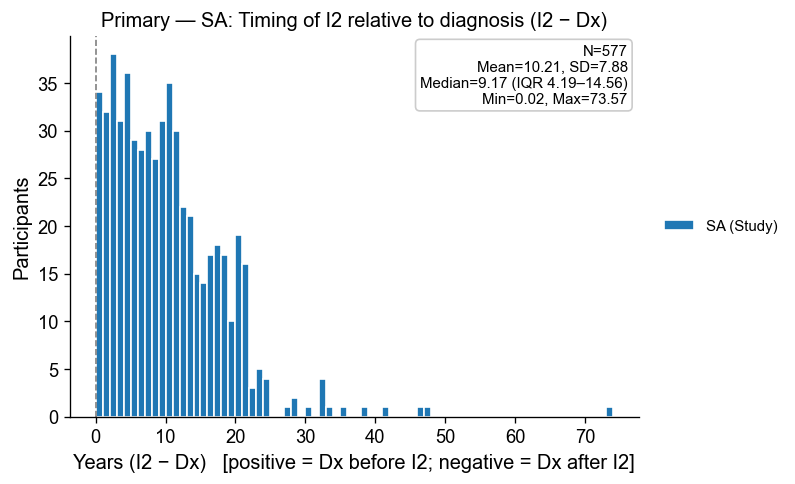

[Sensitivity] SA I2−Dx (years): N=597 | mean=10.03, SD=7.84 | median=8.90, IQR=4.02–14.25 | min=0.02, max=73.57 | Dx before I2 (positive): 597, Dx after I2 (negative): 0 | Dx column: Date_G47_first_reported_sleep_disorders


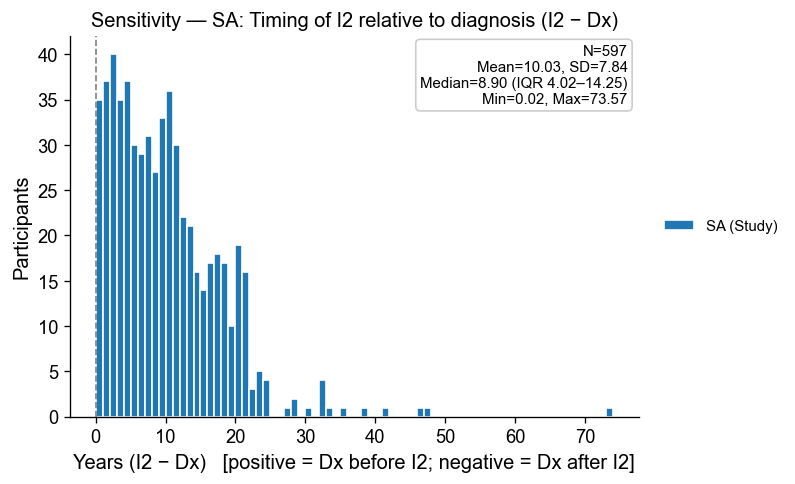

C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:1748: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(csv_path))


[Skip] Primary: missing columns -> ['Date_of_first_sleep_apnoea_diagnosis']
[Skip] Sensitivity: missing columns -> ['Date_of_first_sleep_apnoea_diagnosis']


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\4126260567.py:1859: DtypeWarning: Columns (167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = clean_cols(pd.read_csv(filepath))


[OK] SA Dx-duration (I2−Dx) table saved: Annual_Change\SA_DxDuration_ByIncDec\Primary\Primary_SA_DxDuration_IncDec.csv


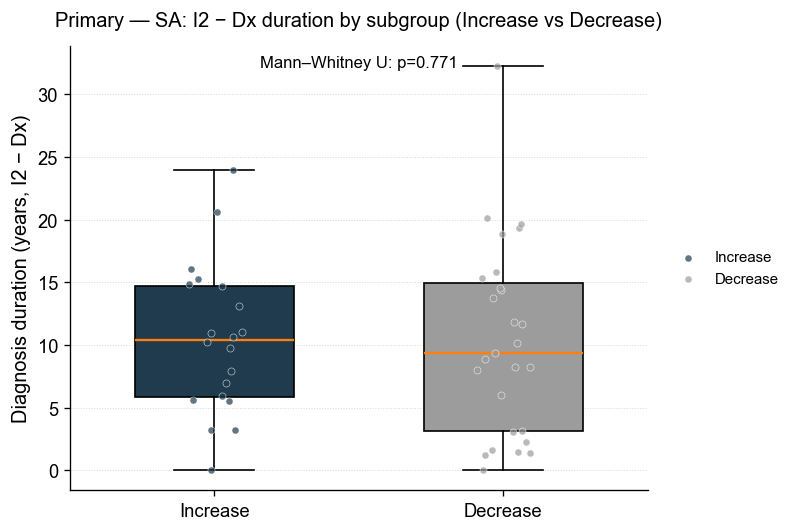

[OK] SA Dx-duration (I2−Dx) table saved: Annual_Change\SA_DxDuration_ByIncDec\Sensitivity\Sensitivity_SA_DxDuration_IncDec.csv


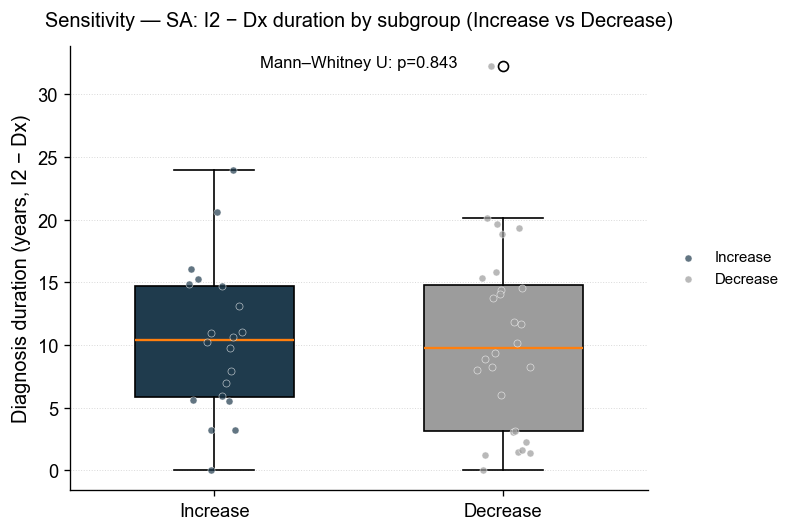

In [ ]:
# Annual WMH Change (I3–I2) · Primary + Sensitivity Cohorts · Final (Revised & FDR Applied)
# Key points of this version:
# - HSN log1p (la table): Benjamini–Hochberg FDR applied only to Periventricular & Deep; 
#   Total is excluded (q=NaN).
# - Inc/Dec (proportion tests): FDR applied only to Periventricular & Deep; 
#   Total excluded and q not displayed in plots.
# - In 2-panel figures and single-region proportion plots, q-values are not shown for Total. 
#   Plotting order: Total → Periventricular → Deep.

import os, re, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# ---------------- Basic Configuration ----------------
COHORTS = {
    "Primary":     "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}
OUTDIR = "Annual_Change"; os.makedirs(OUTDIR, exist_ok=True)

mpl.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 600,
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.autolayout": True
})

# === Publication style & multi-format export (consistent with main analysis) ===
# Fonts & sizes consistent with the main analysis
PUB_RC = {
    "font.family": "Arial",
    "font.size": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "savefig.dpi": 600,
    "figure.autolayout": True,
}

# File export kwargs
SAVEFIG_DPI = 600
PNG_KW  = {"dpi": SAVEFIG_DPI, "bbox_inches": "tight", "facecolor": "white"}
PDF_KW  = {"bbox_inches": "tight"}
SVG_KW  = {"bbox_inches": "tight"}
TIFF_KW = {
    "dpi": SAVEFIG_DPI,
    "bbox_inches": "tight",
    "facecolor": "white",
    "format": "tiff",
    "pil_kwargs": {"compression": "tiff_lzw"}  # lossless compression
}

# Colors / markers consistent with main analysis
COLOR_PRIMARY = "#1f3b4d"  # deep blue
ELW, CAPSIZE, MS = 1.6, 4, 5.5

# Abbreviated y-axis labels (for figures), consistent with main analysis
DISPLAY_LABEL = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
PLOT_ORDER = ["Total", "Periventricular", "Deep"]

def safe_name(s): return re.sub(r"[^0-9A-Za-z._-]+", "_", str(s))

def fmt_p(p):
    try: p = float(p)
    except: return str(p)
    return f"{p:.1e}" if p < 1e-3 else f"{p:.3f}"

def clean_cols(df):
    return df.rename(columns=lambda c: pd.Series(c).str.replace(r"[^0-9a-zA-Z]+", "_", regex=True).iloc[0])

# ---------------- Variable Definitions ----------------
wmh_fields = {
    "Deep": ("Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
             "Total_volume_of_deep_white_matter_hyperintensities_Instance_3"),
    "Periventricular": ("Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
                        "Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_3"),
    "Total": ("Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
              "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_3")
}

# ---------------- Annualized Change Definitions ----------------
def annual_change_raw_ratio(d, f2, f3):
    wm2 = d["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
    wm3 = d["Volume_of_white_matter_Instance_3"].replace(0, np.nan)
    return ((d[f3]/wm3) - (d[f2]/wm2)) / d["Delta_years"], "WMH/WM","raw"

def annual_change_raw_abs_hsn(d, f2, f3):
    v2 = d[f2]*d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
    v3 = d[f3]*d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
    return (v3 - v2) / d["Delta_years"], "HSN","raw"

def annual_change_log1p_ratio(d, f2, f3):
    wm2 = d["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
    wm3 = d["Volume_of_white_matter_Instance_3"].replace(0, np.nan)
    return (np.log1p(d[f3]/wm3) - np.log1p(d[f2]/wm2)) / d["Delta_years"], "WMH/WM","log"

def annual_change_log1p_abs_hsn(d, f2, f3):
    v2 = d[f2]*d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
    v3 = d[f3]*d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
    return (np.log1p(v3) - np.log1p(v2)) / d["Delta_years"], "HSN","log"
# ---------------- Regression and Diagnostics ----------------
def fit_cluster(formula, data, groups):
    # Use cluster-robust SEs if match_id is available and >1 unique cluster;
    # otherwise use HC3 heteroscedasticity-consistent SEs.
    if (groups in data.columns) and (data[groups].dropna().nunique() > 1):
        return smf.ols(formula, data=data).fit(cov_type="cluster", cov_kwds={"groups": data[groups]})
    return smf.ols(formula, data=data).fit(cov_type="HC3")

def diagnostic_compare(d, outcome_raw, outcome_log, rhs_terms, categorical_in):
    """
    Compare raw vs log1p models:
    - Evaluate Breusch–Pagan (heteroscedasticity), Jarque–Bera (normality), and AIC.
    - Recommend log1p if ≥2 criteria favor log1p over raw.
    """
    tmp = d[[outcome_raw, outcome_log, "group", "match_id"] + rhs_terms].dropna().copy()
    if tmp.empty: return None
    rhs = " + ".join([f"C({v})" if v in categorical_in else v for v in rhs_terms]) if rhs_terms else ""
    f_raw = f"{outcome_raw} ~ C(group)" + (f" + {rhs}" if rhs else "")
    f_log  = f"{outcome_log}  ~ C(group)" + (f" + {rhs}" if rhs else "")
    m_raw = fit_cluster(f_raw, tmp, "match_id"); m_log = fit_cluster(f_log, tmp, "match_id")
    bp_raw = het_breuschpagan(m_raw.resid, m_raw.model.exog)[1]; bp_log = het_breuschpagan(m_log.resid, m_log.model.exog)[1]
    jb_raw = jarque_bera(m_raw.resid)[1]; jb_log = jarque_bera(m_log.resid)[1]
    aic_raw, aic_log = m_raw.aic, m_log.aic
    rec = ( (bp_log > bp_raw) + (jb_log > jb_raw) + (aic_log < aic_raw - 2) ) >= 2
    return {"n": len(tmp), "BP_p_raw": float(bp_raw), "BP_p_log": float(bp_log),
            "JB_p_raw": float(jb_raw), "JB_p_log": float(jb_log),
            "AIC_raw": float(aic_raw), "AIC_log": float(aic_log),
            "Recommend_log1p": bool(rec)}

def run_models(df, covars_in, categorical_in, change_kind="raw_abs",
               baseline_adjust=False, return_models=False):
    """
    Run OLS models for all WMH regions.
    Parameters:
      - change_kind: raw_abs, raw_ratio, log_abs, or log_ratio
      - baseline_adjust: if True, add baseline covariate at Instance 2
      - return_models: if True, return fitted model objects for diagnostics
    """
    rows = []
    fits = {}
    for region, (f2, f3) in wmh_fields.items():
        d = df.copy()
        # outcome construction
        if change_kind == "raw_ratio":
            y, scale, scl = annual_change_raw_ratio(d, f2, f3)
        elif change_kind == "raw_abs":
            y, scale, scl = annual_change_raw_abs_hsn(d, f2, f3)
        elif change_kind == "log_ratio":
            y, scale, scl = annual_change_log1p_ratio(d, f2, f3)
        else:
            y, scale, scl = annual_change_log1p_abs_hsn(d, f2, f3)

        d = d.assign(Annual_Change=y).dropna(subset=["Annual_Change", "match_id", "group"]).copy()

        rhs_terms = list(covars_in)
        if baseline_adjust:
            d["Baseline_cov"] = _baseline_column(d, change_kind, f2)
            rhs_terms = ["Baseline_cov"] + rhs_terms
        rhs = " + ".join([f"C({c})" if c in categorical_in else c for c in rhs_terms]) if rhs_terms else ""
        formula = "Annual_Change ~ C(group)" + (f" + {rhs}" if rhs else "")
        fit = fit_cluster(formula, d, "match_id")
        if return_models:
            fits[region] = fit

        key = "C(group)[T.Study]"
        beta = ci_l = ci_u = pval = np.nan
        if key in fit.params.index:
            beta = float(fit.params[key]); ci_l, ci_u = [float(x) for x in fit.conf_int().loc[key]]
            pval = float(fit.pvalues[key])

        pct = pct_l = pct_u = np.nan
        if scl == "log" and np.isfinite(beta):
            pct, pct_l, pct_u = 100*(np.exp(beta)-1), 100*(np.exp(ci_l)-1), 100*(np.exp(ci_u)-1)

        outcome = f"{region} · {scale}" + ("" if scl=="raw" else " (%/yr)")
        rows.append({
            "Outcome": outcome, "β": beta, "95% CI Low": ci_l, "95% CI High": ci_u, "p": pval,
            "%/year": pct, "%/year CI Low": pct_l, "%/year CI High": pct_u,
            "N Study": int(d.loc[d.group=='Study','Participant_ID'].nunique()),
            "N Control": int(d.loc[d.group=='Control','Participant_ID'].nunique())
        })

    res = pd.DataFrame(rows)
    if return_models:
        return res, fits
    return res


def inc_dec_tests(df, use_ratio=True):
    """
    Test whether the proportion of participants with increased vs decreased WMH differs between groups.
    Parameters:
      - use_ratio: if True, WMH/WM ratio; else HSN absolute volume.
    Returns:
      DataFrame with counts, percentages, test statistics, and p-values.
    """
    rows=[]
    for region,(f2,f3) in wmh_fields.items():
        d=df.copy()
        y,_scale,_= annual_change_raw_ratio(d,f2,f3) if use_ratio else annual_change_raw_abs_hsn(d,f2,f3)
        d=d.assign(Annual_Change=y).dropna(subset=["Annual_Change","group"])
        d["Increased"]=(d["Annual_Change"]>0).astype(int)
        inc_s=int(d.loc[d.group=="Study","Increased"].sum()); inc_c=int(d.loc[d.group=="Control","Increased"].sum())
        n_s=int((d.group=="Study").sum()); n_c=int((d.group=="Control").sum())
        dec_s,dec_c=n_s-inc_s,n_c-inc_c
        table=np.array([[inc_s,dec_s],[inc_c,dec_c]],dtype=int)
        if (table<5).any():
            test="Fisher exact"; _,p_primary=stats.fisher_exact(table)
        else:
            test="Chi-square (Yates)"; _,p_primary,_,_=stats.chi2_contingency(table,correction=True)
        prop_s=inc_s/n_s if n_s>0 else np.nan; prop_c=inc_c/n_c if n_c>0 else np.nan
        ci_l,ci_h=confint_proportions_2indep(inc_s,n_s,inc_c,n_c,method="newcomb")
        _,p_prop=proportions_ztest([inc_s,inc_c],[n_s,n_c])
        rows.append({"Outcome": region, "Study Increase":inc_s,"Study Decrease":dec_s,"Study N":n_s,
                     "Control Increase":inc_c,"Control Decrease":dec_c,"Control N":n_c,
                     "Increase % (Study)":100*prop_s if n_s>0 else np.nan,
                     "Increase % (Control)":100*prop_c if n_c>0 else np.nan,
                     "Prop Diff (S-C)": (prop_s-prop_c) if (n_s>0 and n_c>0) else np.nan,
                     "95% CI Low":ci_l, "95% CI High":ci_h, "Test":test,
                     "p_primary":p_primary, "p_prop_z":float(p_prop)})
    return pd.DataFrame(rows)

# —— Format p/q text (numbers only; stars added separately) ——
def _format_pq(p, q=None):
    def fnum(x, prefix):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return None
        return f"{prefix}<0.001" if x < 0.001 else f"{prefix}={x:.3f}"
    p_txt = fnum(p, "p")
    q_txt = fnum(q, "q") if q is not None else None
    if p_txt and q_txt: return f"{p_txt}, {q_txt}"
    if p_txt: return p_txt
    if q_txt: return q_txt
    return None

def _stars_by_p(p):
    try:
        p = float(p)
    except:
        return ""
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

# —— Add bracket with label text above two bars ——
def _add_pq_bracket(ax, x_left, x_right, y_base, label_txt, barw=0.52, fontsize=8, dy=0.8):
    if not label_txt:
        return
    dx = barw * 0.60
    y_top = y_base + 1.0
    ax.plot([x_left - dx, x_left - dx, x_right + dx, x_right + dx],
            [y_base, y_top, y_top, y_base],
            color="black", lw=0.9, zorder=5)
    ax.text((x_left + x_right) / 2.0, y_top + dy, label_txt,
            ha="center", va="bottom", fontsize=fontsize, fontstyle="italic",
            color="black", zorder=6)

# ===== Baseline helper: build baseline covariate matched to change_kind =====
def _baseline_column(df, change_kind, f2):
    """
    Return the baseline covariate for the given change_kind.
    - For HSN raw_abs: baseline = HSN at Instance 2
    - For HSN log_abs: baseline = log1p(HSN at Instance 2)
    - For ratio raw_ratio: baseline = WMH/WM at Instance 2
    - For ratio log_ratio: baseline = log1p(WMH/WM at Instance 2)
    """
    if change_kind in ("raw_abs", "log_abs"):
        base = df[f2] * df["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
        if change_kind == "log_abs":
            base = np.log1p(base)
        return pd.to_numeric(base, errors="coerce")
    else:  # ratio kinds
        wm2 = df["Volume_of_white_matter_Instance_2"].replace(0, np.nan)
        base = pd.to_numeric(df[f2], errors="coerce") / wm2
        if change_kind == "log_ratio":
            base = np.log1p(base)
        return pd.to_numeric(base, errors="coerce")

# ===== Plot diagnostics for a fitted model =====
def plot_model_diagnostics(fit, out_base):
    """
    Save three diagnostic plots for OLS residuals:
      - Residuals vs fitted values
      - Normal Q–Q plot
      - Histogram of standardized residuals
    Outputs: PNG/PDF/SVG/TIFF (600 dpi, LZW compression)
    """
    if fit is None:
        return
    # --- Residuals vs Fitted ---
    fig, ax = plt.subplots(figsize=(6.4, 4.0))
    ax.scatter(fit.fittedvalues, fit.resid, s=14, alpha=0.75, edgecolors="none")
    ax.axhline(0, color="grey", ls="--", lw=1)
    ax.set_xlabel("Fitted values"); ax.set_ylabel("Residuals")
    ax.set_title("Residuals vs Fitted")
    ax.grid(False); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_resid_vs_fitted.png", **PNG_KW)
    plt.savefig(out_base + "_resid_vs_fitted.pdf", **PDF_KW)
    plt.savefig(out_base + "_resid_vs_fitted.svg", **SVG_KW)
    plt.savefig(out_base + "_resid_vs_fitted.tiff", **TIFF_KW)
    plt.close()

    # --- QQ plot ---
    fig = plt.figure(figsize=(6.0, 6.0))
    ax = fig.add_subplot(111)
    sm.ProbPlot(fit.resid).qqplot(line="s", ax=ax)
    ax.set_title("Normal Q–Q")
    ax.grid(False); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_qq.png", **PNG_KW)
    plt.savefig(out_base + "_qq.pdf", **PDF_KW)
    plt.savefig(out_base + "_qq.svg", **SVG_KW)
    plt.savefig(out_base + "_qq.tiff", **TIFF_KW)
    plt.close()

    # --- Histogram of standardized residuals ---
    fig, ax = plt.subplots(figsize=(6.4, 4.0))
    try:
        infl = fit.get_influence()
        zresid = infl.resid_studentized_internal
    except Exception:
        zresid = (fit.resid - np.nanmean(fit.resid)) / np.nanstd(fit.resid)
    ax.hist(zresid, bins=30, edgecolor="white")
    ax.set_xlabel("Standardized residuals"); ax.set_ylabel("Count")
    ax.set_title("Histogram of standardized residuals")
    ax.grid(False); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(out_base + "_hist_stdresid.png", **PNG_KW)
    plt.savefig(out_base + "_hist_stdresid.pdf", **PDF_KW)
    plt.savefig(out_base + "_hist_stdresid.svg", **SVG_KW)
    plt.savefig(out_base + "_hist_stdresid.tiff", **TIFF_KW)
    plt.close()

# ===== Methods record writer =====
def write_methods_record(outdir):
    """
    Write a plain-text methods description for longitudinal analyses (publication-ready).
    Content includes:
      - Outcomes
      - Primary and sensitivity model specifications
      - Multiple testing adjustment strategy
      - Figure export specifications
    """
    txt = []
    txt.append("Longitudinal WMH change (Instance 3 − Instance 2)")
    txt.append("")
    txt.append("Outcomes:")
    txt.append("- HSN absolute change per year (raw and log1p back-transform to %/year).")
    txt.append("- WMH/WM ratio change per year (raw and log1p back-transform to %/year).")
    txt.append("")
    txt.append("Primary model: OLS with Study vs Control indicator; covariates:")
    txt.append("- Age at Instance 2, Sex, BMI at Instance 0, Genetic ethnic grouping, Smoking (ever),")
    txt.append("  Alcohol intake frequency (ordinal), Townsend deprivation index at recruitment.")
    txt.append("SE: Cluster-robust by matched set (match_id) if available; otherwise HC3.")
    txt.append("")
    txt.append("Sensitivity model: Adds the appropriate baseline value (at Instance 2) as a covariate:")
    txt.append("- For HSN raw_abs: baseline = HSN at Instance 2.")
    txt.append("- For HSN log_abs: baseline = log1p(HSN at Instance 2).")
    txt.append("- For ratio raw_ratio: baseline = (WMH/WM) at Instance 2.")
    txt.append("- For ratio log_ratio: baseline = log1p(WMH/WM at Instance 2).")
    txt.append("")
    txt.append("Multiple testing:")
    txt.append("- For longitudinal HSN log1p models (Periventricular, Deep), Benjamini–Hochberg FDR.")
    txt.append("- Total is primary endpoint and is excluded from FDR (q=NaN).")
    txt.append("- Increase/Decrease tests: only Periventricular & Deep included in FDR families.")
    txt.append("")
    txt.append("Figures:")
    txt.append("- Forest plots match main-analysis style (deep blue markers, Arial, no grid, 600 dpi).")
    txt.append("- All figures exported as PNG/PDF/SVG and 600 dpi TIFF (LZW).")
    path = os.path.join(outdir, "METHODS_Longitudinal.txt")
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(txt))
    return path


# ---------------- Forest Plotting (titles exclude cohort names) ----------------
def forest(df_plot, ttl, outpath, logscale=False):
    plt.rcParams.update(PUB_RC) 
    """
    Publication-styled forest plot consistent with the main analysis:
      - Deep-blue filled markers and error bars
      - No grid; top/right spines removed
      - Arial fonts; sizes consistent with main figures
      - Outcome order: Total → Periventricular → Deep
      - Y-axis uses abbreviated labels (Total WMH / PWMH / DWMH)
      - Export formats: PNG/PDF/SVG + 600 dpi TIFF (LZW compression)
    """
    if df_plot is None or df_plot.empty:
        return

    # Apply global publication rcParams
    plt.rcParams.update(PUB_RC)

    # --- Prepare data & order ---
    dfp = df_plot.copy()
    # "Outcome" field in longitudinal tables has format like "Periventricular · HSN (%/yr)"
    # Only use the region name (left of "·") for sorting and labeling
    region = dfp["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
    dfp["Region"] = region

    # Keep only desired regions and apply canonical order
    order_map = {v: i for i, v in enumerate(PLOT_ORDER)}
    dfp = dfp[dfp["Region"].isin(PLOT_ORDER)].copy()
    if dfp.empty:
        return
    dfp["Region"] = pd.Categorical(dfp["Region"], categories=PLOT_ORDER, ordered=True)
    dfp = dfp.sort_values("Region").reset_index(drop=True)

    # Select data: if logscale → use %/year; else use β
    if logscale:
        x  = pd.to_numeric(dfp["%/year"], errors="coerce").to_numpy()
        xl = pd.to_numeric(dfp["%/year CI Low"], errors="coerce").to_numpy()
        xu = pd.to_numeric(dfp["%/year CI High"], errors="coerce").to_numpy()
        xlabel = "Annualized % change (SA − Control)"
    else:
        x  = pd.to_numeric(dfp["β"], errors="coerce").to_numpy()
        xl = pd.to_numeric(dfp["95% CI Low"], errors="coerce").to_numpy()
        xu = pd.to_numeric(dfp["95% CI High"], errors="coerce").to_numpy()
        xlabel = "Annualized change (β ± 95% CI)"

    n = len(dfp)
    y = np.arange(n)[::-1]  # Top = Total
    fig_h = max(3.6, 0.85 * n)  # dynamic height

    fig = plt.figure(figsize=(6.8, fig_h))
    ax = plt.gca()

    # Error bars (deep blue)
    ax.errorbar(
        x, y,
        xerr=[x - xl, xu - x],
        fmt="o", ms=MS, mfc=COLOR_PRIMARY, mec=COLOR_PRIMARY,
        ecolor=COLOR_PRIMARY, elinewidth=ELW, capsize=CAPSIZE,
        linestyle="none", zorder=3
    )

    # Cosmetics: zero line, no grid, top/right spines removed
    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Y labels: abbreviated (match main analysis)
    ylab = [DISPLAY_LABEL.get(r, r) for r in dfp["Region"].astype(str).tolist()]
    ax.set_yticks(y)
    ax.set_yticklabels(ylab)

    # X limits with padding based on CIs
    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else 1.0
    span = xmax - xmin if (xmax - xmin) > 0 else 1.0
    pad_left, pad_right = 0.08 * span, 0.30 * span
    ax.set_xlim(xmin - pad_left, xmax + pad_right)

    ax.set_xlabel(xlabel)
    ax.set_title(ttl)
    plt.tight_layout()

    # --- Export in all formats ---
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    base, _ = os.path.splitext(outpath)
    plt.savefig(base + ".png",  **PNG_KW)
    plt.savefig(base + ".pdf",  **PDF_KW)
    plt.savefig(base + ".svg",  **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)

# ================== Single-region plots (for Supplementary Material) ==================
def plot_inc_dec_paper(tests_table, ttl, outdir):
    plt.rcParams.update(PUB_RC) 
    """
    Plot single-region increase/decrease proportions by group (publication-ready).
    Parameters:
      - tests_table: output from inc_dec_tests()
      - ttl: "HSN" or "WMH/WM", shown in figure title
      - outdir: output directory
    Notes:
      - For Periventricular and Deep, q-values are displayed if available.
      - For Total, q-values are forcibly suppressed (q=None).
    """
    if tests_table.empty:
        return
    os.makedirs(outdir, exist_ok=True)
    OI_INCREASE = "#D55E00"; OI_DECREASE = "#009E73"

    for region in tests_table["Outcome"].unique():
        t = tests_table[tests_table["Outcome"] == region].iloc[0]
        inc_c, dec_c, n_c = float(t["Control Increase"]), float(t["Control Decrease"]), float(t["Control N"])
        inc_s, dec_s, n_s = float(t["Study Increase"]),   float(t["Study Decrease"]),   float(t["Study N"])
        inc_pct_c = 100 * inc_c / n_c if n_c > 0 else np.nan
        inc_pct_s = 100 * inc_s / n_s if n_s > 0 else np.nan
        dec_pct_c = 100 - inc_pct_c if not np.isnan(inc_pct_c) else np.nan
        dec_pct_s = 100 - inc_pct_s if not np.isnan(inc_pct_s) else np.nan
        p_main = float(t["p_primary"]) if pd.notna(t["p_primary"]) else np.nan

        # Show q only for Periventricular & Deep; suppress for Total
        q_main = None
        if region in ("Periventricular", "Deep") and ("q_FDR_incdec_combined" in t.index) and pd.notna(t["q_FDR_incdec_combined"]):
            q_main = float(t["q_FDR_incdec_combined"])

        fig, ax = plt.subplots(figsize=(6.2, 4.3))
        x = np.array([0, 1], dtype=float); barw = 0.52
        ax.bar(x, [inc_pct_c, inc_pct_s], width=barw, color=OI_INCREASE, edgecolor="black", linewidth=0.8, label="Increase", zorder=3)
        ax.bar(x, [dec_pct_c, dec_pct_s], width=barw, bottom=[inc_pct_c, inc_pct_s], color=OI_DECREASE, edgecolor="black", linewidth=0.8, label="Decrease", zorder=3)

        ax.set_xticks(x); ax.set_xticklabels(["Control", "Study"])
        ax.set_ylabel("Participants (%)")
        ax.set_ylim(0, 104); ax.set_yticks([0, 25, 50, 75, 100])

        # Title includes HSN or WMH/WM
        ax.set_title(f"{region} {ttl} — Increase vs Decrease by Group", pad=16)

        ax.grid(axis="y", linestyle=":", alpha=0.45); ax.set_axisbelow(True)
        ax.margins(x=0.18); ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

        # Percentages inside bars
        for i, ip in enumerate([inc_pct_c, inc_pct_s]):
            if not np.isnan(ip):
                ax.text(x[i], ip * 0.50, f"{ip:.1f}%", ha="center", va="center", fontsize=9, color="white")
        for i, (ip, dp) in enumerate([(inc_pct_c, dec_pct_c), (inc_pct_s, dec_pct_s)]):
            if not np.isnan(dp):
                ax.text(x[i], ip + dp * 0.50, f"{dp:.1f}%", ha="center", va="center", fontsize=9, color="white")

        # Add p / q (for Peri/Deep only)
        pq_txt_base = _format_pq(p_main, q_main); stars = _stars_by_p(p_main)
        label_txt = f"{stars} {pq_txt_base}" if stars and pq_txt_base else (stars or pq_txt_base)
        if label_txt:
            _add_pq_bracket(ax, x_left=x[0], x_right=x[1], y_base=101.0, label_txt=label_txt, barw=barw, fontsize=9, dy=0.4)

        ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
        plt.subplots_adjust(left=0.10, right=0.76, bottom=0.14, top=0.88)
        fname = f"{safe_name(region)}_IncDec_{safe_name(ttl)}_Paper.png"
        base = os.path.join(outdir, os.path.splitext(fname)[0])
        plt.savefig(base + ".png",  **PNG_KW)
        plt.savefig(base + ".pdf",  **PDF_KW)
        plt.savefig(base + ".svg",  **SVG_KW)
        plt.savefig(base + ".tiff", **TIFF_KW)
        plt.close()


# ================== Figure X (2-panel: A Forest + B Proportion, HSN) ==================
def plot_figureX_hsn(la_table: pd.DataFrame,
                     incdec_hsn: pd.DataFrame,
                     outdir: str,
                     filename: str = "FigureX_Longitudinal_WMH.png"):
    """
    Two-panel longitudinal figure (no explicit panel titles):
      Panel A: Forest plot of annualized % difference (SA − Control) for HSN log1p.
      Panel B: 100% stacked bars (Increase vs Decrease) by group.

    Style:
      • Fonts/sizes follow PUB_RC
      • Significant = deep blue (#1f3b4d), Non-significant = gray (#7f7f7f)
      • Left y-axis labels (fixed order): Total WMH / PWMH / DWMH
      • Right panel: Increase = blue, Decrease = gray, light borders
      • Export formats: PNG/PDF/SVG + 600 dpi TIFF (LZW)
    """
    plt.rcParams.update(PUB_RC)

    if la_table is None or la_table.empty or incdec_hsn is None or incdec_hsn.empty:
        return
    os.makedirs(outdir, exist_ok=True)

    # ---------------- Panel A data prep ----------------
    region_order_raw = ["Total", "Periventricular", "Deep"]  # Fixed display order
    wanted = [f"{lab} · HSN (%/yr)" for lab in region_order_raw]

    la = la_table.copy()
    la = la[la["Outcome"].isin(wanted)].copy()
    if la.empty:
        return
    la["Outcome"] = pd.Categorical(la["Outcome"], categories=wanted, ordered=True)
    la = la.sort_values("Outcome").reset_index(drop=True)

    # Left-axis labels
    region_map = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
    la["Region"] = la["Outcome"].str.split("·", n=1, expand=True)[0].str.strip()
    y_labels_left = [region_map.get(r, r) for r in la["Region"].tolist()]

    # Effect estimates and CIs
    x  = pd.to_numeric(la["%/year"], errors="coerce").to_numpy()
    xl = pd.to_numeric(la["%/year CI Low"], errors="coerce").to_numpy()
    xu = pd.to_numeric(la["%/year CI High"], errors="coerce").to_numpy()

    # Significance: prefer FDR q-values; fallback to raw p
    def _pick_q(row):
        if "q_FDR_primary" in row and pd.notna(row["q_FDR_primary"]):
            return float(row["q_FDR_primary"])
        if "q_FDR_sensitivity" in row and pd.notna(row["q_FDR_sensitivity"]):
            return float(row["q_FDR_sensitivity"])
        return np.nan

    qvals = la.apply(_pick_q, axis=1).to_numpy()
    pvals = pd.to_numeric(la.get("p", np.nan), errors="coerce").to_numpy()
    sig_mask = np.where(np.isfinite(qvals), (qvals <= 0.05), (pvals <= 0.05))

    COLOR_PRIMARY = globals().get("COLOR_PRIMARY", "#152d3b")
    COLOR_NONSIG  = "#7f7f7f"
    point_colors  = np.where(sig_mask, COLOR_PRIMARY, COLOR_NONSIG)

    # ---------------- Panel B data prep ----------------
    t = incdec_hsn.copy()
    t = t[t["Outcome"].isin(region_order_raw)].copy()
    rows = []
    for rg in region_order_raw:
        r = t[t["Outcome"] == rg]
        if r.empty:
            continue
        r = r.iloc[0]
        n_c = float(r["Control N"]); n_s = float(r["Study N"])
        inc_c = 100.0 * float(r["Control Increase"]) / n_c if n_c > 0 else np.nan
        inc_s = 100.0 * float(r["Study Increase"])   / n_s if n_s > 0 else np.nan
        dec_c = 100.0 - inc_c if not np.isnan(inc_c) else np.nan
        dec_s = 100.0 - inc_s if not np.isnan(inc_s) else np.nan

        # Display q-values only for Peri/Deep
        q_show = None
        if (rg in ("Periventricular", "Deep")) and ("q_FDR_incdec_combined" in r.index) and pd.notna(r["q_FDR_incdec_combined"]):
            q_show = float(r["q_FDR_incdec_combined"])

        rows.append({
            "Region": region_map.get(rg, rg),
            "inc_c": inc_c, "dec_c": dec_c,
            "inc_s": inc_s, "dec_s": dec_s,
            "p": float(r["p_primary"]) if pd.notna(r["p_primary"]) else np.nan,
            "q": q_show
        })
    if not rows:
        return
    dfB = pd.DataFrame(rows)

    # ---------------- Figure canvas ----------------
    fig = plt.figure(figsize=(11.6, 4.0))
    gs  = fig.add_gridspec(1, 2, width_ratios=[1.5, 1.45], wspace=0.30)

    # ---------------- Panel A: Forest ----------------
    axA = fig.add_subplot(gs[0, 0])
    y = np.linspace(0, len(la)-1, len(la)) * 0.7
    y = y[::-1]  # Top = Total
    ypad = 0.35
    axA.set_ylim(-ypad, y.max() + ypad)

    for i in range(len(y)):
        if any(np.isnan([x[i], xl[i], xu[i]])):
            continue
        axA.errorbar(
            x[i], y[i],
            xerr=[[x[i] - xl[i]], [xu[i] - x[i]]],
            fmt="o", ms=globals().get("MS", 5.5),
            mfc=point_colors[i], mec=point_colors[i],
            ecolor=point_colors[i], elinewidth=globals().get("ELW", 1.6),
            capsize=globals().get("CAPSIZE", 4),
            linestyle="none", zorder=3
        )

    axA.axvline(0, color="grey", linestyle="--", linewidth=1)
    axA.grid(False); axA.spines["top"].set_visible(False); axA.spines["right"].set_visible(False)
    axA.set_yticks(y); axA.set_yticklabels(y_labels_left)

    xmin = np.nanmin(xl) if np.isfinite(np.nanmin(xl)) else -1.0
    xmax = np.nanmax(xu) if np.isfinite(np.nanmax(xu)) else  1.0
    span = xmax - xmin if (xmax - xmin) > 0 else 1.0
    axA.set_xlim(xmin - 0.08 * span, xmax + 0.15 * span)

    axA.set_xlabel("Annualized % change (SA − Control)")

    # Annotate significant points
    for i in range(len(y)):
        if not sig_mask[i] or any(np.isnan([x[i], xl[i], xu[i]])):
            continue
        axA.text(x[i] + 0.02 * span, y[i],
                 f"{x[i]:.1f}%/yr",
                 va="center", ha="left", fontsize=11, color=COLOR_PRIMARY)

        # ---------------- Panel B: 100% stacked bars ----------------
    axB = fig.add_subplot(gs[0, 1])

    COL_INC = COLOR_PRIMARY
    COL_DEC = "#9c9c9c"
    edge_lw = 0.8

    centers = np.arange(len(dfB)) * 2.0  # one pair (Control, Study) per region
    barw    = 0.48

    for i, r in dfB.iterrows():
        xc, xs = centers[i] - 0.36, centers[i] + 0.36  # Control left, Study right

        # --- Stacked bars ---
        axB.bar(xc, r["inc_c"], width=barw, color=COL_INC, edgecolor=COL_INC, linewidth=edge_lw, zorder=3)
        axB.bar(xc, r["dec_c"], width=barw, bottom=r["inc_c"], color=COL_DEC, edgecolor=COL_DEC, linewidth=edge_lw, zorder=3)
        axB.bar(xs, r["inc_s"], width=barw, color=COL_INC, edgecolor=COL_INC, linewidth=edge_lw, zorder=3)
        axB.bar(xs, r["dec_s"], width=barw, bottom=r["inc_s"], color=COL_DEC, edgecolor=COL_DEC, linewidth=edge_lw, zorder=3)

        # --- Bracket for significance (stars only, no p/q text) ---
        stars = "***" if r["p"] < 0.001 else ("**" if r["p"] < 0.01 else ("*" if r["p"] < 0.05 else ""))
        label_txt = stars  

        from numpy import nansum
        y_base = max(nansum([r["inc_c"], r["dec_c"]]), nansum([r["inc_s"], r["dec_s"]])) + 2.0
        if label_txt:
            _add_pq_bracket(axB, x_left=xc, x_right=xs, y_base=y_base,
                            label_txt=label_txt, barw=barw, fontsize=11, dy=0.6)

    # Double-layer x-axis labels: bottom row = Control/Study, second row = Region
    tick_positions = []
    tick_labels = []
    for i, region in enumerate(dfB["Region"]):
        xc, xs = centers[i] - 0.36, centers[i] + 0.36
        tick_positions.extend([xc, xs])
        tick_labels.extend(["CO", "SA"])
        axB.text(centers[i], -10.5, region, ha="center", va="top", fontsize=11)

    axB.set_xticks(tick_positions)
    axB.set_xticklabels(tick_labels, fontsize=9)
    plt.subplots_adjust(bottom=0.18)

    axB.set_ylim(0, 115)
    axB.set_ylabel("Participants (%)")
    axB.grid(axis="y", linestyle=":", alpha=0.45)
    axB.set_axisbelow(True)
    axB.spines["top"].set_visible(False)
    axB.spines["right"].set_visible(False)

    # Legend
    legend_items = [
        mpl.patches.Patch(facecolor=COL_INC, edgecolor=COL_INC, label="Increase"),
        mpl.patches.Patch(facecolor=COL_DEC, edgecolor=COL_DEC, label="Decrease"),
    ]
    axB.legend(handles=legend_items, loc="center left", bbox_to_anchor=(1.02, 0.5),
               frameon=False, handlelength=1.4, ncol=1, columnspacing=1.5)

    axB.set_xlim(min(tick_positions) - 1.0, max(tick_positions) + 1.0)

    # ---------------- Panel letters (draw once) ----------------
    boxA = axA.get_position()
    fig.text(boxA.x0 - 0.07, boxA.y1 + 0.005, "A", fontsize=18, fontweight="bold")
    boxB = axB.get_position()
    fig.text(boxB.x0 - 0.09, boxB.y1 + 0.005, "B", fontsize=18, fontweight="bold")

    plt.subplots_adjust(left=0.18, right=0.80, bottom=0.12, top=0.94)

    # Export
    outpath = os.path.join(outdir, filename)
    base, _ = os.path.splitext(outpath)
    plt.savefig(base + ".png",  **PNG_KW)
    plt.savefig(base + ".pdf",  **PDF_KW)
    plt.savefig(base + ".svg",  **SVG_KW)
    plt.savefig(base + ".tiff", **TIFF_KW)
    plt.close(fig)


# ---------------- Follow-up duration summary (publication-ready narrative) ----------------
def _summarize_series_years(s: pd.Series):
    """
    Summarize follow-up years:
      - N, Mean±SD
      - Median, IQR
      - Min, Max
    """
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(N=0, Mean=np.nan, SD=np.nan, Median=np.nan, Q1=np.nan, Q3=np.nan, IQR=np.nan, Min=np.nan, Max=np.nan)
    mean = float(s.mean()); sd = float(s.std(ddof=1))
    q1 = float(s.quantile(0.25)); q3 = float(s.quantile(0.75))
    return dict(N=int(s.size), Mean=mean, SD=sd, Median=float(s.median()),
                Q1=q1, Q3=q3, IQR=q3-q1, Min=float(s.min()), Max=float(s.max()))

def write_followup_summary(df: pd.DataFrame, label: str, subdir: str):
    """
    Export both CSV summary and narrative (EN + CN).
    - CSV: FollowUp_Duration.csv
    - TXT: FollowUp_Duration_narrative.txt
    """
    os.makedirs(subdir, exist_ok=True)
    rows = []
    parts = [("Overall", df), ("Control", df[df["group"]=="Control"]), ("Study", df[df["group"]=="Study"])]
    for gname, gdf in parts:
        stats_row = _summarize_series_years(gdf["Delta_years"])
        rows.append({"Cohort": label, "Group": gname, **stats_row})
    tab = pd.DataFrame(rows); out_csv = os.path.join(subdir, "FollowUp_Duration.csv")
    tab.to_csv(out_csv, index=False, encoding="utf-8-sig")

    def fmt(x): 
        return "NA" if (x is None or (isinstance(x, float) and (np.isnan(x)))) else f"{x:.2f}"
    def sentence(row, lang="en"):
        n = row["N"]; mean, sd = fmt(row["Mean"]), fmt(row["SD"])
        med, q1, q3 = fmt(row["Median"]), fmt(row["Q1"]), fmt(row["Q3"])
        mn, mx = fmt(row["Min"]), fmt(row["Max"]); grp = row["Group"]
        if lang == "en":
            return (f"{label} — {grp}: follow-up from Instance 2 to Instance 3 was "
                    f"median {med} years (IQR {q1}–{q3}), mean {mean}±{sd} years; range {mn}–{mx}; N={n}.")
        else:
            return (f"{label} — {grp}：I2 至 I3 的随访时长为中位数 {med} 年（四分位距 {q1}–{q3}），"
                    f"均值 {mean}±{sd} 年；范围 {mn}–{mx}；样本量 N={n}。")
    lines_en = [sentence(r, "en") for _, r in tab.iterrows()]
    lines_zh = [sentence(r, "zh") for _, r in tab.iterrows()]
    txt = "\n".join(lines_en + [""] + lines_zh)
    out_txt = os.path.join(subdir, "FollowUp_Duration_narrative.txt")
    with open(out_txt, "w", encoding="utf-8") as f: f.write(txt)


# ---------------- Pipeline for one cohort ----------------
def run_for_one_cohort(label, filepath):
    """
    Full longitudinal analysis pipeline (I3–I2):
      - Compute annualized changes (raw & log1p; HSN & ratio)
      - Primary models + baseline-adjusted sensitivity models
      - Diagnostics (raw vs log1p)
      - Forest plots (multi-format)
      - Increase/Decrease tests + single-region plots
      - Within-group Wilcoxon
      - Follow-up duration summary
      - Methods record (TXT)
    """
    print(f"\n===== {label} =====")
    subdir = os.path.join(OUTDIR, label)
    os.makedirs(subdir, exist_ok=True)

    # ---------- Input & preprocessing ----------
    df = clean_cols(pd.read_csv(filepath))
    # Compute follow-up time in years
    df["Delta_years"] = (
        pd.to_datetime(df["Date_of_attending_assessment_centre_Instance_3"])
        - pd.to_datetime(df["Date_of_attending_assessment_centre_Instance_2"])
    ).dt.days / 365.25
    df = df[(df["Delta_years"] > 0) & (df["Delta_years"] < 8)].copy()

    # Required fields
    needed = [c for p in wmh_fields.values() for c in p] + [
        "Volume_of_white_matter_Instance_2", "Volume_of_white_matter_Instance_3",
        "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2",
        "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3",
        "Participant_ID", "match_id", "group", "Delta_years"
    ]
    df = df.dropna(subset=[c for c in needed if c in df]).copy()
    df["group"] = pd.Categorical(df["group"], ["Control", "Study"])

    # ---------- Covariates ----------
    covars = [
        "Age_at_Instance_2", "Sex", "Body_mass_index_BMI_Instance_0",
        "Genetic_ethnic_grouping", "Smoking_Ever",
        "Alcohol_intake_frequency_ordinal",
        "Townsend_deprivation_index_at_recruitment"
    ]
    categorical_all = {"Sex", "Genetic_ethnic_grouping", "Smoking_Ever"}
    covars_in = [v for v in covars if v in df.columns]
    categorical_in = [v for v in covars_in if v in categorical_all]

    # Simple imputation (consistent with main analysis)
    for v in covars_in:
        if pd.api.types.is_numeric_dtype(df[v]):
            df[v] = pd.to_numeric(df[v], errors="coerce").fillna(df[v].median())
        else:
            m = df[v].mode(dropna=True)
            df[v] = df[v].fillna(m.iloc[0] if not m.empty else df[v])

    # ---------- Diagnostics: raw vs log1p ----------
    diag = []
    for region, (f2, f3) in wmh_fields.items():
        # Absolute HSN
        d_abs = df.copy()
        y1, _, _ = annual_change_raw_abs_hsn(d_abs, f2, f3)
        y2, _, _ = annual_change_log1p_abs_hsn(d_abs, f2, f3)
        d_abs["Y_raw_abs"] = y1; d_abs["Y_log_abs"] = y2
        r = diagnostic_compare(d_abs, "Y_raw_abs", "Y_log_abs", covars_in, categorical_in)
        if r: diag.append({"Outcome": f"{region} · HSN", **r})
        # Ratio WMH/WM
        d_rat = df.copy()
        y1, _, _ = annual_change_raw_ratio(d_rat, f2, f3)
        y2, _, _ = annual_change_log1p_ratio(d_rat, f2, f3)
        d_rat["Y_raw_ratio"] = y1; d_rat["Y_log_ratio"] = y2
        r = diagnostic_compare(d_rat, "Y_raw_ratio", "Y_log_ratio", covars_in, categorical_in)
        if r: diag.append({"Outcome": f"{region} · WMH/WM", **r})
    if diag:
        pd.DataFrame(diag).to_csv(
            os.path.join(subdir, "Diagnostics_raw_vs_log1p.csv"),
            index=False, encoding="utf-8-sig"
        )

    # ---------- Primary models ----------
    rr = run_models(df, covars_in, categorical_in, "raw_ratio")
    ra = run_models(df, covars_in, categorical_in, "raw_abs")
    lr = run_models(df, covars_in, categorical_in, "log_ratio")
    la = run_models(df, covars_in, categorical_in, "log_abs")   # Recommended model (HSN log1p)

    # Apply FDR within each table (for reference only; la is treated separately)
    for tab in [rr, ra, lr]:
        if not tab.empty:
            tab["FDR q"] = multipletests(tab["p"], method="fdr_bh")[1]

    # --- Family-wise FDR: only Periventricular & Deep for la (Total excluded) ---
    la = la.copy()
    la["q_FDR_primary"] = np.nan
    la["q_FDR_sensitivity"] = np.nan
    if not la.empty:
        mask_sec = la["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip().isin(["Periventricular", "Deep"])
        if mask_sec.any():
            qvals = multipletests(la.loc[mask_sec, "p"].values, method="fdr_bh", alpha=0.05)[1]
            if label == "Primary":
                la.loc[mask_sec, "q_FDR_primary"] = qvals
            elif label == "Sensitivity":
                la.loc[mask_sec, "q_FDR_sensitivity"] = qvals

    # ---------- Baseline-adjusted sensitivity models ----------
    def run_models_log_abs_with_baseline(df_in, covars_in, categorical_in):
        rows = []
        for region, (f2, f3) in wmh_fields.items():
            d = df_in.copy()
            y, scale, scl = annual_change_log1p_abs_hsn(d, f2, f3)
            v2 = d[f2] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
            d = d.assign(Annual_Change=y, Baseline_log1p=np.log1p(v2))
            d = d.dropna(subset=["Annual_Change", "Baseline_log1p", "match_id", "group"])
            rhs_terms = [f"C({c})" if c in categorical_in else c for c in covars_in] + ["Baseline_log1p"]
            rhs = " + ".join(rhs_terms)
            fit = fit_cluster(f"Annual_Change ~ C(group) + {rhs}" if rhs else "Annual_Change ~ C(group)", d, "match_id")
            key = "C(group)[T.Study]"
            beta = ci_l = ci_u = pval = np.nan
            if key in fit.params.index:
                beta = float(fit.params[key])
                ci_l, ci_u = [float(x) for x in fit.conf_int().loc[key]]
                pval = float(fit.pvalues[key])
            pct = pct_l = pct_u = np.nan
            if np.isfinite(beta):
                pct, pct_l, pct_u = 100 * (np.exp(beta) - 1), 100 * (np.exp(ci_l) - 1), 100 * (np.exp(ci_u) - 1)
            outcome = f"{region} · HSN (%/yr) — baseline-adjusted"
            rows.append({
                "Outcome": outcome, "β": beta, "95% CI Low": ci_l, "95% CI High": ci_u, "p": pval,
                "%/year": pct, "%/year CI Low": pct_l, "%/year CI High": pct_u,
                "N Study": int(d.loc[d.group == 'Study', 'Participant_ID'].nunique()),
                "N Control": int(d.loc[d.group == 'Control', 'Participant_ID'].nunique())
            })
        return pd.DataFrame(rows)

    la_baseline = run_models_log_abs_with_baseline(df, covars_in, categorical_in)

    # Apply family-wise FDR for baseline-adjusted models
    if not la_baseline.empty:
        la_baseline = la_baseline.copy()
        la_baseline["q_FDR_primary"] = np.nan
        la_baseline["q_FDR_sensitivity"] = np.nan
        mask_sec_b = la_baseline["Outcome"].astype(str).str.startswith(("Periventricular", "Deep"))
        if mask_sec_b.any():
            qvals_b = multipletests(la_baseline.loc[mask_sec_b, "p"].values, method="fdr_bh", alpha=0.05)[1]
            if label == "Primary":
                la_baseline.loc[mask_sec_b, "q_FDR_primary"] = qvals_b
            elif label == "Sensitivity":
                la_baseline.loc[mask_sec_b, "q_FDR_sensitivity"] = qvals_b

    # ---------- Export regression tables ----------
    rr.to_csv(os.path.join(subdir, "WMH_WM_ratio_raw_change.csv"), index=False, encoding="utf-8-sig")
    ra.to_csv(os.path.join(subdir, "WMH_HSN_abs_raw_change.csv"), index=False, encoding="utf-8-sig")
    lr.to_csv(os.path.join(subdir, "WMH_WM_ratio_log1p_pct_change.csv"), index=False, encoding="utf-8-sig")
    la.to_csv(os.path.join(subdir, "WMH_HSN_abs_log1p_pct_change.csv"), index=False, encoding="utf-8-sig")
    if not la_baseline.empty:
        la_baseline.to_csv(os.path.join(subdir, "WMH_HSN_abs_log1p_pct_change_BaselineAdjusted.csv"),
                           index=False, encoding="utf-8-sig")

    # ---------- Forest plots ----------
    forest(rr, "WMH/WM ratio (raw annualized change)", os.path.join(subdir, "Forest_Ratio_Raw.png"), logscale=False)
    forest(ra, "HSN-WMH (raw annualized change)",      os.path.join(subdir, "Forest_HSN_Raw.png"),   logscale=False)
    forest(lr, "WMH/WM ratio (annualized % change)",   os.path.join(subdir, "Forest_Ratio_LogPct.png"), logscale=True)
    forest(la, "HSN-WMH (annualized % change, log1p)", os.path.join(subdir, "Forest_HSN_LogPct.png"), logscale=True)
    if not la_baseline.empty:
        forest(la_baseline, "HSN-WMH (annualized % change, log1p) — baseline-adjusted",
               os.path.join(subdir, "Forest_HSN_LogPct_BaselineAdj.png"), logscale=True)

    # ---------- Increase/Decrease tests ----------
    tr = inc_dec_tests(df, use_ratio=True)
    ta = inc_dec_tests(df, use_ratio=False)

    # Apply FDR only for Periventricular & Deep
    if not tr.empty:
        tr["FDR q (primary)"] = np.nan
        mask_tr = tr["Outcome"].isin(["Periventricular", "Deep"])
        if mask_tr.any():
            tr.loc[mask_tr, "FDR q (primary)"] = multipletests(tr.loc[mask_tr, "p_primary"], method="fdr_bh")[1]
    if not ta.empty:
        ta["FDR q (primary)"] = np.nan
        mask_ta = ta["Outcome"].isin(["Periventricular", "Deep"])
        if mask_ta.any():
            ta.loc[mask_ta, "FDR q (primary)"] = multipletests(ta.loc[mask_ta, "p_primary"], method="fdr_bh")[1]

    # Merge FDR across HSN + Ratio families (only Peri/Deep; Total excluded)
    comb = []
    if not tr.empty:
        for _, r in tr.iterrows():
            if r["Outcome"] in ("Periventricular", "Deep"):
                comb.append(("Ratio", r["Outcome"], float(r["p_primary"])))
    if not ta.empty:
        for _, r in ta.iterrows():
            if r["Outcome"] in ("Periventricular", "Deep"):
                comb.append(("HSN", r["Outcome"], float(r["p_primary"])))
    if len(comb) > 0:
        pvals = np.array([x[2] for x in comb], dtype=float)
        qvals = multipletests(pvals, method="fdr_bh")[1]
        if not tr.empty:
            tr["q_FDR_incdec_combined"] = np.nan
        if not ta.empty:
            ta["q_FDR_incdec_combined"] = np.nan
        for (typ, region, _), qv in zip(comb, qvals):
            if typ == "Ratio" and not tr.empty:
                tr.loc[(tr["Outcome"] == region), "q_FDR_incdec_combined"] = qv
            if typ == "HSN" and not ta.empty:
                ta.loc[(ta["Outcome"] == region), "q_FDR_incdec_combined"] = qv

    # Export Increase/Decrease tables
    tr.to_csv(os.path.join(subdir, "IncreaseDecrease_Ratio.csv"), index=False, encoding="utf-8-sig")
    ta.to_csv(os.path.join(subdir, "IncreaseDecrease_HSN.csv"),   index=False, encoding="utf-8-sig")

    # Single-region plots (Total excluded from q display)
    plot_inc_dec_paper(tr, "WMH/WM", subdir)
    plot_inc_dec_paper(ta, "HSN",    subdir)

    # ---------- Within-group Wilcoxon tests ----------
    rows = []
    for region, (f2, f3) in wmh_fields.items():
        for grp in ["Control", "Study"]:
            d = df[df["group"] == grp].copy()
            y2 = d[f2] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"]
            y3 = d[f3] * d["Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"]
            d = d.assign(y2=y2, y3=y3).dropna(subset=["y2", "y3"])
            if len(d) == 0:
                stat, p = np.nan, np.nan
            else:
                try:
                    stat, p = stats.wilcoxon(d["y2"], d["y3"])
                except ValueError:
                    stat, p = np.nan, np.nan
            rows.append({
                "Outcome": region, "Group": grp, "N": len(d),
                "I2 mean": np.mean(d["y2"]) if len(d) > 0 else np.nan,
                "I3 mean": np.mean(d["y3"]) if len(d) > 0 else np.nan,
                "Mean change": np.mean(d["y3"] - d["y2"]) if len(d) > 0 else np.nan,
                "Median change": np.median(d["y3"] - d["y2"]) if len(d) > 0 else np.nan,
                "Wilcoxon p": p
            })
    pd.DataFrame(rows).to_csv(os.path.join(subdir, "WithinGroup_Wilcoxon.csv"),
                              index=False, encoding="utf-8-sig")

    # ---------- Follow-up summary ----------
    write_followup_summary(df, label, subdir)

    # ---------- Two-panel combined figure (Panel B shows q for Peri/Deep only) ----------
    plot_figureX_hsn(la, ta, subdir, filename="FigureX_Longitudinal_WMH.png")

    # ---------- Methods record ----------
    methods_lines = [
        f"Cohort = {label}",
        "Outcome construction:",
        "  - Annualized change = (I3 − I2) / Δyears for HSN absolute volumes;",
        "  - Annualized % change = (log1p(HSN_I3) − log1p(HSN_I2)) / Δyears, back-transform as % = (e^β − 1)×100.",
        "Models:",
        "  - Primary longitudinal models: OLS with cluster-robust SEs by match_id (or HC3 when clustering not feasible),",
        "    adjusted for: " + ", ".join(covars_in) + ".",
        "  - Sensitivity (baseline-adjusted): add log1p(HSN_I2) as a covariate (per region).",
        "Multiple testing:",
        "  - Benjamini–Hochberg FDR applied within the secondary family (Periventricular, Deep) only; Total excluded (q=NaN).",
        "Diagnostics:",
        "  - Compared raw vs log1p residuals by Breusch–Pagan (heteroscedasticity), Jarque–Bera (normality), and AIC;",
        "    recommendation favors log1p if ≥2 metrics improve.",
        "Figures:",
        "  - Publication style matched to main analysis (Arial, deep-blue markers, no grid, top/right spines removed);",
        "  - PNG/PDF/SVG + 600 dpi TIFF (LZW) exported by plotting helpers.",
    ]
    with open(os.path.join(subdir, "METHODS_Longitudinal.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(methods_lines))

# ---------------- Execute pipeline for both cohorts ----------------
for lab, fp in COHORTS.items():
    run_for_one_cohort(lab, fp)
print(f"\nAll outputs saved to: {os.path.abspath(OUTDIR)}")


# ====== Combine BOTH cohorts & ALL FOUR longitudinal analyses into ONE eTable ======
import os, re, numpy as np, pandas as pd
from pathlib import Path

OUTDIR = "Annual_Change"  # same output directory as main script

# Optional: python-docx for Word export
try:
    from docx import Document
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
    from docx.shared import Pt, Inches
except Exception:
    Document = None  # Skip Word export if python-docx is unavailable

def _safe(s: str) -> str:
    return re.sub(r"[^0-9A-Za-z._-]+","_", str(s))

def _set_border(cell, **kwargs):
    """Set table cell borders programmatically (for three-line table style)."""
    tc = cell._tc
    tcPr = tc.get_or_add_tcPr()
    tcBorders = tcPr.find(qn('w:tcBorders'))
    if tcBorders is None:
        tcBorders = OxmlElement('w:tcBorders'); tcPr.append(tcBorders)
    for edge in ('left','right','top','bottom','insideH','insideV'):
        if edge in kwargs:
            edge_data = kwargs.get(edge)
            tag = OxmlElement(f"w:{edge}")
            for key in ("val","sz","color","space"):
                if key in edge_data: tag.set(qn(f"w:{key}"), str(edge_data[key]))
            tcBorders.append(tag)

def _three_line(table, header_row_idx=0):
    """Apply three-line style: top border, header underline, bottom border."""
    for row in table.rows:
        for cell in row.cells:
            _set_border(cell, left={"val":"nil"}, right={"val":"nil"}, top={"val":"nil"}, bottom={"val":"nil"})
    for cell in table.rows[header_row_idx].cells:
        _set_border(cell, top={"val":"single","sz":8,"color":"000000"},
                         bottom={"val":"single","sz":8,"color":"000000"})
    for cell in table.rows[-1].cells:
        _set_border(cell, bottom={"val":"single","sz":8,"color":"000000"})

def _right_align(table, idxs):
    """Right-align numeric columns in Word table."""
    for row in table.rows[1:]:
        for j in idxs:
            if j < len(row.cells):
                for p in row.cells[j].paragraphs:
                    p.alignment = WD_ALIGN_PARAGRAPH.RIGHT

def _fmt_num(x, nd=1): return "" if pd.isna(x) else f"{float(x):.{nd}f}"
def _fmt_p(x):         return "—" if pd.isna(x) else ("<0.001" if float(x)<1e-3 else f"{float(x):.3f}")
def _fmt_q(x):         return "—" if pd.isna(x) else ("<0.001" if float(x)<1e-3 else f"{float(x):.3f}")

# Four analyses to be combined: file name, display label, scale type
ANL = [
    dict(key="HSN_log1p",    file="WMH_HSN_abs_log1p_pct_change.csv",
         metric="HSN (log1p %/yr)",  eff="%/year", lo="%/year CI Low", hi="%/year CI High", pct=True,  q_mode="by_cohort"),
    dict(key="WMHWM_log1p",  file="WMH_WM_ratio_log1p_pct_change.csv",
         metric="WMH/WM (log1p %/yr)", eff="%/year", lo="%/year CI Low", hi="%/year CI High", pct=True,  q_mode=None),
    dict(key="HSN_raw",      file="WMH_HSN_abs_raw_change.csv",
         metric="HSN (β/yr)", eff="β", lo="95% CI Low", hi="95% CI High", pct=False, q_mode=None),
    dict(key="WMHWM_raw",    file="WMH_WM_ratio_raw_change.csv",
         metric="WMH/WM (β/yr)", eff="β", lo="95% CI Low", hi="95% CI High", pct=False, q_mode=None),
]

# Map region names to unified labels
REGION_MAP = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}

def _pick_q_row(row, cohort_label: str):
    """Select q-value: only for HSN log1p models with BH-FDR applied within cohort."""
    c = cohort_label.lower()
    if c.startswith("primary") and ("q_FDR_primary" in row.index):
        return row.get("q_FDR_primary", np.nan)
    if c.startswith("sensitivity") and ("q_FDR_sensitivity" in row.index):
        return row.get("q_FDR_sensitivity", np.nan)
    return np.nan

def _gather_all():
    """Collect results from all cohorts and analyses into one DataFrame."""
    rows = []
    order_region = ["Total","Periventricular","Deep"]
    for cohort_label in COHORTS.keys():  # use COHORTS dict from main script
        subdir = os.path.join(OUTDIR, cohort_label)
        for cfg in ANL:
            p = os.path.join(subdir, cfg["file"])
            if not os.path.exists(p):
                print(f"[Warn] Missing: {p}"); continue
            df = pd.read_csv(p)
            region = df["Outcome"].astype(str).str.split("·", n=1, expand=True)[0].str.strip()
            df["Region"] = region
            df = df[df["Region"].isin(order_region)].copy()
            for _, r in df.iterrows():
                eff = pd.to_numeric(r.get(cfg["eff"]), errors="coerce")
                lo  = pd.to_numeric(r.get(cfg["lo"]),  errors="coerce")
                hi  = pd.to_numeric(r.get(cfg["hi"]),  errors="coerce")
                pval = pd.to_numeric(r.get("p"), errors="coerce")
                qval = _pick_q_row(r, cohort_label) if cfg["q_mode"] == "by_cohort" else np.nan
                rows.append({
                    "Cohort": cohort_label,
                    "Metric": cfg["metric"],
                    "Outcome": REGION_MAP.get(r["Region"], r["Region"]),
                    "Effect": eff,
                    "CI Low": lo,
                    "CI High": hi,
                    "p": pval,
                    "q": qval,
                    "is_pct": cfg["pct"],
                })
    return pd.DataFrame(rows)

def export_single_eTable(all_df: pd.DataFrame,
                         title="eTable 7. Longitudinal WMH changes across analytic cohorts and metrics",
                         legend=("Adjusted annualized between-group differences from four longitudinal analyses are shown "
                                 "for Primary and Sensitivity analytic cohorts. Metrics: HSN (log1p %/yr), WMH/WM (log1p %/yr), "
                                 "HSN (β/yr), WMH/WM (β/yr). For HSN (log1p %/yr), Benjamini–Hochberg FDR was applied "
                                 "within cohort to secondary outcomes (PWMH, DWMH); Total WMH was excluded. "
                                 "Models adjusted for age at Instance 2, sex, BMI at Instance 0, genetic ethnic grouping, "
                                 "smoking (ever), alcohol-intake frequency, and Townsend index; cluster-robust SEs by "
                                 "matched set (match_id) or HC3 where clustering was not feasible. Two-sided tests, α=0.05.")):
    """
    Export Word eTable for continuous WMH outcomes (annualized changes).
    - First column: Analytic cohort
    - Cohort labels standardized:
        Primary → Primary PSM cohort
        Sensitivity → PSM–Sensitivity cohort
    - Metric order: HSN log1p first
    - Outcome order: Total WMH → PWMH → DWMH
    """
    if all_df is None or all_df.empty:
        print("[Info] No results to export."); return None

    # Rename cohorts
    all_df = all_df.copy()
    all_df["Analytic cohort"] = all_df["Cohort"].replace({
        "Primary": "Primary PSM cohort",
        "Sensitivity": "PSM–Sensitivity cohort"
    })
    all_df = all_df.drop(columns=["Cohort"])

    # Order
    order_metric = [a["metric"] for a in ANL]
    order_region = ["Total WMH","PWMH","DWMH"]
    all_df["Analytic cohort"] = pd.Categorical(
        all_df["Analytic cohort"],
        categories=["Primary PSM cohort","PSM–Sensitivity cohort"],
        ordered=True
    )
    all_df["Metric"] = pd.Categorical(all_df["Metric"], categories=order_metric, ordered=True)
    all_df["Outcome"] = pd.Categorical(all_df["Outcome"], categories=order_region, ordered=True)
    df = all_df.sort_values(["Analytic cohort","Metric","Outcome"]).reset_index(drop=True)

    # Save combined CSV
    csv_path = os.path.join(OUTDIR, "Longitudinal_AllAnalyses_AllCohorts.csv")
    df_out = df[["Analytic cohort","Metric","Outcome","Effect","CI Low","CI High","p","q"]].copy()
    df_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"Combined CSV saved: {csv_path}")

    if Document is None:
        print("python-docx not available: Word eTable skipped."); return None

    # Word export
    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph(); r = p.add_run(title); r.bold = True

    headers = ["Analytic cohort","Metric","Outcome","Effect","95% CI (low, high)","p","q"]
    t = doc.add_table(rows=1, cols=len(headers))
    for j,h in enumerate(headers): t.rows[0].cells[j].text = h

    for _, r in df.iterrows():
        cells = t.add_row().cells
        ci_txt = "" if any(pd.isna([r["CI Low"], r["CI High"]])) \
                 else f"({_fmt_num(r['CI Low'], 1 if r['is_pct'] else 3)}, {_fmt_num(r['CI High'], 1 if r['is_pct'] else 3)})"
        vals = [
            str(r["Analytic cohort"]),
            str(r["Metric"]),
            str(r["Outcome"]),
            _fmt_num(r["Effect"], 1 if r["is_pct"] else 3),
            ci_txt,
            _fmt_p(r["p"]),
            _fmt_q(r["q"]),
        ]
        for j,v in enumerate(vals): cells[j].text = v

    _right_align(t, idxs=[3,4,5,6])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = os.path.join(OUTDIR, "Longitudinal_AllAnalyses_AllCohorts.docx")
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path


# Collect results and export single combined eTable
_all = _gather_all()
export_single_eTable(_all)

# ====== End single-eTable export ======

def export_incdec_eTable(cohorts=COHORTS,
                         title="eTable 8. Increase vs Decrease tests across analytic cohorts and WMH regions",
                         legend=("Proportion of participants with increased WMH per year, shown as n (%). "
                                 "Analyses performed separately for Primary and Sensitivity analytic cohorts. "
                                 "Tests: Fisher's exact or Chi-square depending on cell counts. "
                                 "Benjamini–Hochberg FDR applied within secondary family (PWMH, DWMH); "
                                 "Total WMH excluded from FDR.")):
    """
    Generate Word eTable summarizing Increase vs Decrease tests.
    - First column: Analytic cohort
    - Second column: N (SA/Control)
    - Percentages formatted as n (%) for Study and Control
    - Cohort labels standardized:
        Primary → Primary PSM cohort
        Sensitivity → PSM–Sensitivity cohort
    - Metric order: HSN first, then WMH/WM
    - Outcome order: Total → PWMH → DWMH
    """
    rows = []
    for cohort_label in cohorts.keys():
        # Rename cohorts
        if cohort_label == "Primary":
            cohort_name = "Primary PSM cohort"
        elif cohort_label == "Sensitivity":
            cohort_name = "PSM–Sensitivity cohort"
        else:
            cohort_name = cohort_label

        subdir = os.path.join(OUTDIR, cohort_label)
        for typ, fname in [("HSN", "IncreaseDecrease_HSN.csv"),
                           ("WMH/WM", "IncreaseDecrease_Ratio.csv")]:
            fpath = os.path.join(subdir, fname)
            if not os.path.exists(fpath):
                print(f"[Warn] Missing: {fpath}"); continue
            df = pd.read_csv(fpath)

            for _, r in df.iterrows():
                n_s = int(r.get("Study N", np.nan)) if not pd.isna(r.get("Study N", np.nan)) else 0
                n_c = int(r.get("Control N", np.nan)) if not pd.isna(r.get("Control N", np.nan)) else 0
                inc_s = int(r.get("Study Increase", np.nan)) if not pd.isna(r.get("Study Increase", np.nan)) else 0
                inc_c = int(r.get("Control Increase", np.nan)) if not pd.isna(r.get("Control Increase", np.nan)) else 0
                pct_s = (100 * inc_s / n_s) if n_s > 0 else np.nan
                pct_c = (100 * inc_c / n_c) if n_c > 0 else np.nan

                # n (%) format
                study_str = f"{inc_s} ({pct_s:.1f}%)" if n_s > 0 else "—"
                ctrl_str  = f"{inc_c} ({pct_c:.1f}%)" if n_c > 0 else "—"
                n_str = f"{n_s} / {n_c}" if (n_s > 0 and n_c > 0) else "—"

                rows.append({
                    "Analytic cohort": cohort_name,
                    "N (SA/Control)": n_str,
                    "Metric": typ,
                    "Outcome": REGION_MAP.get(r["Outcome"], r["Outcome"]),
                    "Study Increase n (%)": study_str,
                    "Control Increase n (%)": ctrl_str,
                    "Prop Diff (S−C)": _fmt_num(r.get("Prop Diff (S-C)"), 3),
                    "95% CI": ("" if any(pd.isna([r.get("95% CI Low"), r.get("95% CI High")]))
                               else f"({_fmt_num(r['95% CI Low'], 3)}, {_fmt_num(r['95% CI High'], 3)})"),
                    "p": _fmt_p(r.get("p_primary")),
                    "q": _fmt_q(r.get("q_FDR_incdec_combined", np.nan))
                })
    if not rows:
        print("[Info] No Increase/Decrease results found."); return None

    df_all = pd.DataFrame(rows)

    # Apply fixed Metric and Outcome order
    metric_order = ["HSN", "WMH/WM"]
    outcome_order = ["Total WMH", "PWMH", "DWMH"]

    df_all["Metric"] = pd.Categorical(df_all["Metric"], categories=metric_order, ordered=True)
    df_all["Outcome"] = pd.Categorical(df_all["Outcome"], categories=outcome_order, ordered=True)
    df_all["Analytic cohort"] = pd.Categorical(
        df_all["Analytic cohort"],
        categories=["Primary PSM cohort", "PSM–Sensitivity cohort"],
        ordered=True
    )

    df_all = df_all.sort_values(["Analytic cohort","Metric","Outcome"]).reset_index(drop=True)

    # Save CSV
    csv_path = os.path.join(OUTDIR, "IncreaseDecrease_AllCohorts.csv")
    df_all.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"CSV saved: {csv_path}")

    if Document is None:
        print("python-docx not available: Word eTable skipped."); return None

    # Word export
    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph(); r = p.add_run(title); r.bold = True

    headers = ["Analytic cohort","N (SA/Control)","Metric","Outcome",
               "Study Increase n (%)","Control Increase n (%)",
               "Prop Diff (S−C)","95% CI","p","q"]
    t = doc.add_table(rows=1, cols=len(headers))
    for j,h in enumerate(headers): t.rows[0].cells[j].text = h

    for _, r in df_all.iterrows():
        cells = t.add_row().cells
        vals = [
            str(r["Analytic cohort"]),
            r["N (SA/Control)"],
            str(r["Metric"]),
            str(r["Outcome"]),
            r["Study Increase n (%)"],
            r["Control Increase n (%)"],
            r["Prop Diff (S−C)"],
            r["95% CI"],
            r["p"],
            r["q"],
        ]
        for j,v in enumerate(vals): cells[j].text = v

    _right_align(t, idxs=[1,4,5,6,7,8,9])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = os.path.join(OUTDIR, "IncreaseDecrease_AllCohorts.docx")
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path


# ===== Run export =====
export_incdec_eTable()



# ====== FIXED: Within-group Increase vs Decrease (Exact Binomial, Control vs SA) ======
def export_within_group_incdec(cohorts=COHORTS,
                               title="eTable 11. Within-group Increase vs Decrease tests (SA and Control, by cohort)",
                               legend=("Within-group exact binomial tests (two-sided, p0=0.5) were performed "
                                       "to evaluate whether the proportion of participants with WMH increase vs decrease "
                                       "deviated from chance, separately in SA and Control groups. "
                                       "Benjamini–Hochberg FDR correction was applied only to PWMH and DWMH; "
                                       "Total WMH was excluded. α=0.05.")):
    """
    Export within-group Increase vs Decrease tests (binomial vs 50%).
    - Exact binomial test against p0=0.5 within each group (SA and Control).
    - FDR correction applied across all PWMH and DWMH tests (all cohorts, metrics, groups).
    - CSV includes all columns; Word export excludes the 'Test' column.
    """

    rows = []
    fdr_idx, fdr_pvals = [], []

    for cohort_label in cohorts.keys():
        cohort_name = "Primary PSM cohort" if cohort_label == "Primary" else \
                      "PSM–Sensitivity cohort" if cohort_label == "Sensitivity" else cohort_label
        subdir = os.path.join(OUTDIR, cohort_label)

        for typ, fname in [("HSN", "IncreaseDecrease_HSN.csv"),
                           ("WMH/WM", "IncreaseDecrease_Ratio.csv")]:
            fpath = os.path.join(subdir, fname)
            if not os.path.exists(fpath):
                print(f"[Warn] Missing: {fpath}")
                continue
            df = pd.read_csv(fpath)
            df = df.rename(columns=lambda x: x.replace("Study", "SA") if isinstance(x, str) else x)

            for _, r in df.iterrows():
                outcome = REGION_MAP.get(r["Outcome"], r["Outcome"])
                for grp in ["SA", "Control"]:
                    n = int(r.get(f"{grp} N", np.nan)) if not pd.isna(r.get(f"{grp} N", np.nan)) else 0
                    inc = int(r.get(f"{grp} Increase", np.nan)) if not pd.isna(r.get(f"{grp} Increase", np.nan)) else 0
                    dec = int(r.get(f"{grp} Decrease", np.nan)) if not pd.isna(r.get(f"{grp} Decrease", np.nan)) else 0
                    nn = inc + dec
                    if nn <= 0:
                        continue

                    # Exact binomial test vs 50%
                    bt = stats.binomtest(k=inc, n=nn, p=0.5, alternative="two-sided")
                    pval = float(bt.pvalue)

                    row = {
                        "Analytic cohort": cohort_name,
                        "Metric": typ,
                        "Outcome": outcome,
                        "Group": grp,
                        "N": nn,
                        "Increase n": inc,
                        "Decrease n": dec,
                        "Increase %": f"{100 * inc / nn:.1f}%",
                        "Decrease %": f"{100 * dec / nn:.1f}%",
                        "Test": "Exact binomial (p0=0.5)",  # kept in CSV only
                        "p": pval,
                        "q": np.nan
                    }
                    rows.append(row)

                    # Collect p-values for FDR (Periventricular & Deep only)
                    if outcome in ["PWMH", "Periventricular WMH", "Periventricular",
                                   "DWMH", "Deep WMH", "Deep"]:
                        fdr_idx.append(len(rows) - 1)
                        fdr_pvals.append(pval)

    if not rows:
        print("[Info] No within-group results found.")
        return None

    df_all = pd.DataFrame(rows)

    # --- Consistent ordering: Primary before Sensitivity ---
    df_all["Analytic cohort"] = pd.Categorical(
        df_all["Analytic cohort"],
        categories=["Primary PSM cohort", "PSM–Sensitivity cohort"],
        ordered=True
    )

    outcome_order = {"Total WMH": 0, "PWMH": 1, "Periventricular WMH": 1, "Periventricular": 1,
                     "DWMH": 2, "Deep WMH": 2, "Deep": 2}
    df_all["Outcome_order"] = df_all["Outcome"].map(outcome_order).fillna(99)

    df_all = df_all.sort_values(
        ["Analytic cohort", "Metric", "Group", "Outcome_order"]
    ).reset_index(drop=True)
    df_all = df_all.drop(columns=["Outcome_order"])

    # --- Apply BH–FDR within each (cohort × metric × group), only PWMH & DWMH ---
    df_all["q"] = np.nan
    for (cohort_name, typ, grp), sub in df_all.groupby(["Analytic cohort", "Metric", "Group"]):
        mask = sub["Outcome"].isin(["PWMH", "Periventricular WMH", "Periventricular",
                                    "DWMH", "Deep WMH", "Deep"])
        if mask.sum() > 1:  # need both PWMH and DWMH
            pvals = sub.loc[mask, "p"].astype(float).values
            qvals = multipletests(pvals, method="fdr_bh")[1]
            df_all.loc[sub[mask].index, "q"] = qvals

    # Save CSV (includes 'Test')
    csv_path = os.path.join(OUTDIR, "WithinGroup_IncDec_AllCohorts.csv")
    df_all_out = df_all.copy()
    df_all_out["p"] = df_all_out["p"].apply(_fmt_p)
    df_all_out["q"] = df_all_out["q"].apply(_fmt_q)
    df_all_out.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"Within-group Inc/Dec CSV saved: {csv_path}")

    # Word export (exclude 'Test')
    if Document is None:
        print("python-docx not available: Word eTable skipped.")
        return None

    doc = Document()
    try:
        doc.styles["Normal"].font.name = "Times New Roman"
        doc.styles["Normal"].font.size = Pt(10)
    except Exception:
        pass

    p = doc.add_paragraph()
    r = p.add_run(title)
    r.bold = True

    headers = ["Analytic cohort", "Metric", "Outcome", "Group", "N",
               "Increase n", "Decrease n", "Increase %", "Decrease %",
               "p", "q"]   # Test column removed
    t = doc.add_table(rows=1, cols=len(headers))
    for j, h in enumerate(headers):
        t.rows[0].cells[j].text = h

    for _, r in df_all_out.iterrows():
        cells = t.add_row().cells
        vals = [str(r[h]) for h in headers]  # no "Test"
        for j, v in enumerate(vals):
            cells[j].text = v

    _right_align(t, idxs=[4, 5, 6, 7, 8, 9, 10])
    _three_line(t, header_row_idx=0)

    doc.add_paragraph().add_run(legend).italic = True

    docx_path = os.path.join(OUTDIR, "WithinGroup_IncDec_AllCohorts.docx")
    doc.save(docx_path)
    print(f"Word eTable saved: {docx_path}")
    return docx_path



# ===== Run function =====
export_within_group_incdec()


# ======================= APPEND (revised): SA I2 − Dx distribution (no clipping; legend outside right-center) =======================
# Output directory for this figure set (change if needed)
SAVE_DIR = os.path.join(OUTDIR, "SA_Dx_Timing")  # e.g., "Annual_Change/SA_Dx_Timing"

def _detect_sa_diagnosis_date_col(all_columns):
    """
    Heuristically detect the most likely SA diagnosis/index date column from existing fields.
    Uses column names only; prioritizes terms related to sleep apnea and diagnosis/index timing.
    """
    cols = [c for c in all_columns if isinstance(c, str)]
    lc = [c.lower() for c in cols]

    cand_idx = [i for i, name in enumerate(lc) if "date" in name]
    if not cand_idx:
        return None

    kw_sa   = ("apnea", "apnoea", "sleep", "osa", "g47")
    kw_idx  = ("index", "onset", "first", "earliest")
    kw_dg   = ("diagnos",)  # diagnosis / diagnosed / diagnoses ...

    def score(name: str) -> int:
        s = 0
        if any(k in name for k in kw_sa):  s += 3
        if any(k in name for k in kw_idx): s += 2
        if any(k in name for k in kw_dg):  s += 2
        return s

    scored = sorted(((i, score(lc[i])) for i in cand_idx), key=lambda x: x[1], reverse=True)
    if scored and scored[0][1] > 0:
        return cols[scored[0][0]]

    # Fallback: first "date" column
    return cols[cand_idx[0]] if cand_idx else None


def _plot_sa_i2_minus_dx_for_cohort(cohort_label, csv_path, outdir=SAVE_DIR):
    """
    For the given cohort CSV, plot the distribution of (I2 − Diagnosis) in years among SA (Study) participants.
    Shows the figure and saves it (PNG/PDF/SVG/TIFF). Legend is outside, right-center.
    """
    import matplotlib.pyplot as plt

    if not os.path.exists(csv_path):
        print(f"[Skip] {cohort_label}: file not found -> {csv_path}")
        return

    # Read and normalize column names (reuse your helper)
    df = clean_cols(pd.read_csv(csv_path))
    if "group" not in df.columns:
        print(f"[Skip] {cohort_label}: missing 'group' column.")
        return

    # I2 date column (present in your code base)
    i2_col = "Date_of_attending_assessment_centre_Instance_2"
    if i2_col not in df.columns:
        print(f"[Skip] {cohort_label}: missing I2 date column '{i2_col}'.")
        return

    # SA (Study) only
    d = df[df["group"].astype(str).str.strip().str.capitalize() == "Study"].copy()
    if d.empty:
        print(f"[Info] {cohort_label}: Study (SA) group is empty.")
        return

    # Auto-detect diagnosis / index date column
    dx_col = _detect_sa_diagnosis_date_col(d.columns)
    if dx_col is None:
        print(f"[Warn] {cohort_label}: no diagnosis/index date-like column found in SA group.")
        return

    # Parse dates and compute I2 − Dx (years) — NO clipping of extremes
    i2 = pd.to_datetime(d[i2_col], errors="coerce")
    dx = pd.to_datetime(d[dx_col],    errors="coerce")
    mask = i2.notna() & dx.notna()
    if not mask.any():
        print(f"[Info] {cohort_label}: no valid (I2 & Dx) date pairs in SA group.")
        return

    diff_years = (i2[mask] - dx[mask]).dt.days / 365.25  # *** I2 − Dx ***
    diff_years = diff_years.replace([np.inf, -np.inf], np.nan).dropna()
    if diff_years.empty:
        print(f"[Info] {cohort_label}: I2−Dx is empty after cleaning.")
        return

    # Summary stats (print)
    n  = diff_years.size
    mu = diff_years.mean()
    sd = diff_years.std(ddof=1)
    q1, med, q3 = diff_years.quantile([0.25, 0.50, 0.75])
    mn, mx = diff_years.min(), diff_years.max()
    n_dx_before_i2 = int((diff_years > 0).sum())   # Dx before I2 (positive)
    n_dx_after_i2  = int((diff_years < 0).sum())   # Dx after I2 (negative)
    print(f"[{cohort_label}] SA I2−Dx (years): N={n} | mean={mu:.2f}, SD={sd:.2f} | "
          f"median={med:.2f}, IQR={q1:.2f}–{q3:.2f} | min={mn:.2f}, max={mx:.2f} | "
          f"Dx before I2 (positive): {n_dx_before_i2}, Dx after I2 (negative): {n_dx_after_i2} | "
          f"Dx column: {dx_col}")

    # Histogram bins: full integer-year range
    lo = int(np.floor(mn))
    hi = int(np.ceil(mx))
    bins = np.arange(lo, hi + 1, 1) if hi > lo else 15

    # Plot
    plt.rcParams.update(PUB_RC)
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.hist(diff_years, bins=bins, edgecolor="white", label="SA (Study)")  # label for legend
    ax.axvline(0, color="grey", ls="--", lw=1)
    ax.set_title(f"{cohort_label} — SA: Timing of I2 relative to diagnosis (I2 − Dx)")
    ax.set_xlabel("Years (I2 − Dx)   [positive = Dx before I2; negative = Dx after I2]")
    ax.set_ylabel("Participants")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Small stats box inside plot
    txt = (f"N={n}\nMean={mu:.2f}, SD={sd:.2f}\n"
           f"Median={med:.2f} (IQR {q1:.2f}–{q3:.2f})\n"
           f"Min={mn:.2f}, Max={mx:.2f}")
    ax.text(0.98, 0.98, txt, transform=ax.transAxes, ha="right", va="top",
            fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#cccccc"))

    # Legend: outside, right-center
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.tight_layout()

    # Save to disk under SAVE_DIR/<Cohort>/
    out_subdir = os.path.join(outdir, cohort_label)
    os.makedirs(out_subdir, exist_ok=True)
    base = os.path.join(out_subdir, "SA_I2_minus_Dx_Distribution")
    fig.savefig(base + ".png",  **PNG_KW)
    fig.savefig(base + ".pdf",  **PDF_KW)
    fig.savefig(base + ".svg",  **SVG_KW)
    fig.savefig(base + ".tiff", **TIFF_KW)

    # Show in the Python UI
    plt.show()
    plt.close(fig)

# Run for all longitudinal cohorts you defined in COHORTS
for _lab, _fp in COHORTS.items():
    _plot_sa_i2_minus_dx_for_cohort(_lab, _fp, outdir=SAVE_DIR)
# =================== END APPEND (revised): SA I2 − Dx distribution ===================

# =================== APPEND (final): SA I2−Dx distribution (no clipping; legend outside right-center) ===================
# Uses explicit Dx column from your codebase: Date_of_first_sleep_apnoea_diagnosis
SAVE_DIR = os.path.join(OUTDIR, "SA_Dx_Timing")  # e.g., "Annual_Change/SA_Dx_Timing"

def _plot_sa_i2_minus_dx_for_cohort(cohort_label, csv_path, outdir=SAVE_DIR):
    """
    For the given cohort CSV, plot the distribution of (I2 − Dx) in years among SA (Study) participants.
    • Dx column is explicitly: Date_of_first_sleep_apnoea_diagnosis
    • Keep ALL values (no trimming or clipping), including negative durations.
    • Legend is placed outside at right-center. Multi-format export.
    """
    if not os.path.exists(csv_path):
        print(f"[Skip] {cohort_label}: file not found -> {csv_path}")
        return

    df = clean_cols(pd.read_csv(csv_path))
    req = [
        "group",
        "Date_of_attending_assessment_centre_Instance_2",
        "Date_of_first_sleep_apnoea_diagnosis",
    ]
    miss = [c for c in req if c not in df.columns]
    if miss:
        print(f"[Skip] {cohort_label}: missing columns -> {miss}")
        return

    # SA only
    d = df[df["group"].astype(str).str.strip().str.capitalize() == "Study"].copy()
    if d.empty:
        print(f"[Info] {cohort_label}: Study (SA) group is empty.")
        return

    # I2 − Dx in years (no clipping)
    i2 = pd.to_datetime(d["Date_of_attending_assessment_centre_Instance_2"], errors="coerce")
    dx = pd.to_datetime(d["Date_of_first_sleep_apnoea_diagnosis"], errors="coerce")
    mask = i2.notna() & dx.notna()
    if not mask.any():
        print(f"[Info] {cohort_label}: no valid (I2 & Dx) date pairs in SA group.")
        return

    diff_years = (i2[mask] - dx[mask]).dt.days / 365.25
    diff_years = diff_years.replace([np.inf, -np.inf], np.nan).dropna()
    if diff_years.empty:
        print(f"[Info] {cohort_label}: I2−Dx is empty after cleaning.")
        return

    # Summary (print; includes negative values)
    n  = diff_years.size
    mu = diff_years.mean()
    sd = diff_years.std(ddof=1)
    q1, med, q3 = diff_years.quantile([0.25, 0.50, 0.75])
    mn, mx = diff_years.min(), diff_years.max()
    n_pos = int((diff_years > 0).sum())   # Dx before I2
    n_neg = int((diff_years < 0).sum())   # Dx after I2
    print(f"[{cohort_label}] SA I2−Dx (years): N={n} | mean={mu:.2f}, SD={sd:.2f} | "
          f"median={med:.2f}, IQR={q1:.2f}–{q3:.2f} | min={mn:.2f}, max={mx:.2f} | "
          f"positive={n_pos}, negative={n_neg} | Dx column=Date_of_first_sleep_apnoea_diagnosis")

    # Histogram bins over full integer-year range
    lo = int(np.floor(mn)); hi = int(np.ceil(mx))
    bins = np.arange(lo, hi + 1, 1) if hi > lo else 15

    # Plot
    plt.rcParams.update(PUB_RC)
    fig, ax = plt.subplots(figsize=(6.8, 4.2))
    ax.hist(diff_years, bins=bins, edgecolor="white", label="SA (Study)")
    ax.axvline(0, color="grey", ls="--", lw=1)
    ax.set_title(f"{cohort_label} — SA: Timing of I2 relative to diagnosis (I2 − Dx)")
    ax.set_xlabel("Years (I2 − Dx)   [positive = Dx before I2; negative = Dx after I2]")
    ax.set_ylabel("Participants")
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    # Stats box
    txt = (f"N={n}\nMean={mu:.2f}, SD={sd:.2f}\n"
           f"Median={med:.2f} (IQR {q1:.2f}–{q3:.2f})\n"
           f"Min={mn:.2f}, Max={mx:.2f}")
    ax.text(0.98, 0.98, txt, transform=ax.transAxes, ha="right", va="top",
            fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#cccccc"))

    # Legend outside, right-center
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

    plt.tight_layout()

    # Save
    out_subdir = os.path.join(outdir, cohort_label)
    os.makedirs(out_subdir, exist_ok=True)
    base = os.path.join(out_subdir, "SA_I2_minus_Dx_Distribution")
    fig.savefig(base + ".png",  **PNG_KW)
    fig.savefig(base + ".pdf",  **PDF_KW)
    fig.savefig(base + ".svg",  **SVG_KW)
    fig.savefig(base + ".tiff", **TIFF_KW)
    plt.show(); plt.close(fig)

# Run for all cohorts
for _lab, _fp in COHORTS.items():
    _plot_sa_i2_minus_dx_for_cohort(_lab, _fp, outdir=SAVE_DIR)
# =================== END APPEND (final): SA I2−Dx distribution ===================

# ============== APPEND (final): SA-only — Dx duration (I2 − Dx) by Increase vs Decrease ==============
# Uses only fields already defined in your script; Dx column fixed as Date_G47_first_reported_sleep_disorders
from scipy import stats

def _summarize_series_noclip(s: pd.Series):
    """Return N, mean, SD, median, Q1, Q3, IQR, min, max — no trimming, negatives kept."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return dict(N=0, Mean=np.nan, SD=np.nan, Median=np.nan, Q1=np.nan, Q3=np.nan,
                    IQR=np.nan, Min=np.nan, Max=np.nan)
    mean = float(s.mean()); sd = float(s.std(ddof=1))
    q1 = float(s.quantile(0.25)); q3 = float(s.quantile(0.75))
    return dict(N=int(s.size), Mean=mean, SD=sd, Median=float(s.median()),
                Q1=q1, Q3=q3, IQR=q3-q1, Min=float(s.min()), Max=float(s.max()))

def _analyze_sa_dx_duration_by_incdec(cohort_label, filepath, out_root):
    """
    SA-only (Study group), split by Total WMH change (HSN absolute):
        Increase: HSN_total_I3 > HSN_total_I2; Decrease: otherwise (ties → Decrease)
    Outcome: Dx duration = (I2 date − Dx date) in years; keep ALL values (no clipping).
    Test: Mann–Whitney U (two-sided) comparing Increase vs Decrease.
    Outputs: CSV summary (Increase, Decrease, Overall SA + p-value row) + publication-styled figure.
    """
    if not os.path.exists(filepath):
        print(f"[Skip] {cohort_label}: file not found -> {filepath}")
        return

    df = clean_cols(pd.read_csv(filepath))

    # Exact column names from your script
    col_I2 = "Date_of_attending_assessment_centre_Instance_2"
    col_T2 = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2"
    col_T3 = "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_3"
    col_S2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"
    col_S3 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_3"
    col_DX = "Date_G47_first_reported_sleep_disorders"

    needed = [col_I2, col_T2, col_T3, col_S2, col_S3, col_DX, "group"]
    miss = [c for c in needed if c not in df.columns]
    if miss:
        print(f"[Skip] {cohort_label}: missing columns -> {miss}")
        return

    # SA only
    d = df[df["group"].astype(str).str.strip().str.capitalize() == "Study"].copy()
    if d.empty:
        print(f"[Info] {cohort_label}: SA group empty.")
        return

    # Dx duration = (I2 − Dx) in years; keep negatives and all extremes
    d[col_I2] = pd.to_datetime(d[col_I2], errors="coerce")
    d[col_DX] = pd.to_datetime(d[col_DX], errors="coerce")
    d["Dx_years_I2_minus_Dx"] = (d[col_I2] - d[col_DX]).dt.days / 365.25

    # Require valid entries for analysis
    d = d.dropna(subset=["Dx_years_I2_minus_Dx", col_T2, col_T3, col_S2, col_S3]).copy()
    if d.empty:
        print(f"[Info] {cohort_label}: no valid I2−Dx values in SA group.")
        return

    # Total WMH HSN absolute volumes
    v2 = pd.to_numeric(d[col_T2], errors="coerce") * pd.to_numeric(d[col_S2], errors="coerce")
    v3 = pd.to_numeric(d[col_T3], errors="coerce") * pd.to_numeric(d[col_S3], errors="coerce")
    d["IncDec"] = np.where(v3 > v2, "Increase", "Decrease")

    # Summaries (no clipping)
    inc = d.loc[d["IncDec"] == "Increase", "Dx_years_I2_minus_Dx"]
    dec = d.loc[d["IncDec"] == "Decrease", "Dx_years_I2_minus_Dx"]
    all_sa = d["Dx_years_I2_minus_Dx"]
    sum_inc = _summarize_series_noclip(inc)
    sum_dec = _summarize_series_noclip(dec)
    sum_all = _summarize_series_noclip(all_sa)

    # Mann–Whitney U (two-sided)
    if sum_inc["N"] > 0 and sum_dec["N"] > 0:
        try:
            U, p_mwu = stats.mannwhitneyu(inc, dec, alternative="two-sided")
        except Exception:
            U, p_mwu = np.nan, np.nan
    else:
        U, p_mwu = np.nan, np.nan

    # —— Export table
    outdir = os.path.join(out_root, "SA_DxDuration_ByIncDec", cohort_label)
    os.makedirs(outdir, exist_ok=True)

    def _fmt(v, nd=2):
        return "NA" if (v is None or (isinstance(v, float) and np.isnan(v))) else f"{float(v):.{nd}f}"

    tbl = pd.DataFrame([
        {"Cohort": cohort_label, "Subgroup": "Increase",    **sum_inc},
        {"Cohort": cohort_label, "Subgroup": "Decrease",    **sum_dec},
        {"Cohort": cohort_label, "Subgroup": "Overall SA",  **sum_all},
    ])
    tbl["Mean±SD (years)"]      = tbl.apply(lambda r: f"{_fmt(r['Mean'])}±{_fmt(r['SD'])}", axis=1)
    tbl["Median [IQR] (years)"] = tbl.apply(lambda r: f"{_fmt(r['Median'])} [{_fmt(r['Q1'])}, {_fmt(r['Q3'])}]", axis=1)
    tbl["Min–Max (years)"]      = tbl.apply(lambda r: f"{_fmt(r['Min'])}–{_fmt(r['Max'])}", axis=1)
    keep = ["Cohort","Subgroup","N","Mean±SD (years)","Median [IQR] (years)","Min–Max (years)"]

    # Append test p-value row
    p_txt = ("<0.001" if (isinstance(p_mwu, float) and p_mwu < 0.001) else (f"{p_mwu:.3f}" if pd.notna(p_mwu) else "NA"))
    out_rows = tbl[keep].copy()
    out_rows.loc[len(out_rows)] = [cohort_label, "Mann–Whitney U (two-sided) p", "", "", "", p_txt]

    csv_path = os.path.join(outdir, f"{cohort_label}_SA_DxDuration_IncDec.csv")
    out_rows.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[OK] SA Dx-duration (I2−Dx) table saved: {csv_path}")

    # —— Figure: box + jitter (legend outside right-center)
    plt.rcParams.update(PUB_RC)
    fig, ax = plt.subplots(figsize=(6.8, 4.6))

    d["IncDec"] = pd.Categorical(d["IncDec"], categories=["Increase","Decrease"], ordered=True)
    plot_data = [
        d.loc[d["IncDec"]=="Increase", "Dx_years_I2_minus_Dx"],
        d.loc[d["IncDec"]=="Decrease", "Dx_years_I2_minus_Dx"]
    ]

    bp = ax.boxplot(
        plot_data, positions=[0,1], widths=0.55, vert=True, showfliers=True,
        patch_artist=True, medianprops=dict(linewidth=1.4),
        boxprops=dict(linewidth=1.0), whiskerprops=dict(linewidth=1.0), capprops=dict(linewidth=1.0)
    )

    col_inc = globals().get("COLOR_PRIMARY", "#1f3b4d")
    col_dec = "#9c9c9c"
    bp["boxes"][0].set_facecolor(col_inc); bp["boxes"][1].set_facecolor(col_dec)

    rng = np.random.default_rng(42)
    for i, yv in enumerate(plot_data):
        x = np.full(len(yv), i, dtype=float) + rng.uniform(-0.10, 0.10, size=len(yv))
        ax.scatter(x, yv, s=18, alpha=0.70, edgecolors="white", linewidths=0.4,
                   c=(col_inc if i==0 else col_dec), label=("Increase" if i==0 else "Decrease"), zorder=3)

    ax.set_xticks([0,1]); ax.set_xticklabels(["Increase","Decrease"])
    ax.set_ylabel("Diagnosis duration (years, I2 − Dx)")
    ax.set_title(f"{cohort_label} — SA: I2 − Dx duration by subgroup (Increase vs Decrease)", pad=12)

    if pd.notna(p_mwu):
        ax.text(0.5, 0.98, f"Mann–Whitney U: p={p_txt}", ha="center", va="top",
                transform=ax.transAxes, fontsize=10)

    ax.grid(axis="y", linestyle=":", alpha=0.45); ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

    # Legend outside, right-center
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.subplots_adjust(right=0.76, left=0.12, bottom=0.15, top=0.88)

    base = os.path.join(outdir, f"{cohort_label}_SA_DxDuration_IncDec")
    fig.savefig(base + ".png",  **PNG_KW)
    fig.savefig(base + ".pdf",  **PDF_KW)
    fig.savefig(base + ".svg",  **SVG_KW)
    fig.savefig(base + ".tiff", **TIFF_KW)
    plt.show(); plt.close(fig)

# Run for each cohort
for _lab, _fp in COHORTS.items():
    _analyze_sa_dx_duration_by_incdec(_lab, _fp, OUTDIR)

# ============== END APPEND (final): SA-only — Dx duration by Increase vs Decrease ==============


In [ ]:
# Individual scatter + LOESS analysis: SA diagnosis duration vs WMH differences
# -----------------------------------------------------------------------------
# Plots: unchanged (publication-grade, PNG/PDF/SVG/TIFF)
# Tables:
#   1) Publishable Word three-line table of piecewise slopes (every 5 years)
#   2) Publishable Word three-line eTable: RCS (restricted cubic splines)
#      omnibus nonlinearity tests across cohorts/regions, on Percent & Log scales
#      (FDR only for PWMH & DWMH, per main analysis)
# -----------------------------------------------------------------------------

import os, re, warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.multitest import multipletests

# RCS splines
from patsy import cr

# Word export
from docx import Document
from docx.shared import Pt
from docx.oxml import OxmlElement
from docx.oxml.ns import qn

# ---------------- CONFIG ----------------
COHORTS = {
    "Primary":     "primary_cohort.csv",
    "Sensitivity": "sensitivity_cohort.csv",
}
OUTDIR = "Duration_I2_Individual"
os.makedirs(OUTDIR, exist_ok=True)

SUBDIR = {
    "plots_log": os.path.join(OUTDIR, "Plots_log"),
    "plots_log_sens": os.path.join(OUTDIR, "Plots_log_Sensitivity"),
    "plots_pct": os.path.join(OUTDIR, "Plots_pct"),
    "plots_pct_sens": os.path.join(OUTDIR, "Plots_pct_Sensitivity"),
    "plots_pct_sens_panel": os.path.join(OUTDIR, "Plots_pct_Sens_Panel"),
    "tables": os.path.join(OUTDIR, "Tables"),
}
for _p in SUBDIR.values():
    os.makedirs(_p, exist_ok=True)

# Collector for all per-point rows across cohorts/regions
POINT_ROWS_ALL = []

# Column names (Instance 2 date, first SA diagnosis date)
COL_I2_DATE = "Date_of_attending_assessment_centre_Instance_2"
COL_DX_DATE = "Date_G47_first_reported_sleep_disorders"

# WMH columns and scaling (Instance 2)
WMH_I2_COLS = {
    "Total":          "Total_volume_of_white_matter_hyperintensities_from_T1_and_T2_FLAIR_images_Instance_2",
    "Periventricular":"Total_volume_of_peri_ventricular_white_matter_hyperintensities_Instance_2",
    "Deep":           "Total_volume_of_deep_white_matter_hyperintensities_Instance_2",
}
SCALE_I2 = "Volumetric_scaling_from_T1_head_image_to_standard_space_Instance_2"

# Display labels and plotting order
DISPLAY_LABEL = {"Total":"Total WMH","Periventricular":"PWMH","Deep":"DWMH"}
PLOT_ORDER = ["Total","Periventricular","Deep"]
FDR_REGIONS = {"PWMH", "DWMH"}  # only these two get FDR q-values

# Plot style
plt.rcParams.update({
    "font.family": "Arial","figure.dpi": 120,"savefig.dpi": 600,
    "font.size": 12,"axes.labelsize": 12,
    "xtick.labelsize": 11,"ytick.labelsize": 11,
    "figure.autolayout": True
})
EXPORT_KW = {
    "png": {"dpi":600,"bbox_inches":"tight","facecolor":"white"},
    "pdf": {"bbox_inches":"tight"},
    "svg": {"bbox_inches":"tight"},
    "tiff": {"dpi":600,"bbox_inches":"tight"},
}

# ---------------- UTILITIES ----------------
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    return df.rename(columns=lambda x: re.sub(r"[^0-9a-zA-Z]+","_",str(x)))

def ensure_datetime(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def ensure_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def safe_name(s: str) -> str:
    return re.sub(r"[^0-9A-Za-z._-]+","_",str(s)).strip("_")

def prepare_dataframe(fp: str) -> pd.DataFrame:
    """Compute diagnosis duration and log1p head-size–normalized WMH at Instance 2."""
    df = clean_cols(pd.read_csv(fp, low_memory=False))

    d_i2 = ensure_datetime(df.get(COL_I2_DATE))
    d_dx = ensure_datetime(df.get(COL_DX_DATE))
    df["Diagnosis_duration_years"] = (d_i2 - d_dx).dt.days / 365.25
    df.loc[df["Diagnosis_duration_years"] < 0, "Diagnosis_duration_years"] = np.nan
    df.loc[df["Diagnosis_duration_years"] > 60, "Diagnosis_duration_years"] = np.nan

    scale = ensure_numeric(df.get(SCALE_I2)).fillna(1.0)
    for reg, col in WMH_I2_COLS.items():
        v = ensure_numeric(df.get(col)) * scale
        df[f"Log_HSN_{reg}_I2"] = np.log1p(v)

    return df

# ---------------- INDIVIDUAL DIFFERENCES ----------------
def compute_individual_diff(df: pd.DataFrame, region: str, label: str) -> pd.DataFrame:
    """Compute SA–Control differences within matched sets (Δ log1p and %)."""
    y_col = f"Log_HSN_{region}_I2"

    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0:"Control", 1:"Study"})
        elif "SA" in df.columns:
            df["group"] = df["SA"].map({0:"Control", 1:"Study"})
        else:
            raise ValueError(f"{label}: 'group'/'treatment_var'/'SA' column not found.")

    sa   = df[df["group"] == "Study"].copy()
    ctrl = df[df["group"] == "Control"].copy()

    ctrl_mean = ctrl.groupby("match_id")[y_col].mean().rename("ctrl_mean")
    sa = sa.merge(ctrl_mean, on="match_id", how="left")

    sa["Diff_log"] = sa[y_col] - sa["ctrl_mean"]        # Δ log1p
    sa["Diff_pct"] = np.expm1(sa["Diff_log"]) * 100.0   # % difference

    return sa[["match_id","Diagnosis_duration_years","Diff_log","Diff_pct"]]

# ---------------- PLOTTING (unchanged) ----------------
def plot_scatter_loess_log(dat: pd.DataFrame, region: str, label: str):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ log1p WMH")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (log1p)")
    base = os.path.join(SUBDIR["plots_log"], f"IndivDiffLog_{safe_name(label)}_{region}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct(dat: pd.DataFrame, region: str, label: str):
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ WMH vs Controls (%)")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%)")
    base = os.path.join(SUBDIR["plots_pct"], f"IndivDiffPct_{safe_name(label)}_{region}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_log_sensitivity(dat: pd.DataFrame, region: str, label: str,
                                       max_years: int = 30, right_limit: float = 0.4):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return
    fig, ax1 = plt.subplots(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_log",
                    alpha=0.4, s=28, color="#1f3b4d", ax=ax1)
    ax1.axhline(0, color="grey", ls="--")
    ax1.set_xlabel("Diagnosis duration (years)")
    ax1.set_ylabel("Δ log1p WMH – raw (all points)", color="#1f3b4d")
    ax1.tick_params(axis="y", labelcolor="#1f3b4d")

    ax2 = ax1.twinx()
    ax2.set_ylim(-right_limit, right_limit)
    ax2.set_ylabel(f"Δ log1p WMH – LOESS (±{right_limit})", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    smoothed = lowess(dat["Diff_log"], dat["Diagnosis_duration_years"], frac=0.3, return_sorted=True)
    ax2.plot(smoothed[:,0], smoothed[:,1], color="red", lw=1.8)

    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (log1p, ≤{max_years}y)")
    base = os.path.join(SUBDIR["plots_log_sens"],
                        f"IndivDiffLogDualRight_{safe_name(label)}_{region}_le{max_years}y_pm{right_limit}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct_sensitivity(dat: pd.DataFrame, region: str, label: str,
                                       max_years: int = 30, ylim: tuple = (-100, 100)):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.5, s=28, color="#1f3b4d")
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8})
    plt.axhline(0, color="grey", ls="--")
    plt.xlabel("Diagnosis duration (years)")
    plt.ylabel("Δ WMH vs Controls (%)")
    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%, ≤{max_years}y)")
    plt.ylim(*ylim)
    base = os.path.join(SUBDIR["plots_pct_sens"],
                        f"IndivDiffPct_{safe_name(label)}_{region}_le{max_years}y")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_scatter_loess_pct_dualaxis(dat: pd.DataFrame, region: str, label: str,
                                    max_years: int = 30, right_ylim: tuple = (0, 40)):
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty: return

    left_min = float(np.nanmin(dat["Diff_pct"]))
    left_max = float(np.nanmax(dat["Diff_pct"]))

    fig, ax1 = plt.subplots(figsize=(6,4))
    sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    alpha=0.4, s=28, color="#1f3b4d", ax=ax1)
    ax1.axhline(0, color="grey", ls="--")
    ax1.set_xlabel("Diagnosis duration (years)")
    ax1.set_ylabel("Δ WMH vs Controls (%) – raw (all points)", color="#1f3b4d")
    ax1.tick_params(axis="y", labelcolor="#1f3b4d")
    ax1.set_ylim(left_min, left_max)

    ax2 = ax1.twinx()
    sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                lowess=True, scatter=False, color="red", line_kws={"lw":1.8}, ax=ax2)

    left_span = left_max - left_min
    rel0 = (0.0 - left_min) / left_span if left_span > 0 else 0.5
    right_span = right_ylim[1] - right_ylim[0]
    right_min_aligned = right_ylim[0] - rel0 * right_span
    right_max_aligned = right_min_aligned + right_span
    ax2.set_ylim(right_min_aligned, right_max_aligned)

    ax2.set_ylabel("Δ WMH vs Controls (%) – LOESS (0–50%)", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    plt.title(f"{label} – {DISPLAY_LABEL.get(region,region)} (%, ≤{max_years}y)")
    base = os.path.join(SUBDIR["plots_pct_sens"],
                        f"IndivDiffPctDualFixed_{safe_name(label)}_{region}_le{max_years}y")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base+f".{ext}", **kw)
    plt.close()

def plot_pct_threepanel_dualaxis(results_by_region: dict, label: str,
                                 max_years: int = 30, right_ylim: tuple = (0, 40)):
    outdir = os.path.join(SUBDIR["plots_pct_sens_panel"], safe_name(label))
    os.makedirs(outdir, exist_ok=True)
    fig, axes = plt.subplots(1, 3, figsize=(14, 3.5), sharex=True)
    panel_name = {"Total": "Total WMH", "Periventricular": "PWMH", "Deep": "DWMH"}
    from matplotlib.ticker import MaxNLocator

    for i, region in enumerate(PLOT_ORDER):
        dat = results_by_region.get(region)
        if dat is None or dat.empty: continue
        dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
        if dat.empty: continue

        ax1 = axes[i]
        data_min = float(np.nanmin(dat["Diff_pct"]))
        left_min = min(0.0, data_min)
        left_max = 2000.0 if region in ("Total", "Periventricular") else 7000.0

        sns.scatterplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                        alpha=0.3, s=20, color="#4a6c8c", ax=ax1, zorder=1)
        ax1.axhline(0, color="grey", ls="--", lw=1, zorder=2)
        ax1.set_xlabel("Diagnosis duration (years)")
        ax1.set_ylabel("% change (SA – Control)" if i == 0 else "", color="black")
        ax1.tick_params(axis="y", labelcolor="black")
        ax1.set_ylim(left_min, left_max)
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=8, prune='upper' if region=="Deep" else None))

        ax2 = ax1.twinx()
        sns.regplot(data=dat, x="Diagnosis_duration_years", y="Diff_pct",
                    lowess=True, scatter=False, color="#e76f51",
                    line_kws={"lw": 2.0, "zorder": 3}, ax=ax2)

        left_span = left_max - left_min
        rel0 = (0.0 - left_min) / left_span if left_span > 0 else 0.5
        right_span = right_ylim[1] - right_ylim[0]
        right_min_aligned = right_ylim[0] - rel0 * right_span
        right_max_aligned = right_min_aligned + right_span
        ax2.set_ylim(right_min_aligned, right_max_aligned)
        if i == 2:
            ax2.set_ylabel("LOESS %", color="#e76f51")
        else:
            ax2.set_ylabel("")

        ax2.tick_params(axis="y", labelcolor="#e76f51")
        panel_tag = chr(65 + i)
        ax1.text(-0.10, 1.11, panel_tag, transform=ax1.transAxes,
                 fontsize=18, fontweight="bold", va="top", ha="right")
        ax1.text(0.50, 1.095, panel_name.get(region, region),
                 transform=ax1.transAxes, ha="center", va="top",
                 fontsize=14, fontweight="normal", color="black", clip_on=False)

    plt.tight_layout()
    base = os.path.join(outdir, f"Figure_Percent_LT{max_years}")
    for ext, kw in EXPORT_KW.items():
        plt.savefig(base + f".{ext}", **kw)
    plt.close()

# ---------------- SEGMENT SLOPES: every 5 years ----------------
def make_5y_bins(max_years: int = 30):
    """Return bins and labels for [0,5], (5,10], ..., (25,30] years."""
    edges = list(range(0, max_years + 5, 5))  # 0,5,10,...,30
    labels = [f"{edges[i]}–{edges[i+1]}y" for i in range(len(edges)-1)]
    return edges, labels

def compute_segment_slopes_5y(dat: pd.DataFrame, region: str, label: str,
                              max_years: int = 30) -> pd.DataFrame | None:
    """Piecewise linear slopes for Δ% within 5-year segments up to max_years (HC3 SE)."""
    dat = dat[dat["Diagnosis_duration_years"] <= max_years].copy()
    if dat.empty:
        return None

    edges, labels = make_5y_bins(max_years)
    dat["Segment"] = pd.cut(
        dat["Diagnosis_duration_years"], bins=edges, labels=labels, include_lowest=True, right=True
    )

    rows = []
    for seg, sub in dat.groupby("Segment", dropna=True):
        if len(sub) < 10:  # small-segment guard
            continue
        m = smf.ols("Diff_pct ~ Diagnosis_duration_years", data=sub).fit(cov_type="HC3")
        slope = m.params["Diagnosis_duration_years"]
        ci_low, ci_high = m.conf_int().loc["Diagnosis_duration_years"]
        pval = m.pvalues["Diagnosis_duration_years"]
        rows.append({
            "Analytic cohort": label,
            "WMH region": DISPLAY_LABEL.get(region, region),
            "Duration segment (years)": seg,
            "N": int(len(sub)),
            "β per year": float(slope),
            "CI low": float(ci_low),
            "CI high": float(ci_high),
            "p": float(pval),
        })

    df = pd.DataFrame(rows)
    # NOTE: FDR will be applied later across PWMH & DWMH only (per main analysis)
    return df

# ---------------- WORD EXPORT: helpers ----------------
def _set_doc_normal_tnr10(doc: Document):
    """Force Normal style to Times New Roman 10pt for full document."""
    style = doc.styles["Normal"]
    style.font.name = "Times New Roman"
    style._element.rPr.rFonts.set(qn("w:eastAsia"), "Times New Roman")
    style.font.size = Pt(10)

def _apply_table_tnr10(table):
    for row in table.rows:
        for cell in row.cells:
            for p in cell.paragraphs:
                for run in p.runs:
                    run.font.name = "Times New Roman"
                    run.font.size = Pt(10)

# ---------------- WORD EXPORT: publishable tables ----------------
PRETTY_COLS = [
    "Analytic cohort", "WMH region", "Duration segment (years)", "N",
    "β per year", "CI low", "CI high", "p", "q (FDR)"
]

def save_publishable_segment_table(df: pd.DataFrame, outpath: str,
                                   title: str, legend_text: str):
    """Save a publishable Word three-line table (Times New Roman 10pt) with Title+Legend."""
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    df = df[PRETTY_COLS].copy()

    # Sort: cohort, region (Total→PWMH→DWMH), then segment in chronological order
    def _seg_start(s):
        try:
            return int(str(s).split("–")[0])
        except Exception:
            return 9999
    region_order = {"Total WMH": 0, "PWMH": 1, "DWMH": 2}
    df["_seg_order"] = df["Duration segment (years)"].map(_seg_start)
    df["_reg_order"] = df["WMH region"].map(lambda x: region_order.get(str(x), 9))
    df = (
        df.sort_values(["Analytic cohort", "_reg_order", "_seg_order"])
          .drop(columns=["_seg_order", "_reg_order"])
    )

    # Format numbers
    df_fmt = df.copy()
    for c in ["β per year","CI low","CI high"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
    for c in ["p","q (FDR)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3g}" if pd.notna(x) else "")

    doc = Document()
    _set_doc_normal_tnr10(doc)

    # Title
    p = doc.add_paragraph()
    run = p.add_run(title)
    run.bold = True
    run.font.name = "Times New Roman"
    run.font.size = Pt(10)

    # Table
    t = doc.add_table(rows=1, cols=len(df_fmt.columns))
    hdr = t.rows[0].cells
    for j, c in enumerate(df_fmt.columns):
        hdr[j].text = str(c)

    for _, row in df_fmt.iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(df_fmt.columns):
            cells[j].text = "" if pd.isna(row[c]) else str(row[c])

    # Three-line borders
    tbl = t._tbl
    for i, tr in enumerate(tbl.tr_lst):
        for tc in tr.tc_lst:
            tcPr = tc.get_or_add_tcPr()
            tcBorders = OxmlElement('w:tcBorders')
            if i == 0:
                top = OxmlElement("w:top"); top.set(qn("w:val"), "single"); top.set(qn("w:sz"), "16")
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(top); tcBorders.append(bot)
            elif i == len(tbl.tr_lst) - 1:
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(bot)
            tcPr.append(tcBorders)

    # Font unify
    _apply_table_tnr10(t)

    # Legend
    p_leg = doc.add_paragraph()
    r_leg = p_leg.add_run(legend_text)
    r_leg.italic = True
    r_leg.font.name = "Times New Roman"
    r_leg.font.size = Pt(10)

    doc.save(outpath)
    print(f"[OK] Publishable segment slope table saved: {outpath}")

# ===== RCS omnibus nonlinearity test & eTable (supplement) =====================
RCS_ROWS = []  # collect per cohort × region × scale

def rcs_global_test(dat: pd.DataFrame, region: str, label: str,
                    x_col: str = "Diagnosis_duration_years",
                    y_col: str = "Diff_pct",
                    df_spline: int = 4,
                    max_years: int = 30):
    """
    Omnibus nonlinearity test: linear vs restricted cubic spline (RCS).
    Full model:   y ~ cr(x, df=df_spline)
    Restricted:   y ~ x
    Test:         nested F-test via results.compare_f_test()
    """
    d = dat[[x_col, y_col]].dropna().copy()
    d = d[d[x_col] <= max_years]
    if len(d) < (df_spline + 2):
        return None  # insufficient data

    # Restricted linear model
    m_lin = smf.ols(f"{y_col} ~ {x_col}", data=d).fit()

    # Full RCS model (natural cubic spline)
    m_rcs = smf.ols(f"{y_col} ~ cr({x_col}, df={df_spline})", data=d).fit()

    F, p, df_diff = m_rcs.compare_f_test(m_lin)  # omnibus nonlinearity
    row = {
        "Analytic cohort": label,
        "WMH region": DISPLAY_LABEL.get(region, region),
        "Scale": "Percent" if y_col == "Diff_pct" else "Log (Δ log1p)",
        "N": int(len(d)),
        "df_spline": int(df_spline),
        "F (nonlinearity)": float(F) if F is not None else np.nan,
        "p (nonlinearity)": float(p) if p is not None else np.nan,
        "df_diff": int(df_diff) if df_diff is not None else np.nan,
        # context: overall model fit
        "F (full model)": float(m_rcs.fvalue) if m_rcs.fvalue is not None else np.nan,
        "p (full model)": float(m_rcs.f_pvalue) if m_rcs.f_pvalue is not None else np.nan,
    }
    RCS_ROWS.append(row)
    print(f"[RCS] {label} – {region} – {row['Scale']}: "
          f"F={row['F (nonlinearity)']:.3f}, p={row['p (nonlinearity)']:.3g}, "
          f"df_diff={row['df_diff']}")
    return row

RCS_PRETTY_COLS = [
    "Analytic cohort", "WMH region", "Scale", "N", "df_spline",
    "F (nonlinearity)", "p (nonlinearity)", "q (FDR, nonlinearity)",
    "df_diff", "F (full model)", "p (full model)"
]

def save_publishable_rcs_table(df: pd.DataFrame, outpath: str,
                               title: str, legend_text: str):
    """Save a publishable Word three-line eTable for RCS omnibus tests."""
    os.makedirs(os.path.dirname(outpath), exist_ok=True)

    # Order by cohort, region (Total→PWMH→DWMH), then Scale (Log→Percent)
    region_order = {"Total WMH":0, "PWMH":1, "DWMH":2}
    scale_order  = {"Log (Δ log1p)":0, "Percent":1}
    df["_rord"] = df["WMH region"].map(lambda x: region_order.get(x, 9))
    df["_sord"] = df["Scale"].map(lambda x: scale_order.get(x, 9))
    df = df.sort_values(["Analytic cohort", "_rord", "_sord"]).drop(columns=["_rord","_sord"])

    # Format numbers
    df_fmt = df.copy()
    for c in ["F (nonlinearity)", "F (full model)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3f}" if pd.notna(x) else "")
    for c in ["p (nonlinearity)", "q (FDR, nonlinearity)", "p (full model)"]:
        df_fmt[c] = pd.to_numeric(df_fmt[c], errors="coerce").map(lambda x: f"{x:.3g}" if pd.notna(x) else "")

    df_fmt = df_fmt[RCS_PRETTY_COLS]

    doc = Document()
    _set_doc_normal_tnr10(doc)

    p = doc.add_paragraph()
    run = p.add_run(title)
    run.bold = True
    run.font.name = "Times New Roman"
    run.font.size = Pt(10)

    t = doc.add_table(rows=1, cols=len(df_fmt.columns))
    hdr = t.rows[0].cells
    for j, c in enumerate(df_fmt.columns):
        hdr[j].text = str(c)

    for _, row in df_fmt.iterrows():
        cells = t.add_row().cells
        for j, c in enumerate(df_fmt.columns):
            cells[j].text = "" if pd.isna(row[c]) else str(row[c])

    # Three-line borders
    tbl = t._tbl
    for i, tr in enumerate(tbl.tr_lst):
        for tc in tr.tc_lst:
            tcPr = tc.get_or_add_tcPr()
            tcBorders = OxmlElement('w:tcBorders')
            if i == 0:
                top = OxmlElement("w:top"); top.set(qn("w:val"), "single"); top.set(qn("w:sz"), "16")
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(top); tcBorders.append(bot)
            elif i == len(tbl.tr_lst) - 1:
                bot = OxmlElement("w:bottom"); bot.set(qn("w:val"), "single"); bot.set(qn("w:sz"), "16")
                tcBorders.append(bot)
            tcPr.append(tcBorders)

    _apply_table_tnr10(t)

    p_leg = doc.add_paragraph()
    r_leg = p_leg.add_run(legend_text)
    r_leg.italic = True
    r_leg.font.name = "Times New Roman"
    r_leg.font.size = Pt(10)

    doc.save(outpath)
    print(f"[OK] Publishable RCS omnibus eTable saved: {outpath}")
# ============================================================================

# ---------------- MAIN ----------------
def run_one_cohort(label: str, fp: str) -> dict:
    """Compute diffs (for plots), make all plots; return per-region data."""
    df = prepare_dataframe(fp)
    if "group" not in df.columns:
        if "treatment_var" in df.columns:
            df["group"] = df["treatment_var"].map({0:"Control", 1:"Study"})
        elif "SA" in df.columns:
            df["group"] = df["SA"].map({0:"Control", 1:"Study"})
        else:
            raise ValueError(f"{label}: no 'group'/'treatment_var'/'SA' column.")

    results_by_region = {}
    for reg in PLOT_ORDER:
        dat = compute_individual_diff(df, reg, label)
        if dat is None or dat.empty:
            continue
        results_by_region[reg] = dat

        # --- Save per-cohort×region per-point CSV ---
        per_csv = os.path.join(SUBDIR["tables"], f"IndivDiff_{safe_name(label)}_{reg}.csv")
        dat.to_csv(per_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] CSV saved: {per_csv}")

        # --- Append rows to the global collector for the combined CSV ---
        dat2 = dat.copy()
        dat2.insert(0, "WMH region", DISPLAY_LABEL.get(reg, reg))
        dat2.insert(0, "Analytic cohort", label)
        POINT_ROWS_ALL.append(dat2)

        # Plots (unchanged)
        plot_scatter_loess_log(dat, reg, label)
        plot_scatter_loess_pct(dat, reg, label)
        plot_scatter_loess_log_sensitivity(dat, reg, label, max_years=30)
        plot_scatter_loess_pct_sensitivity(dat, reg, label, max_years=30)
        plot_scatter_loess_pct_dualaxis(dat, reg, label, max_years=30)

        # --- RCS omnibus tests on Percent and Log scales ---
        rcs_global_test(dat, reg, label, y_col="Diff_pct", df_spline=4, max_years=30)
        rcs_global_test(dat, reg, label, y_col="Diff_log", df_spline=4, max_years=30)

    # Three-panel figure using accumulated regions
    if results_by_region:
        plot_pct_threepanel_dualaxis(results_by_region, label, max_years=30)

    return results_by_region

if __name__ == "__main__":
    # Collect all 5-year segment slopes across cohorts/regions
    seg_results_all = []

    for lab, fp in COHORTS.items():
        if not os.path.exists(fp):
            print(f"[Skip] {lab}: file not found → {fp}")
            continue

        res = run_one_cohort(lab, fp)
        for reg, dat in res.items():
            seg_tbl = compute_segment_slopes_5y(dat, reg, lab, max_years=30)
            if seg_tbl is not None and not seg_tbl.empty:
                seg_results_all.append(seg_tbl)

    # Merge and export the single publishable 5y-segment table
    if seg_results_all:
        df_all = pd.concat(seg_results_all, ignore_index=True)

        # === FDR only for PWMH & DWMH (not for Total WMH) ===
        df_all["q (FDR)"] = np.nan
        m = df_all["WMH region"].isin(FDR_REGIONS) & df_all["p"].notna()
        if m.any():
            df_all.loc[m, "q (FDR)"] = multipletests(df_all.loc[m, "p"], method="fdr_bh")[1]

        title = "eTable Y. Piecewise 5-year slopes of SA–control differences in white matter hyperintensities by diagnosis duration"
        legend = (
            "Legend. Slopes (β per year) are estimated within 5-year segments using OLS with HC3 standard errors. "
            "Outcome is Δ WMH vs controls (%) derived from expm1 of log-differences. "
            "FDR is applied to PWMH and DWMH only, consistent with the main analysis. "
            "Segments with N<10 are omitted."
        )

        docx_path = os.path.join(SUBDIR["tables"], "SegmentSlopes_5y_Publishable.docx")
        save_publishable_segment_table(df_all, docx_path, title, legend)

        # Also export CSV for reproducibility
        csv_path = os.path.join(SUBDIR["tables"], "SegmentSlopes_5y_Publishable.csv")
        df_all.to_csv(csv_path, index=False, encoding="utf-8-sig")
        print(f"[OK] CSV saved: {csv_path}")

    # === Export combined per-point CSV ===
    if POINT_ROWS_ALL:
        df_points_all = pd.concat(POINT_ROWS_ALL, ignore_index=True)
        ordered_cols = [
            "Analytic cohort", "WMH region",
            "match_id", "Diagnosis_duration_years",
            "Diff_log", "Diff_pct"
        ]
        df_points_all = df_points_all[ordered_cols]
        out_points_csv = os.path.join(SUBDIR["tables"], "IndivDiff_AllCohorts_AllRegions.csv")
        df_points_all.to_csv(out_points_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] Combined per-point CSV saved: {out_points_csv}")

    # === RCS omnibus eTable (Supplement; FDR only for PWMH & DWMH) ============
    if RCS_ROWS:
        df_rcs = pd.DataFrame(RCS_ROWS)

        # FDR for nonlinearity p-values — PWMH & DWMH only
        df_rcs["q (FDR, nonlinearity)"] = np.nan
        m = df_rcs["WMH region"].isin(FDR_REGIONS) & df_rcs["p (nonlinearity)"].notna()
        if m.any():
            df_rcs.loc[m, "q (FDR, nonlinearity)"] = multipletests(
                df_rcs.loc[m, "p (nonlinearity)"], method="fdr_bh"
            )[1]

        # Save CSV
        out_rcs_csv = os.path.join(SUBDIR["tables"], "RCS_Omnibus_Nonlinearity.csv")
        df_rcs.to_csv(out_rcs_csv, index=False, encoding="utf-8-sig")
        print(f"[OK] RCS omnibus tests saved: {out_rcs_csv}")

        # Save Word eTable
        rcs_title = "eTable X. Omnibus restricted cubic spline tests for nonlinearity of SA–control WMH differences by diagnosis duration"
        rcs_legend = (
            "Legend. Omnibus tests compare a restricted cubic spline model (df=4) with a linear model for diagnosis duration "
            "using a nested F-test. Outcome is Δ WMH vs controls (%) and Δ log1p WMH (log scale). "
            "FDR is applied to PWMH and DWMH only, consistent with the main analysis. "
            "N denotes observations within ≤30 years."
        )
        rcs_docx = os.path.join(SUBDIR["tables"], "eTable_RCS_Omnibus_Nonlinearity.docx")
        save_publishable_rcs_table(df_rcs, rcs_docx, rcs_title, rcs_legend)

    print("\nAll cohorts processed. Plots saved; publishable tables exported.")

    # === How many had duration >30y (count once using Total WMH) ===
try:
    df_pts = pd.read_csv(os.path.join(SUBDIR["tables"], "IndivDiff_AllCohorts_AllRegions.csv"))
    d = df_pts[df_pts["WMH region"] == "Total WMH"]

    by_cohort = (
        d.groupby("Analytic cohort")["Diagnosis_duration_years"]
         .agg(N_total=lambda s: int(s.notna().sum()),
              N_le30=lambda s: int((s <= 30).sum()),
              N_gt30=lambda s: int((s > 30).sum()))
         .reset_index()
    )

    overall_gt30 = int((d["Diagnosis_duration_years"] > 30).sum())

    txt = ["Counts for duration filter (use Total WMH to avoid triple-counting):"]
    for _, r in by_cohort.iterrows():
        txt.append(f"- {r['Analytic cohort']}: N_total={r['N_total']}, N_<=30y={r['N_le30']}, N_>30y={r['N_gt30']}")
    txt.append(f"Overall N_>30y removed: {overall_gt30}")

    out_txt = os.path.join(SUBDIR["tables"], "Counts_Duration_gt30_excluded.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("\n".join(txt))
    print("\n".join(txt))
    print(f"[OK] Saved: {out_txt}")
except Exception as e:
    print("[WARN] Could not compute >30y counts:", e)




[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Total.csv
[RCS] Primary – Total – Percent: F=0.355, p=0.701, df_diff=2
[RCS] Primary – Total – Log (Δ log1p): F=0.233, p=0.792, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Periventricular.csv
[RCS] Primary – Periventricular – Percent: F=0.211, p=0.81, df_diff=2
[RCS] Primary – Periventricular – Log (Δ log1p): F=0.173, p=0.842, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Primary_Deep.csv
[RCS] Primary – Deep – Percent: F=0.770, p=0.464, df_diff=2
[RCS] Primary – Deep – Log (Δ log1p): F=0.235, p=0.791, df_diff=2


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Total.csv
[RCS] Sensitivity – Total – Percent: F=0.001, p=0.999, df_diff=2
[RCS] Sensitivity – Total – Log (Δ log1p): F=0.051, p=0.95, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Periventricular.csv
[RCS] Sensitivity – Periventricular – Percent: F=0.042, p=0.959, df_diff=2
[RCS] Sensitivity – Periventricular – Log (Δ log1p): F=0.038, p=0.963, df_diff=2
[OK] CSV saved: Duration_I2_Individual\Tables\IndivDiff_Sensitivity_Deep.csv
[RCS] Sensitivity – Deep – Percent: F=0.072, p=0.93, df_diff=2
[RCS] Sensitivity – Deep – Log (Δ log1p): F=0.353, p=0.702, df_diff=2


C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for seg, sub in dat.groupby("Segment", dropna=True):
C:\Users\M328449\AppData\Local\Temp\ipykernel_10900\639122857.py:334: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

[OK] Publishable segment slope table saved: Duration_I2_Individual\Tables\SegmentSlopes_5y_Publishable.docx
[OK] CSV saved: Duration_I2_Individual\Tables\SegmentSlopes_5y_Publishable.csv
[OK] Combined per-point CSV saved: Duration_I2_Individual\Tables\IndivDiff_AllCohorts_AllRegions.csv
[OK] RCS omnibus tests saved: Duration_I2_Individual\Tables\RCS_Omnibus_Nonlinearity.csv
[OK] Publishable RCS omnibus eTable saved: Duration_I2_Individual\Tables\eTable_RCS_Omnibus_Nonlinearity.docx

All cohorts processed. Plots saved; publishable tables exported.
Counts for duration filter (use Total WMH to avoid triple-counting):
- Primary: N_total=576, N_<=30y=565, N_>30y=11
- Sensitivity: N_total=596, N_<=30y=585, N_>30y=11
Overall N_>30y removed: 22
[OK] Saved: Duration_I2_Individual\Tables\Counts_Duration_gt30_excluded.txt


In [ ]:
#Print Versions of all packages used in the analysis for reproducibility purposes
import importlib

packages = [
    "sys", "pandas", "numpy", "scipy", "statsmodels",
    "matplotlib", "seaborn", "sklearn",
    "lifelines", "gseapy", "networkx", "graphviz",
    "openpyxl", "docx", "tqdm"
]

for pkg in packages:
    try:
        if pkg == "sys":
            import sys
            print(f"Python: {sys.version}")
        else:
            module = importlib.import_module(pkg)
            print(f"{pkg}: {module.__version__}")
    except ImportError:
        print(f"{pkg}: not installed")
    except AttributeError:
        print(f"{pkg}: version attribute not found")


Python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.2.4
scipy: 1.15.2
statsmodels: 0.14.5
matplotlib: 3.10.1
seaborn: 0.13.2
sklearn: 1.7.1
lifelines: 0.30.0
gseapy: 1.1.9
networkx: 3.5
graphviz: 0.21
openpyxl: 3.1.5
docx: 1.2.0
tqdm: 4.67.1
